The notebook is split into sections: we discuss different elements of setting up a Prophet model, show how to evaluate its performance and demonstrate a pipeline putting all the elements together.

* [Prophet](#section-one)
* [Trend](#section-two)
* [Seasonality](#section-three)
* [Special days](#section-four)
* [Performance evaluation](#section-five)
* [Full pipeline](#section-six)
* [Using covariates](#section-seven)
* [Neural Prophet](#section-eight)

As before, we begin by importing the required packages

In [194]:
import itertools
import pandas as pd
import numpy as np
from random import gauss
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse, median_absolute_error as mae
import warnings
import itertools
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.easter import easter
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_yearly, add_changepoints_to_plot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from neuralprophet import NeuralProphet
from data_sources import *

In [195]:
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category= FutureWarning)

In [196]:
# general settings
class CFG:
    data_folder = data
    img_dim1 = 15
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

<a id="section-one"></a>
# Prophet

While useful in practice, exponential smoothing can only handle one seasonal pattern at at time. Challenges like these led to the development of Prophet, which is a time series framework designed to work out of the box and developed by Core Data Science team at FB: https://research.facebook.com/research-areas/data-science/. The core idea is based around structural decomposition:

\begin{equation}
X_t = T_t + S_t + H_t + \epsilon_t
\end{equation}

where
* $T_t$ : trend component
* $S_t$ : seasonal component (weekly, yearly)
* $H_t$ : deterministic irregular component (holidays)
* $\epsilon_t$: noise 

For the more scientifically among the readers, the original paper describing the approach can be found here: https://peerj.com/preprints/3190/.


We will discuss the Prophet style of modeling trend, seasonality and holidays in the sections below, but first a crash intro to the theory behind the models. 

## Generalized Additive Models (GAM)

The core mathematical idea behind Prophet is the Kolmogorov-Arnold representation theorem, which states that multivariate function could be represented as sums and compositions of univariate functions:

\begin{equation} 
    {\displaystyle f({x_1, \ldots, x_n})=\sum _{q=0}^{2n}\Phi _{q}\left(\sum _{p=1}^{n}\phi _{q,p}(x_{p})\right)}
\end{equation}

The theorem has no constructive proof suitable for modeling $\implies$ simplification is necessary: 

\begin{equation}
{\displaystyle f({x_1, \ldots, x_n})=\Phi \left(\sum _{p=1}^{n}\phi _{p}(x_{p})\right)}
\end{equation}
where $\Phi$ is a smooth monotonic function. This equation gives a general representation of GAM models and a familiar variant of this approach is the class of Generalized Linear Models :

\begin{equation}
\Phi^{-1}\left[\operatorname {E}(Y)\right]=\beta _{0}+f_{1}(x_{1})+f_{2}(x_{2})+\cdots +f_{m}(x_{m}).\,\!
\end{equation}

The smooth functions in the context of Prophet are the trend, seasonal and holiday components - we can isolate each individual function and evaluate its effect in prediction, which makes such models easier to interpret. we estimate through backfitting algorithm $\rightarrow$ convergence

## The prophetic core

So how does that work in practice? We take a GAM-style decomposition as our starting point:

\begin{equation}
X_t = T(t) + S(t) + H(t) + \epsilon_t
\end{equation}

Unpacking the equation: 

* time is the only regressor

* easy accomodation of new components

* multiple seasonal patterns $\rightarrow$ extension of double exponential smoothing

* forecasting $\rightarrow$ curve fitting

* no need for regular spacing $\implies$ no NA filling

* fast fitting with backfitting algorithm https://en.wikipedia.org/wiki/Backfitting_algorithm

* probabilistic aspects - Hamiltonian Monte Carlo (which is why Windows have an extra step of Stan installation - but trust me, it's worth it)

* works in more general cases, but "designed" for daily data



Below we discuss each of the components in its own section.

<a id="section-two"></a>
# Trend model

The Prophet library implements two possible trend models.


## Linear Trend

The first, default trend model is a simple Piecewise Linear Model with a constant rate of growth. It is best suited for problems without saturating growth and takes advantage of the fact that a broad class of shapes can be approximated by a piecewise linear function.

\begin{equation}
T(t) = \left[k + a(t)^T \delta \right]t + \left[m + a(t)^T \gamma\right]
\end{equation}

By default, Prophet estimates 25 changepoints in the model, over 80pct of the dataset (those parameters can be adjusted). Changepoints are defined as changes in the trajectory, which can be esimated or provided manually - the latter is a useful option if domain knowledge is available to the analyst.


We demonstrate this functionality by using New York Times data on Covid cases: https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv

<AxesSubplot:>

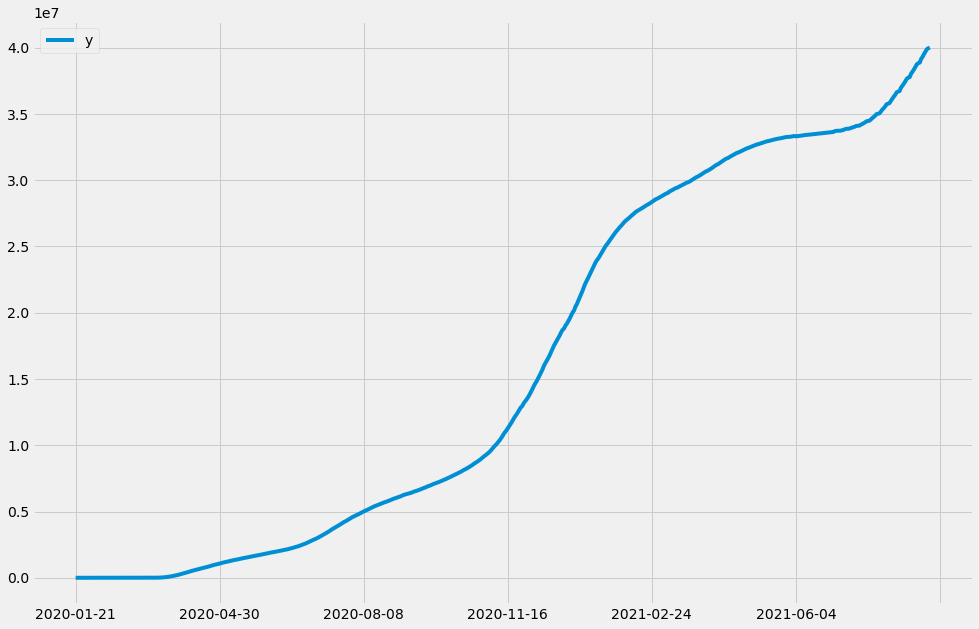

In [197]:
us_covid = pd.read_csv(us_covid)
us_covid.head(10)

# Prophet does have a quirk: a hardcoded format for the input time series - it must consist of a date column named 'ds' (dataframe index or an actual column) and column 'y', where the actual values of the time series are stored
xdat = us_covid[['date', 'cases']].rename(columns={"date": "ds", "cases": "y"})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.77935
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2173.8   0.000867341         461.8           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2233.54    0.00146611       227.869           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2251.58    0.00084613       241.732      0.9594      0.9594      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2255.45   0.000453475       314.398           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2263.26   0.000719739       219.176      0.4714           1      586   
    Iter      log prob        ||dx||      ||grad||       alpha  

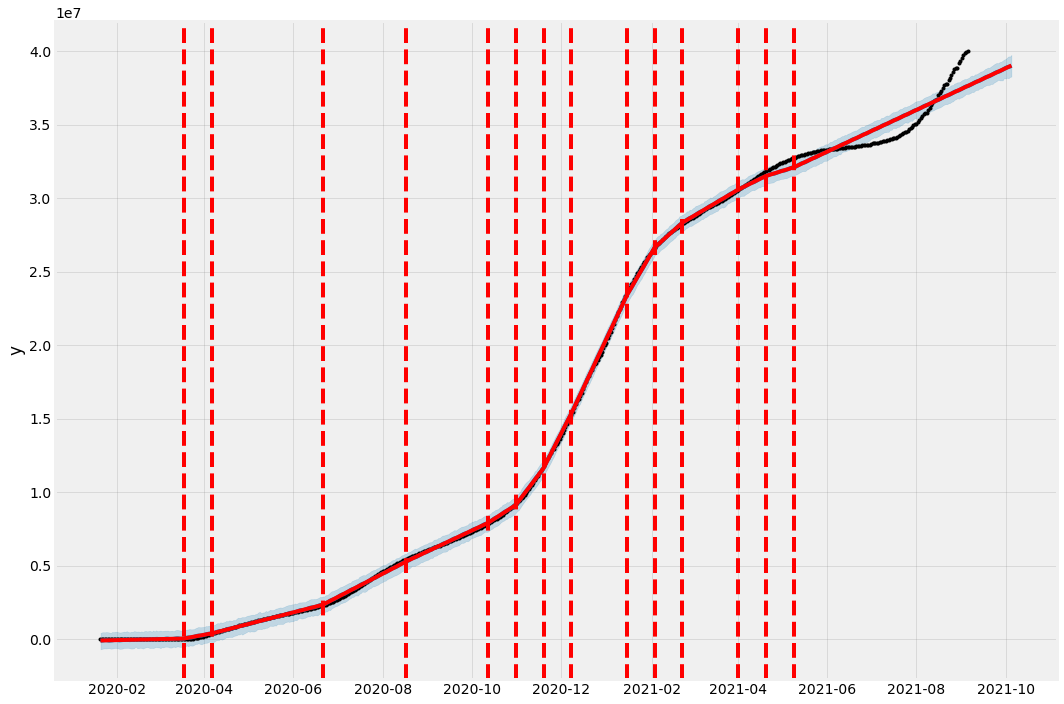

In [198]:
# automatic detection of change points
m = Prophet()
m.fit(xdat)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')
a = add_changepoints_to_plot(fig.gca(), m, forecast)
# tqdm progress bars

It seems like the default settings are on the generous side when it comes to assigning changepoints - we can control this behavior by enforcing more regularization. This is achieved by shrinking the `changepoint_prior_scale` parameter:

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.77935
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1733.94    0.00510707        668.43           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1801.38   0.000820244       875.328           1           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.71   0.000576847       1428.06      0.5069      0.5069      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     363       1840.77   0.000219707       935.787   4.672e-07       0.001      533  LS failed, Hessian reset 
     399       1842.32   0.000306026       313.645           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     444       1843.85   0.000103646    

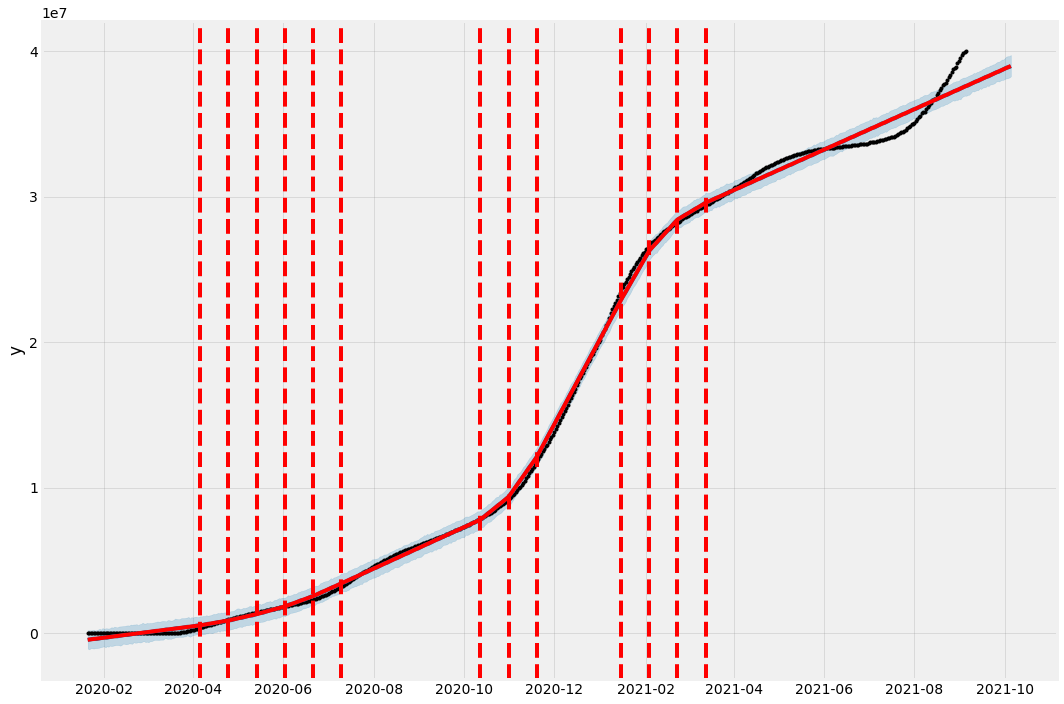

In [199]:
m = Prophet(changepoint_prior_scale=0.01)
m.fit(xdat)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')
a = add_changepoints_to_plot(fig.gca(), m, forecast)


## Nonlinear growth 

The first one is called Nonlinear, Saturating Growth. It is represented in the form of the logistic growth model:
    
\begin{equation}
T(t) = \frac{C}{1 + exp(-k(t-m))}
\end{equation}

where $C$ is the carrying capacity (maximum value) and $k$ is the growth rate ("steepness" of the trend curve). $C$ and $k$ can be constant or time-varying. This logistic equation allows modelling non-linear growth with saturation, that is when the growth rate of a value decreases with its growth. Prophet supports both automatic and manual tuning of their variability. The library can itself choose optimal points of trend changes by fitting the supplied historical data.

Sticking with the theme that has dominated everybody's life from 2020, we will use data on Covid-19 cases in China.

<AxesSubplot:>

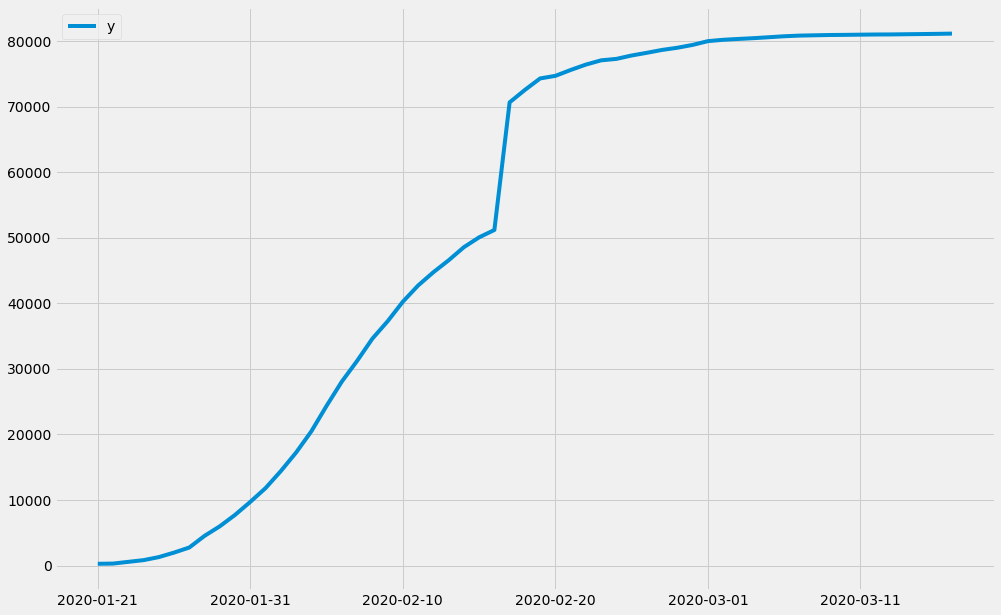

In [200]:
who = pd.read_csv(WHO_full_data2003)
# subset the data and rename the columns to Prophet naming convention
who = who.loc[who['location'] == 'China'][['date', 'total_cases']].rename(columns={"date": "ds", "total_cases": "y"})
who.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')

We can see the curve flatlining somewhat - in Prophet we can incorporate such knowledge into the model by setting a cap (an upper limit on the forecast value):

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -24.7844
Iteration  1. Log joint probability =    11.6334. Improved by 36.4178.
Iteration  2. Log joint probability =    15.4864. Improved by 3.85299.
Iteration  3. Log joint probability =    42.6951. Improved by 27.2086.
Iteration  4. Log joint probability =    42.6997. Improved by 0.00469238.
Iteration  5. Log joint probability =    42.7139. Improved by 0.0142003.
Iteration  6. Log joint probability =    42.7421. Improved by 0.0281619.
Iteration  7. Log joint probability =    42.7567. Improved by 0.0146154.
Iteration  8. Log joint probability =    42.7846. Improved by 0.0278468.
Iteration  9. Log joint probability =    42.7881. Improved by 0.00348525.
Iteration 10. Log joint probability =    42.7945. Improved by 0.00649282.
Iteration 11. Log joint probability =    42.7978. Improved by 0.00324858.
Iteration 12. Log joint probability =    42.8452. Improved by 0.0474326.
Iteration 13. Log joint probability =    42.8571. Improved by 0.0118655.
Iteration 1

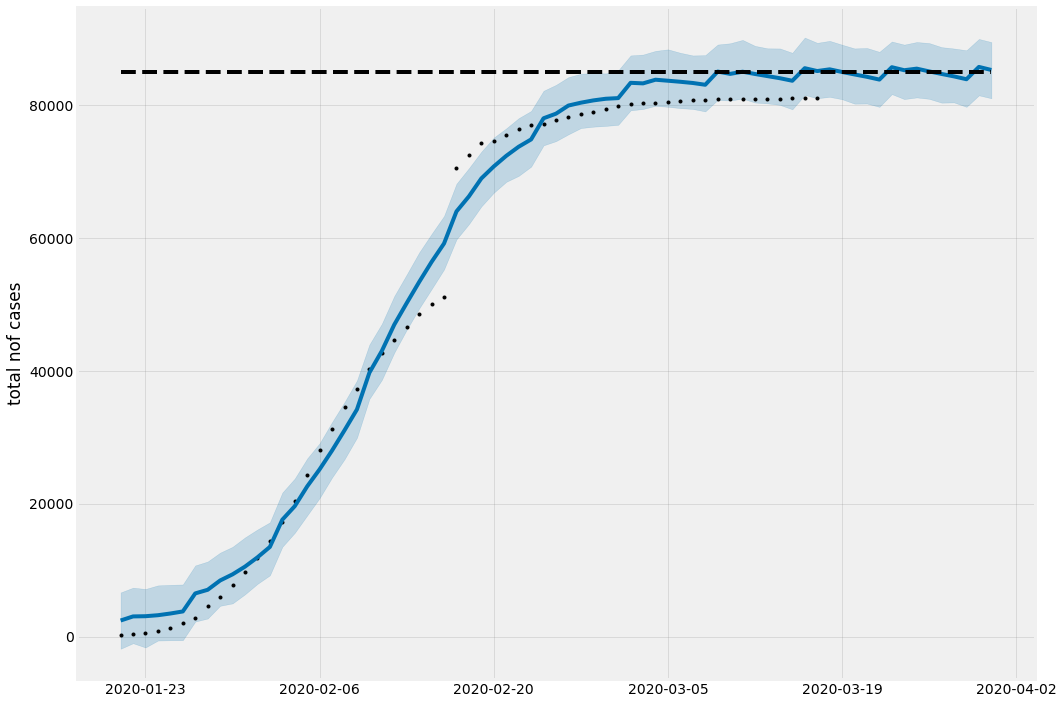

In [201]:
# add the cap
who['cap'] = 85000
# fit the model
m = Prophet(growth='logistic')
m.fit(who)
# prediction
future = m.make_future_dataframe(periods=14)
future['cap'] = 85000
# plot the results
fcst = m.predict(future)
fig = m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='', ylabel='total nof cases')

The approach is symmetrics, i.e. we can limit the series from below as well (contrived as it might seem in this particular application ;-) 

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -24.7844
Iteration  1. Log joint probability =    11.6334. Improved by 36.4178.
Iteration  2. Log joint probability =    15.4864. Improved by 3.85299.
Iteration  3. Log joint probability =    42.6951. Improved by 27.2086.
Iteration  4. Log joint probability =    42.6997. Improved by 0.00469238.
Iteration  5. Log joint probability =    42.7139. Improved by 0.0142003.
Iteration  6. Log joint probability =    42.7421. Improved by 0.0281619.
Iteration  7. Log joint probability =    42.7567. Improved by 0.0146154.
Iteration  8. Log joint probability =    42.7846. Improved by 0.0278468.
Iteration  9. Log joint probability =    42.7881. Improved by 0.00348525.
Iteration 10. Log joint probability =    42.7945. Improved by 0.00649282.
Iteration 11. Log joint probability =    42.7978. Improved by 0.00324858.
Iteration 12. Log joint probability =    42.8452. Improved by 0.0474326.
Iteration 13. Log joint probability =    42.8571. Improved by 0.0118655.
Iteration 1

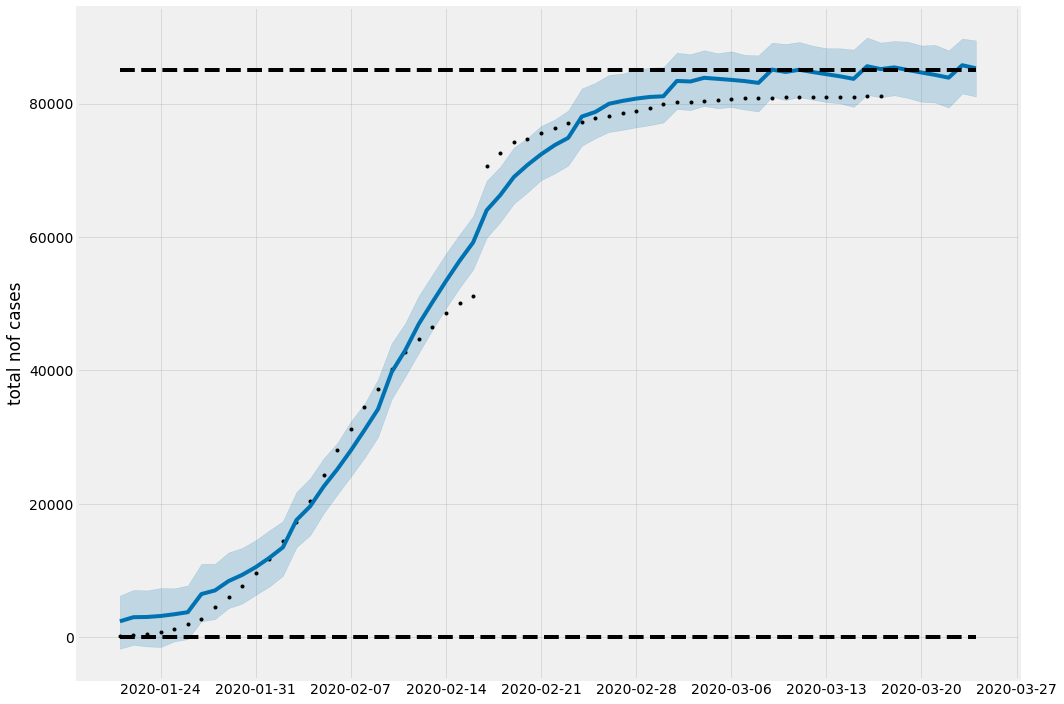

In [202]:
# set the upper & lower limit for the forecast
who['cap'] = 85000
who['floor'] = 0
# fit a model
m = Prophet(growth='logistic')
m.fit(who)
# predict
future = m.make_future_dataframe(periods=7)
future['cap'] = 85000
future['floor'] = 0
fcst = m.predict(future)
m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='', ylabel='total nof cases')
print()

<a id="section-three"></a>
# Seasonality

When dealing with data in practical applications, it is frequently necessary to take into account multiple seasonal patterns occurring in parallel; a classic example would be data related to energy consumption: there are morning vs evening patterns (intraday), workdays vs weekend (weekly) and during the year (annual). Modeling them explicitly tends to be cumbersome (you need to add more equations in exponential smoothing or introduce dummies in ARIMA), which is one of the issues Prophet was designed to overcome. The core of the underlying logic is a the Fourier expansion:
    
\begin{equation}
    S(t) = \sum_{i=1}^N \left(a_n cos\left(\frac{2\pi i t}{P} \right) + b_n sin\left(\frac{2 \pi i t}{P} \right) \right)
\end{equation}

Unpacking this formula: 

* `sin` and `cos` function form an orthogonal basis https://en.wikipedia.org/wiki/Orthogonal_functions#Trigonometric_functions
* this means that every function can be represented as a combination as in the equation defined above - recall that in the GAM setup we treat time as the only regressor, so a time series can be viewed as a function of time $S(t)$ 
* by cutting off the expansion for a certain $N$ we can remove high frequency oscillations $\rightarrow$ low pass filter

## Frequency shenanigans

Let us briefly explore how you can specify different seasonality patterns: we will use the energy consumption data from PJM Interconnection LLC (PJM) - a regional transmission organization (RTO) in the United States. The data is available on Kaggle: https://www.kaggle.com/robikscube/hourly-energy-consumption.

In [203]:
pjm_hourly_est = pd.read_csv(pjm_hourly_est)
pjm_hourly_est['Datetime'] = pd.to_datetime(pjm_hourly_est['Datetime'])
pjm_hourly_est.head(5)

Datetime  AEP  COMED  DAYTON  DEOK  DOM  DUQ  EKPC  FE  NI  PJME  \
0 1998-12-31 01:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
1 1998-12-31 02:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
2 1998-12-31 03:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
3 1998-12-31 04:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
4 1998-12-31 05:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   

   PJMW  PJM_Load  
0   NaN   29309.0  
1   NaN   28236.0  
2   NaN   27692.0  
3   NaN   27596.0  
4   NaN   27888.0

Prophet is built for univariate data, so we will pick one series. Notice that we are using hourly data, which we will progressively aggregate to lower frequencies to demonstrate the out-of-the-box functionality that Prophet provides.

<AxesSubplot:xlabel='ds'>

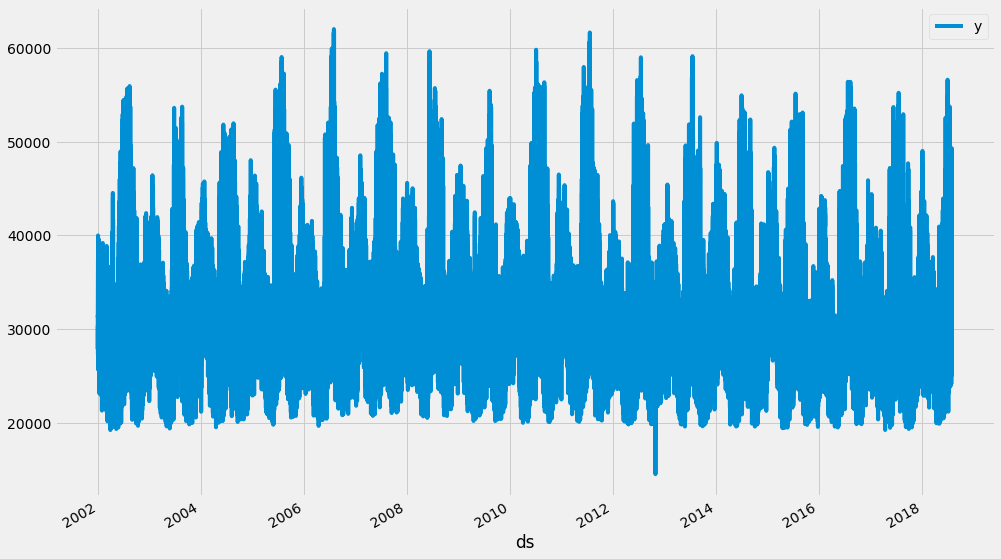

In [204]:
xdat = pjm_hourly_est[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2))

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -200.673
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       70819.3    0.00248625       1976.59           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       70913.2    0.00204818       1592.86           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       70963.1     0.0136338       1942.47      0.2535      0.2535      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       71027.2    0.00332844        966.63           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       71050.4    0.00388253       590.991           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

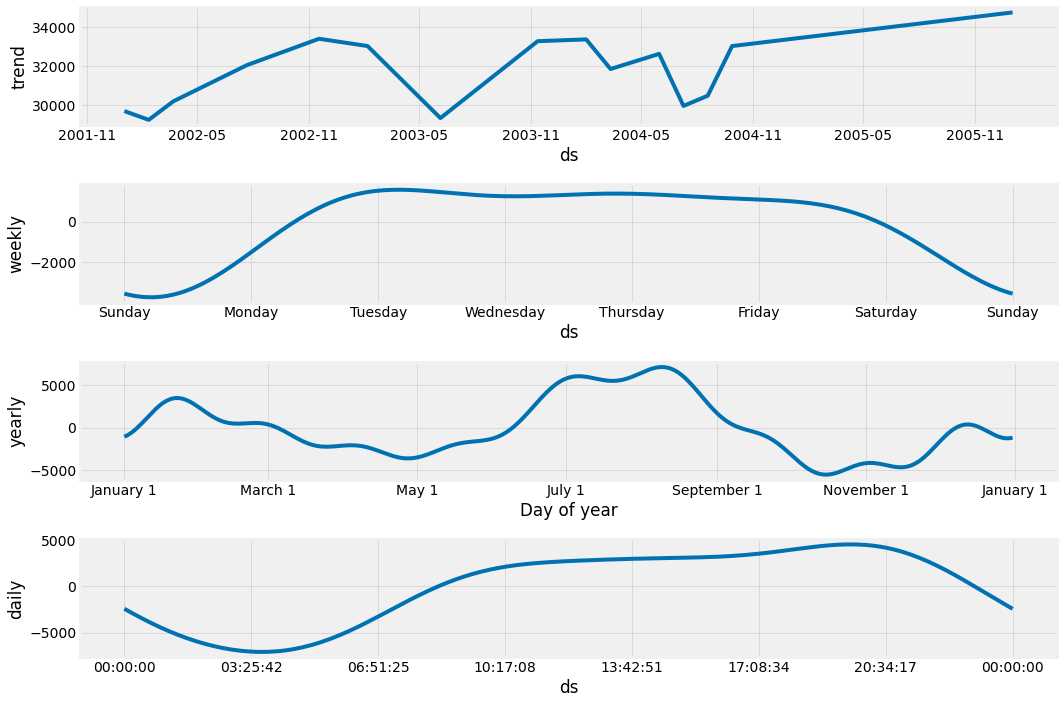

In [205]:
# we reduce the dataset size for speed - the only requirement while doing is to keep at least two complete cycles for each seasonality we intend to fit
m = Prophet().fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods=24, freq='H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

If we are using data sampled at higher frequency than daily, a daily seasonal pattern is automatically fitted. What if we aggregate the data to daily frequency?

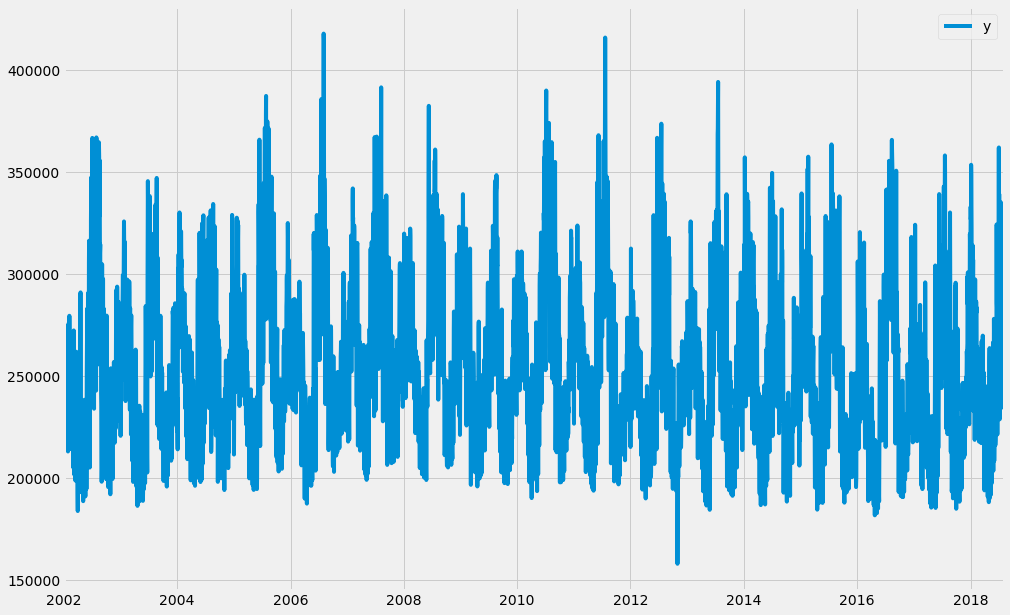

In [206]:
xdat = pjm_hourly_est.resample('D', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9
# we purge the leading zeros, along with the last observation - we only have a few hours of the last day in the sample => incomplete day
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')
print()

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -45.4112
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       14515.9    0.00102431       235.415       0.988       0.988      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       14518.2   0.000241208       105.995           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       14519.2   0.000812571       230.835           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       14519.7     0.0001597       102.904       0.624       0.624      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     456       14519.8   7.95989e-07       64.3686      0.2268      0.5847      557   
Optimization terminated normally: 
  Convergence detected: relat

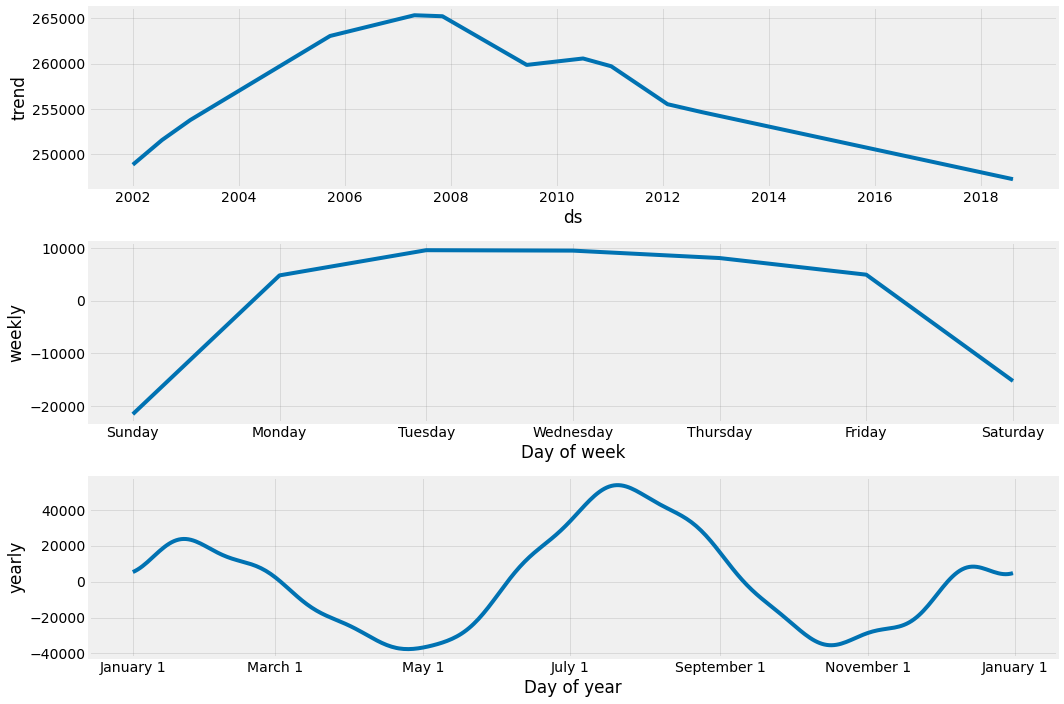

In [207]:
# we proceed in a similar manner as before
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods=7, freq='D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

The same logic applies if we downsample the data further:

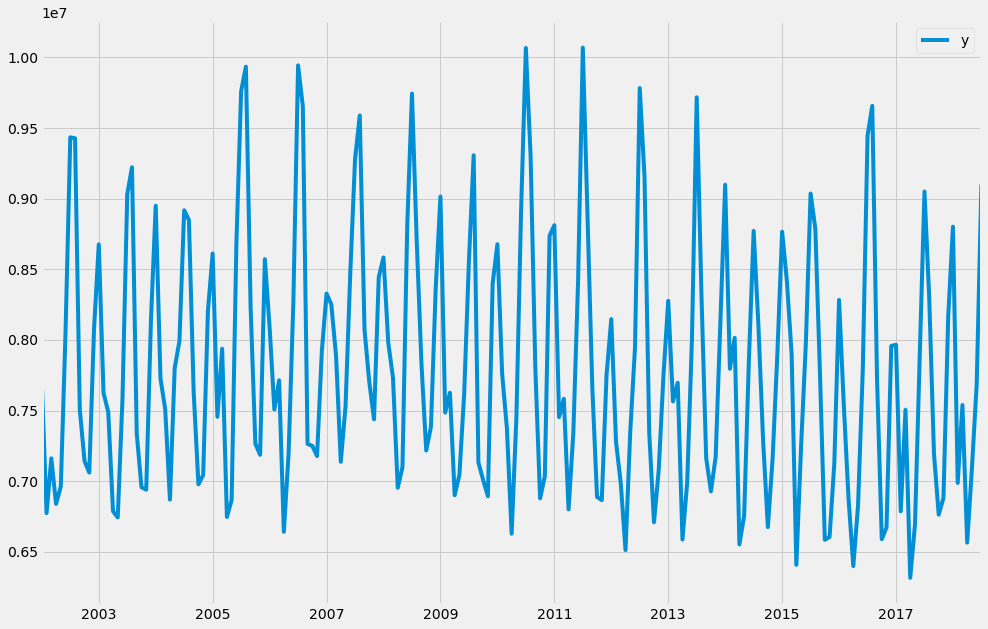

In [208]:
xdat = pjm_hourly_est.resample('M', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9
# we purge the leading zeros, along with the last observation - we only have a few hours of the last day in the sample => incomplete day
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel='')
print()

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.38019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       582.672     0.0013405       80.5081      0.5724      0.5724      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       582.726   1.71281e-06       74.5092     0.05618           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       582.726   4.84647e-07       89.6293   6.505e-09       0.001      290  LS failed, Hessian reset 
     216       582.726   1.83327e-08       75.5466      0.2046           1      312   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance



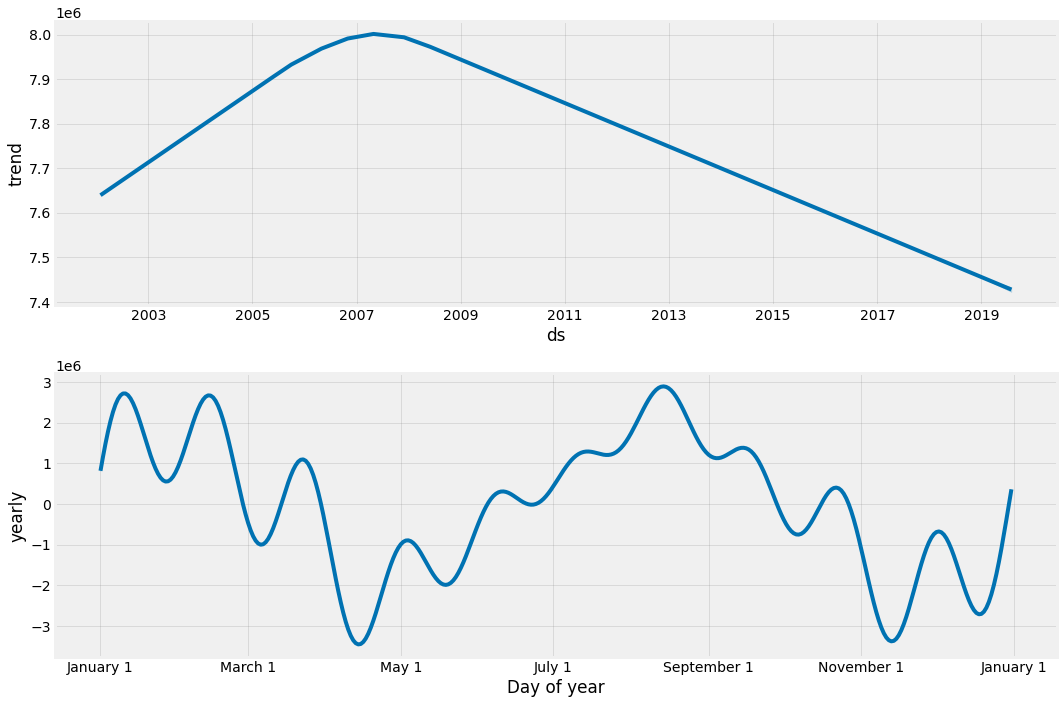

In [209]:
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

## Seasonality specification

Apart from deciding on which frequencies to model explicitly, we have more options to setup our Prophet model. First, there is `seasonality_mode` - additive or multiplicative:

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        401.66   1.79041e-05       55.4697           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159         401.8   7.30906e-05       77.6891   1.072e-06       0.001      246  LS failed, Hessian reset 
     181       401.805   1.83883e-05       54.9427   2.747e-07       0.001      307  LS failed, Hessian reset 
     199       401.806   4.36665e-07       56.9097      0.1579           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        401.86   1.34499e-06       66.5975           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382       401.861   4.08281e-08       80.1649      0.1685           1      567   
Optimization terminat

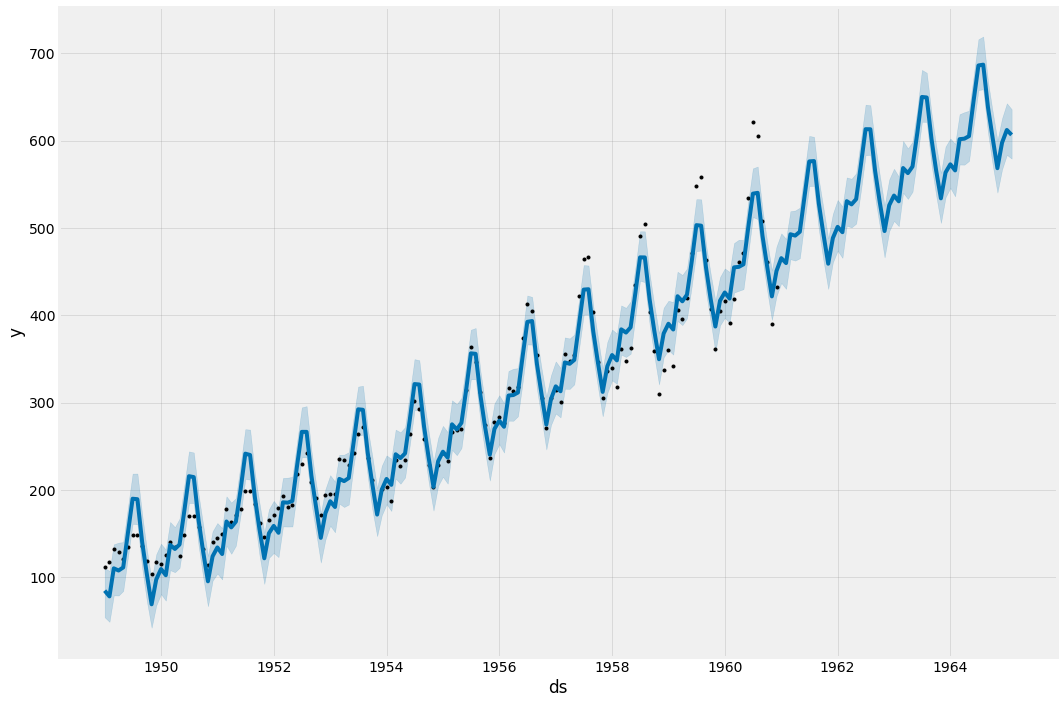

In [210]:
# import inspect ; xlist = inspect.getfullargspec(Prophet); xlist.args
example_air_passengers = pd.read_csv(example_air_passengers)
m = Prophet(seasonality_mode='additive')
m.fit(example_air_passengers)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.449     0.0176543       240.422       0.649           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       503.353    0.00108498       90.0341      0.3062      0.3062      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       503.446   0.000140197        80.679           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       503.467   9.96247e-05       114.472   7.079e-07       0.001      451  LS failed, Hessian reset 
     359       503.486   8.82342e-09       72.6598    0.004982           1      538   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


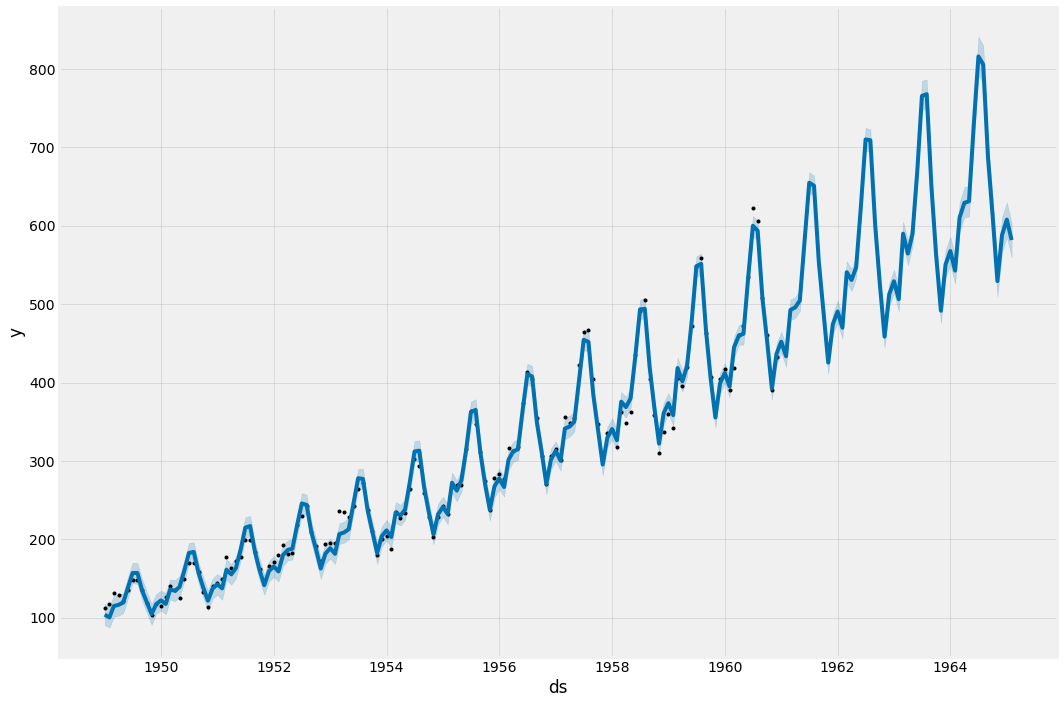

In [211]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(example_air_passengers)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

Depending on the problem at hand, we might want to allow strong effects of the seasonal component on the forecast - or have it reduced. This intuition can be quantified by adjusting the `seasonality_prior_scale` argument, which imapcts the extent to which the seasonality model will fit the data (remark for those with Bayesian exposure: works pretty much the way a prior would).

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.449     0.0176543       240.422       0.649           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       503.353    0.00108498       90.0341      0.3062      0.3062      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       503.446   0.000140197        80.679           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       503.467   9.96247e-05       114.472   7.079e-07       0.001      451  LS failed, Hessian reset 
     359       503.486   8.82342e-09       72.6598    0.004982           1      538   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


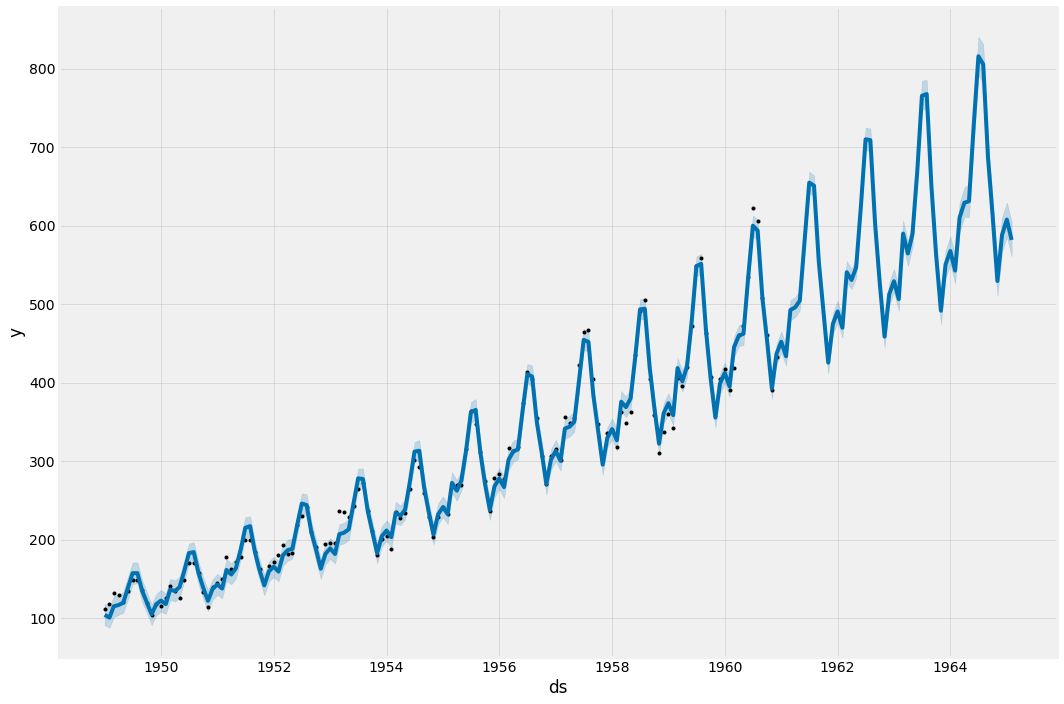

In [212]:
# we keep the default value
m = Prophet(seasonality_mode='multiplicative')
m.fit(example_air_passengers)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.608   0.000325743       50.8423       0.757       0.757      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       501.794   0.000243299       168.853   2.741e-06       0.001      198  LS failed, Hessian reset 
     199       502.731    0.00154449       97.7148           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       503.209   0.000148131       134.069   1.965e-06       0.001      389  LS failed, Hessian reset 
     299       503.416   0.000374679       123.845           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       503.502   2.19353e-05       78.1019   2.837e-07       0.001      564  LS failed, Hessian rese

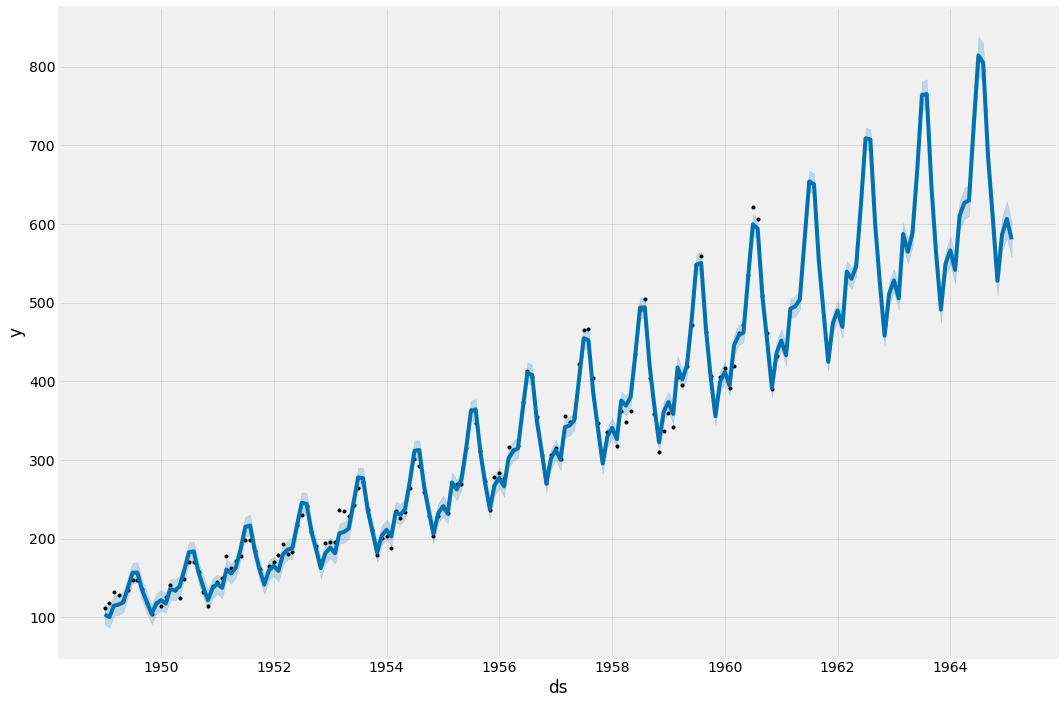

In [213]:
# we reduce the seasonality prior
m = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale=1)
m.fit(example_air_passengers)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

Last but not least, we can - as we usually ought to - use interval forecast, i.e. have our point estimates combined with uncertainty. By default the parameter `mcmc_samples` is set to 0, so to get the interval around seasonality, you must do full Bayesian sampling; uncertainty around trend can be calculated with Maximum A Posteriori (MAP) estimate.

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -200.673
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       70819.3    0.00248625       1976.59           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       70913.2    0.00204818       1592.86           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       70963.1     0.0136338       1942.47      0.2535      0.2535      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       71027.2    0.00332844        966.63           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       71050.4    0.00388253       590.991           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

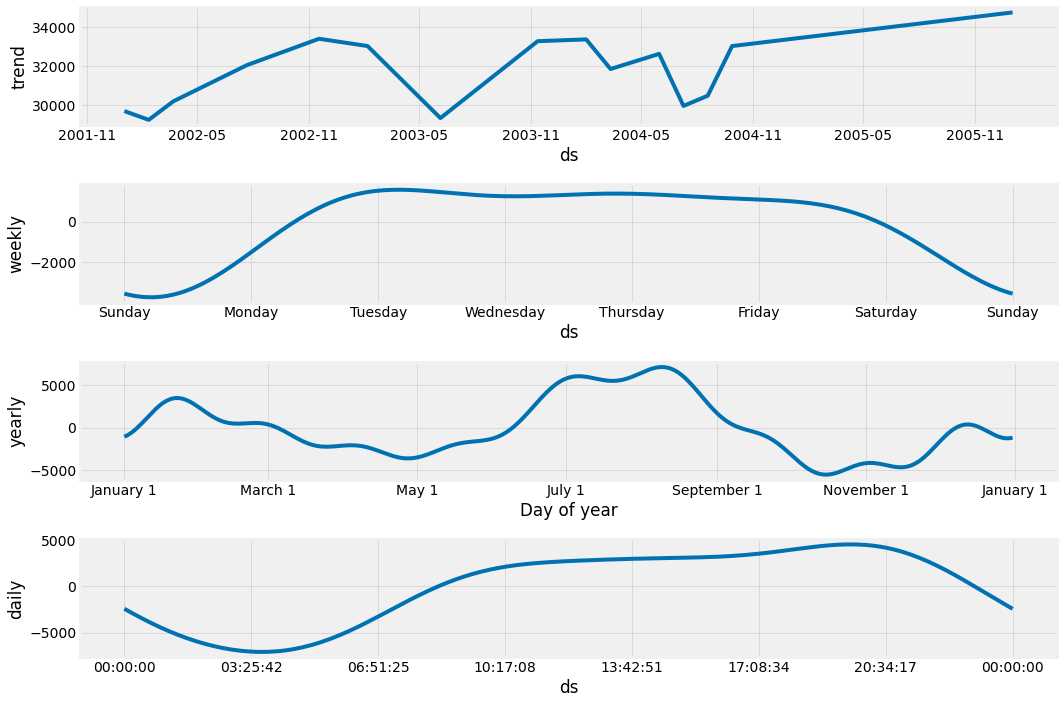

In [214]:
df = pd.read_csv(pjm_hourly_est)
df['Datetime'] = pd.to_datetime(df['Datetime'])
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"})
# xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2))
m = Prophet().fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods=24, freq='H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

What if we switch to Bayesian inference (change `mcmc_samples` to a positive integer)?

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN



Gradient evaluation took 0.023764 seconds
1000 transitions using 10 leapfrog steps per transition would take 237.64 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.031242 seconds
1000 transitions using 10 leapfrog steps per transition would take 312.42 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.032734 seconds
1000 transitions using 10 leapfrog steps per transition would take 327.34 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.02362 seconds
1000 transitions using 10 leapfrog steps per transition would take 236.2 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of th

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 3 / 10 [ 30%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 3 / 10 [ 30%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 4 / 10 [ 40%]  (Warmup)
Iteration: 3 / 10 [ 30%]  (Warmup)
Iteration: 4 / 10 [ 40%]  (Warmup)
Iteration: 3 / 10 [ 30%]  (Warmup)
Iteration: 5 / 10 [ 50%]  (Warmup)
Iteration: 4 / 10 [ 40%]  (Warmup)
Iteration: 5 / 10 [ 50%]  (Warmup)
Iteration: 4 / 10 [ 40%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of th

Iteration: 5 / 10 [ 50%]  (Warmup)
Iteration: 5 / 10 [ 50%]  (Warmup)
Iteration: 6 / 10 [ 60%]  (Sampling)
Iteration: 6 / 10 [ 60%]  (Sampling)
Iteration: 6 / 10 [ 60%]  (Sampling)
Iteration: 7 / 10 [ 70%]  (Sampling)
Iteration: 7 / 10 [ 70%]  (Sampling)
Iteration: 6 / 10 [ 60%]  (Sampling)
Iteration: 7 / 10 [ 70%]  (Sampling)
Iteration: 8 / 10 [ 80%]  (Sampling)
Iteration: 8 / 10 [ 80%]  (Sampling)
Iteration: 7 / 10 [ 70%]  (Sampling)
Iteration: 8 / 10 [ 80%]  (Sampling)
Iteration: 9 / 10 [ 90%]  (Sampling)
Iteration: 9 / 10 [ 90%]  (Sampling)
Iteration: 8 / 10 [ 80%]  (Sampling)
Iteration: 9 / 10 [ 90%]  (Sampling)
Iteration: 10 / 10 [100%]  (Sampling)
Iteration: 9 / 10 [ 90%]  (Sampling)
Iteration: 10 / 10 [100%]  (Sampling)
Iteration: 10 / 10 [100%]  (Sampling)

 Elapsed Time: 0.266726 seconds (Warm-up)
               0.186209 seconds (Sampling)
               0.452935 seconds (Total)

Iteration: 10 / 10 [100%]  (Sampling)

 Elapsed Time: 0.255162 seconds (Warm-up)
               0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


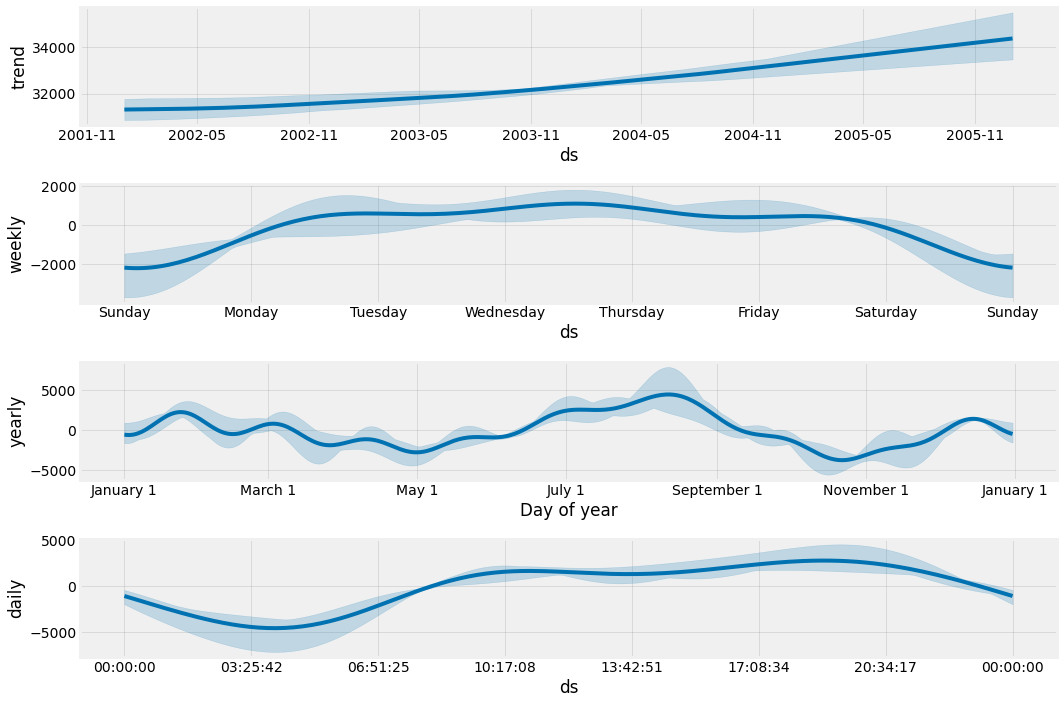

In [215]:
m = Prophet(mcmc_samples=10).fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods=24, freq='H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

Keep in mind that although PyStan https://pystan.readthedocs.io/en/latest/ is SOTA for MCMC sampling, it still takes some time - especially for long time series. 

<a id="section-four"></a>
# Special days

So we have handled trend and seasonality - but that does not mean everything else belongs with the random error component. There are data points that are not random per se, but can still have impact on the performance of the model:

* public holidays (Christmas, Easter, New Year, Black Friday)
* special events (World Cup) 
* major events like conflict starting or terrorist attacks - when analyzing historical performance of the model, it is frequently useful to remove those
* outliers - this is something of a catch-all category, but frequently possible to identify by inspecting the data. 

The Prophet approach to modeling abnormal days is to provide a custom list of events. We assume the effects are independent, so if e.g. a sports event occurs near public holiday, their effects will be captured separately.

## Holidays

The dataset we will use to test the Prophet functionality around special days is daily count of bike commuters in Oslo https://www.kaggle.com/konradb/norway-bicycles

In [216]:
bikerides = pd.read_csv(bikerides_day, error_bad_lines=False, encoding= 'unicode_escape', delimiter=',')
bikerides.head(5)
# the usual formatting
bikerides = bikerides[['Date', 'Volume']].rename(columns={"Date": "ds", "Volume": "y"})

We start with the fast and easy way of adding holidays: using the built-in list of country holidays:

In [217]:
m = Prophet()
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
# List the holiday names
m.train_holiday_names

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -48.809


0         Første nyttårsdag
1           Arbeidernes dag
2              Grunnlovsdag
3            Første juledag
4             Andre juledag
5              Skjærtorsdag
6                Langfredag
7           Første påskedag
8            Andre påskedag
9     Kristi himmelfartsdag
10          Første pinsedag
11           Andre pinsedag
dtype: object

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2248.45   0.000504974       83.5574           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       2248.63    0.00128056       215.444   1.392e-05       0.001      180  LS failed, Hessian reset 
     199       2248.85   0.000188922       86.0164      0.5146           1      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       2248.86   4.86091e-05       89.3125   5.439e-07       0.001      367  LS failed, Hessian reset 
     299       2248.93   1.81792e-06       56.5065           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       2248.93   1.47536e-07       54.0186      0.7008      0.7008      485   
Optimization terminated normally: 
  Convergence detected: rel

I don't speak Norwegian, but a quick visit to Google Translate shows that Christmas is missing - which, in Europe, is typically a rather important public holiday. We will take care of adding it later, for now let's see how well the model is doing out of the box:

In [218]:
# as before, we create a dataframe holding the dates for the entire forecast horizon - 180 days ahead
future = m.make_future_dataframe(periods=180, freq='D')
# generate the actual forecast 
forecast = m.predict(future)
fig = go.Figure()
# full disclosure: I am changing the plotting style for this one, because I don't know how to overlay the two graphs with the baseline Prophet plotting functionality that served us well up to that point (not to mention the cool functionality of panning/scaling the graph ;-)

fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

Overall the forecast seems directionally ok - but if we zoom a little closer, there are issues:


<img src="images/issues.png"/>


Let's see if we can improve by augmenting the list of holidays: we do that by creating a new dataframe `christmas`, which is subsequently passed as an argument to Prophet. The 'holiday' entry is mostly for interpretation sake, relevant parts are:
* `ds` - so we know when the holiday of interest occurs
* `lower_window` and `upper_window`: those two parameters allow us to incorporate the effect before/after the date, respectively. In our example below `lower_window` equals -1, meaning we anticipate a drop in the number of commuters a day before Christmas, whereas `upper_window` is 7 - with a lot of people taking time off between Christmas and New Year, the bicycle traffic is likely to decrease for approximately a week. 

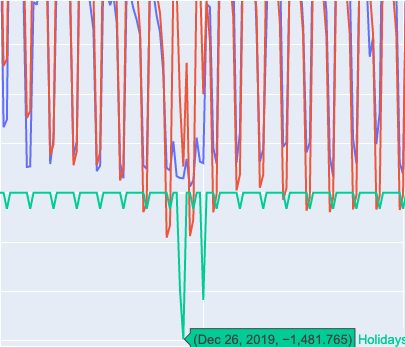

In [219]:
christmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24']),
  'lower_window': -1,
  'upper_window': 7,
})

m = Prophet(holidays=christmas)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -48.809
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2258.44    0.00103918       83.2489           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2259.8   7.51307e-06       69.4314           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       2259.82   0.000231754        83.744   3.346e-06       0.001      339  LS failed, Hessian reset 
     297       2259.85   4.93157e-06       76.2639   6.487e-08       0.001      453  LS failed, Hessian reset 
     299       2259.85   2.82596e-06       72.7711           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       2259.85   2.70504e-08       66.0937      0.0556           1      475   
Optimization terminate

This does look better:

<img src="images/better_forecast.png"/>
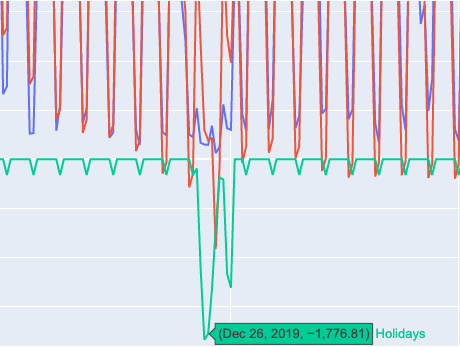

## Outliers

We can use the built-in Prophet functionality to deal with outliers - for the sake of clarity of exposition, we will re-use the example used also in the official documentation, i.e. log of daily count of visits to the Wikipedia page of R language.

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -16.7301
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6649.11      0.042566       2235.13           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6906.31      0.115006       3612.63           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6979.37    0.00196595       284.829           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        7008.8    0.00757209       642.548           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7052.57     0.0106923       530.595           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

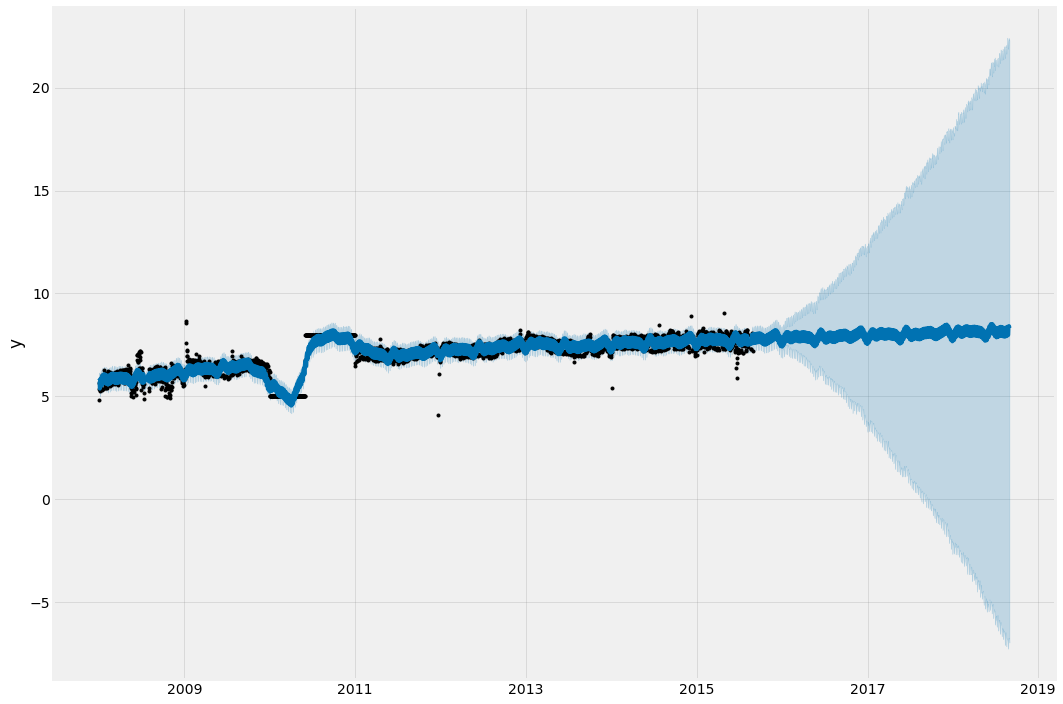

In [220]:
df = pd.read_csv(example_wp_log_R_outliers1)
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')

The pattern in 2011 does not look plausible (flat line, jump, flat line at a higher level), and those observations are the most likely culprit for the misspecified trend and the resulting bredth of the confidence bands. Prophet allows us to deal with the problem in a very straightforward manner, i.e. by replacing the dubious observations with `None` (not `NaN` - it is an important distinction to keep in mind).

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.9532
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7510.97    0.00309778       586.355        1.51       0.151      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7520.68     0.0016272       907.679       0.196           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          7525   0.000157309       109.366      0.8884      0.8884      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7525.75   0.000204023       294.238      0.7844      0.7844      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     446       7525.91     1.321e-05       86.5066   1.144e-07       0.001      574  LS failed, Hessian reset 
     499        7526.1   0.000436798    

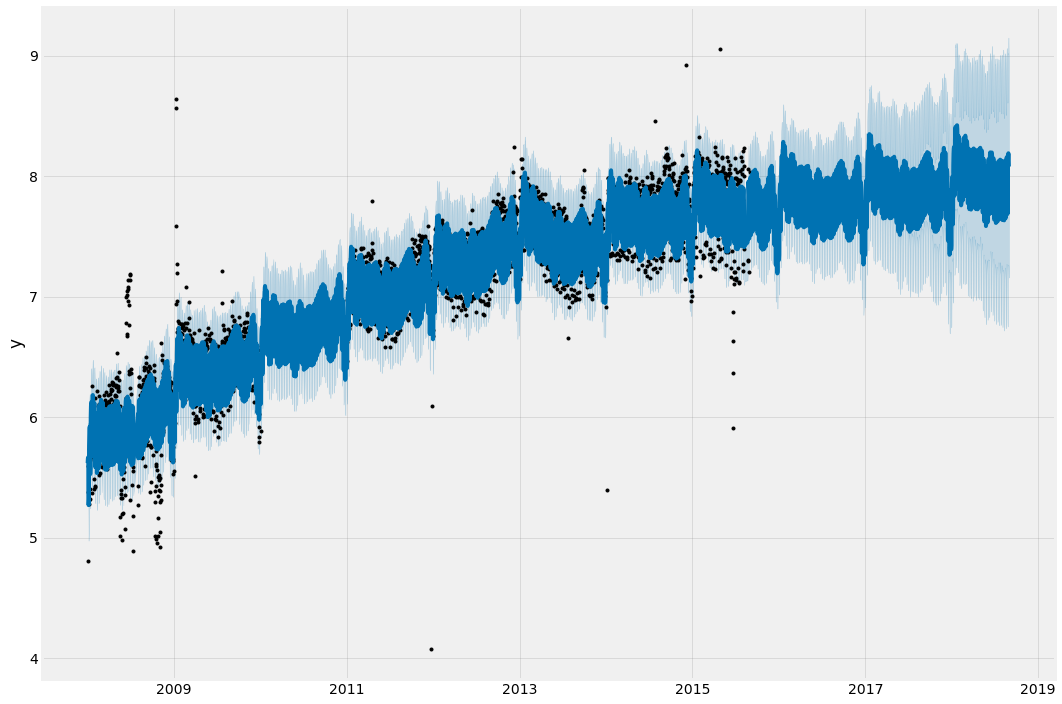

In [221]:
df.loc[(df['ds'] > '2010-01-01') & (df['ds'] < '2011-01-01'), 'y'] = None
model = Prophet().fit(df)
fig = model.plot(model.predict(future), figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')
plt.show()

Another type of situation we may encounter is a few points whose values are extremely off, so as a result the seasonality estimate is impacted.

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -17.2236
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6576.44    0.00344255       312.101           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       6579.94   0.000107528       108.048    3.59e-07       0.001      280  LS failed, Hessian reset 
     199       6580.88   0.000779136       176.424      0.7761      0.7761      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       6581.43   6.28995e-05        92.756   7.368e-07       0.001      444  LS failed, Hessian reset 
     299       6581.46   5.45198e-06       68.4953      0.6058      0.6058      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       6581.46   5.67007e-07       62.9113           1           1      490   
Optimization terminat

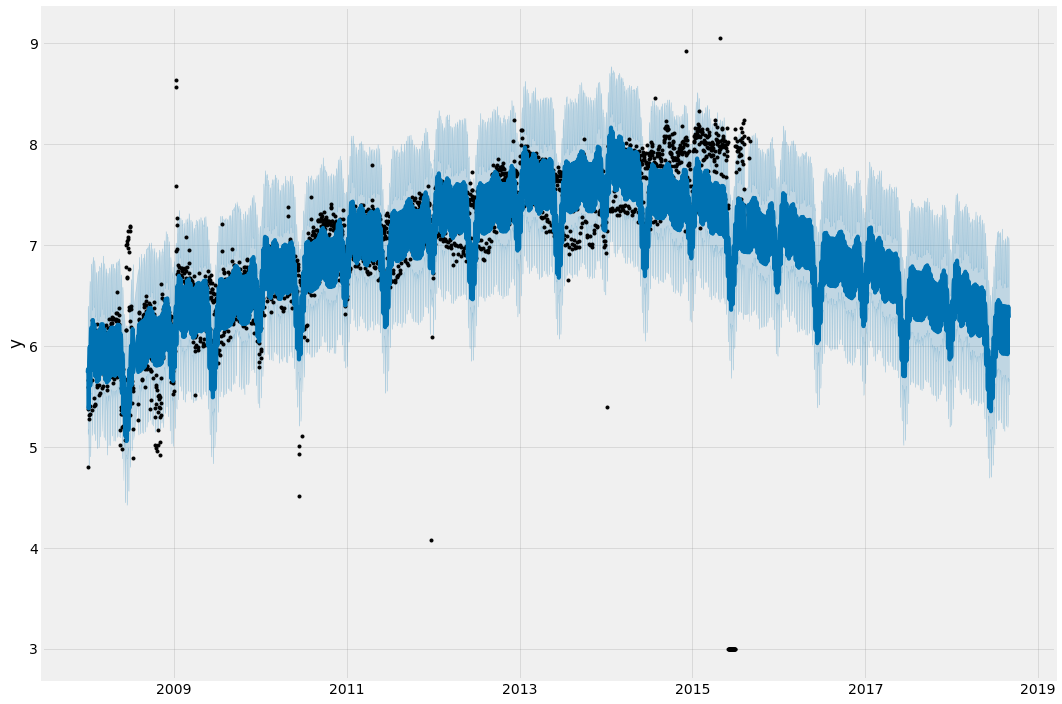

In [222]:
df = pd.read_csv(example_wp_log_R_outliers2)
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')
plt.show()

As before, the simplest solution is to get rid of those points and leave the algorithm to interpolate within the sample:

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.0441
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8577.67    0.00555028       695.737           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8588.11    0.00426311       751.756           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8591.47    0.00014163       360.592      0.2086      0.2086      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       8592.19   3.00987e-05       175.533   2.598e-07       0.001      436  LS failed, Hessian reset 
     360        8592.7   1.93259e-05       65.2617   7.246e-08       0.001      524  LS failed, Hessian reset 
     399       8593.01   0.000419535       59.4556           1           1      581   
    Iter      log pro

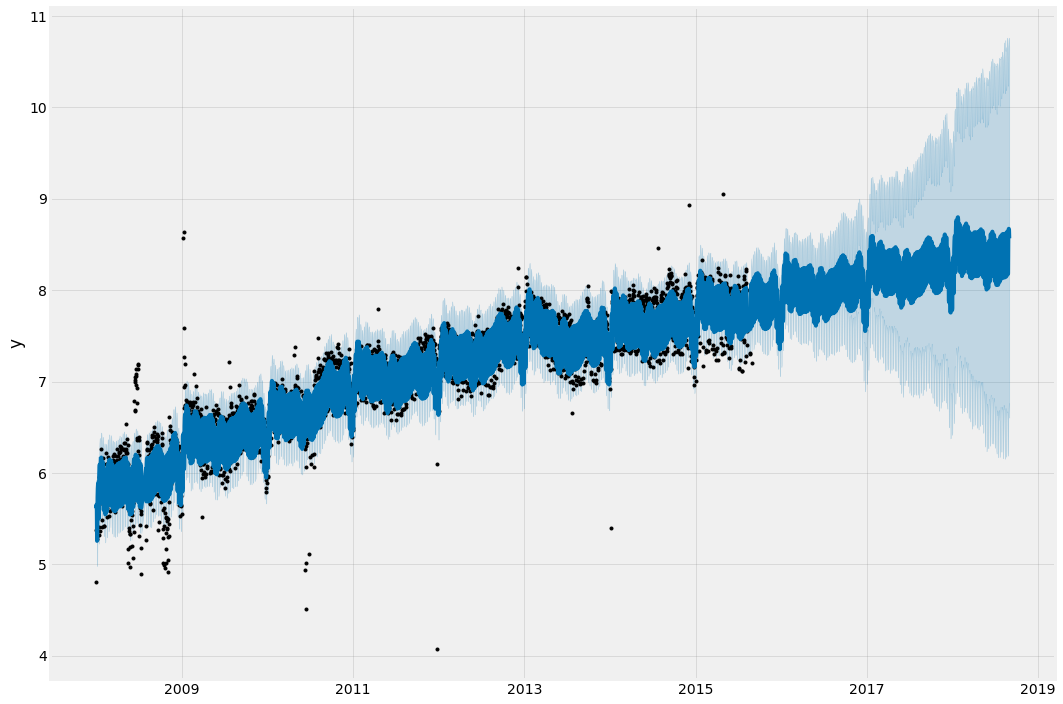

In [223]:
df.loc[(df['ds'] > '2015-06-01') & (df['ds'] < '2015-06-30'), 'y'] = None
m = Prophet().fit(df)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')
plt.show()

To summarize: leveraging the Prophet functionality around in-sample interpolation, we can solve issues related to outliers by simply replacing them with `None`s.

<a id="section-five"></a>
# Performance evaluation

Cross validation for time series can be sometimes challenging, but the Prophet approach takes the hassle out of having to create your own function for a rolling forecast. We utilize the `cross_validation` function: the parameters to specify are the forecast horizon `horizon` and (optionally) size of the initial training period `initial` and the spacing between cutoff dates `period`. By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

       

In [224]:
df_cv = cross_validation(m, initial = '1000 days', period = '30 days', horizon='30 days')

INFO:fbprophet:Making 59 forecasts with cutoffs between 2010-10-26 00:00:00 and 2015-08-01 00:00:00


  0%|          | 0/59 [00:00<?, ?it/s]

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -4.67455
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2850.18   0.000492983       118.798     0.08389      0.5493      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2854.28     0.0187185       411.611           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2856.38   0.000981635       134.673       4.242      0.4242      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       2856.57    0.00024892       239.254   2.768e-06       0.001      415  LS failed, Hessian reset 
     354       2856.84    0.00016293        194.93   1.519e-06       0.001      505  LS failed, Hessian reset 
     399       2856.89   1.03473e-06       72.1293      0.8568      0.8568      574   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -5.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2943.59    0.00641871       324.798           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2949.44   0.000699638       225.984      0.1175      0.1175      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2951.03    0.00351524       249.372      0.2826      0.7216      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       2952.17   0.000460802       175.933   2.874e-06       0.001      419  LS failed, Hessian reset 
     399       2953.22   0.000473685       54.0803      0.4625      0.4625      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2953.34   3.75139e-06     

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -8.16066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3038.35   0.000676403       148.903      0.4876     0.04876      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3043.48    0.00850867       149.957           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3048.17   0.000894825       159.527           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3049.21    7.8461e-05       53.2851      0.2985           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     446       3049.34   4.62953e-05       63.0483   1.046e-06       0.001      632  LS failed, Hessian reset 
     499       3049.45   1.32471e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -5.08747
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3126.76    0.00264009       166.712      0.5494      0.5494      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3135.29    0.00421487        200.62           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3136.25   0.000113959        92.897           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       3138.47   0.000155218       127.632   2.794e-07       0.001      469  LS failed, Hessian reset 
     399       3139.61    0.00801581       190.592           1           1      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     488       3140.24   8.43639e-08    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -5.31549
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3224.45    0.00974012       646.085      0.6074      0.6074      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3229.47   0.000519631       109.994           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3231.93   3.01141e-05       78.7125       0.227       0.227      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       3231.99   0.000258484         196.6   2.118e-06       0.001      414  LS failed, Hessian reset 
     350       3232.03   3.64237e-09       79.4815     0.01727           1      466   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -5.59701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3317.05    0.00102255         146.5           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3326.98      0.001233       230.005      0.3267      0.3267      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       3329.66   0.000265967       140.009   2.335e-06       0.001      325  LS failed, Hessian reset 
     299       3330.44    0.00106819       176.993           1           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       3330.79   0.000104236       212.503   5.722e-07       0.001      461  LS failed, Hessian reset 
     399       3331.26    0.00050565        63.018     0.04064           1      559   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -7.00509
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3416.73   0.000881055        345.83     0.04905           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3425.21    0.00157637       108.724           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3430.65   0.000989334       219.977      0.6478      0.6478      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       3431.14   7.81071e-05       154.765   3.476e-07       0.001      419  LS failed, Hessian reset 
     399       3431.89   0.000208031       84.7959           1           1      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3432.66   0.000101279    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -5.71325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3519.83   0.000669975       163.781      0.5285     0.05285      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3528.77   0.000702536       103.598           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3534.35    0.00303272       344.977           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       3534.95   6.78794e-05       148.521   3.472e-07       0.001      486  LS failed, Hessian reset 
     399       3535.04   6.80464e-05       69.3452           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     414       3535.08   0.000104526    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -5.81736
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3626.1   0.000439184       259.324           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3636.3    0.00218552       510.722       0.935       0.935      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3639.09    0.00282437       482.579           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3640.96    0.00254104       111.954           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3642.26     0.0104917       88.5053      0.3804           1      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -8.49754
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3724.79     0.0403306       667.624           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3733.38     0.0106126        350.11           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3735.49   0.000600619       91.6533           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3738.31    0.00637462       198.953           1           1      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3739.85    0.00181427       174.378           1           1      606   
    Iter      log prob        ||dx||      ||grad||       alpha  

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -6.05152
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3826.1    0.00387107       172.595           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3838.25   0.000888151       446.691      0.4018      0.4018      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       3838.45   5.62562e-05       123.818   2.824e-07       0.001      299  LS failed, Hessian reset 
     299       3840.93    0.00333413       300.183           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       3841.81   0.000134707         288.2   4.633e-07       0.001      454  LS failed, Hessian reset 
     399       3842.93    0.00154564       252.655           1           1      564   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -6.54802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3922.09    0.00369007       183.211           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3932.25    0.00028359       109.582           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       3933.63   9.61324e-05       146.497   1.101e-06       0.001      357  LS failed, Hessian reset 
     299       3935.03   0.000338681       85.4288       0.316      0.8631      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3936.73    0.00759606        195.57           1           1      550   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     492       3939.02   5.31888e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -6.35907
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       4016.24   0.000229465       172.033   2.006e-06       0.001      161  LS failed, Hessian reset 
      99       4016.24   2.81463e-05       164.261      0.6131      0.6131      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4029.11    0.00109328       202.283      0.3856      0.3856      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       4033.26   6.35062e-05       153.021   5.661e-07       0.001      382  LS failed, Hessian reset 
     299       4034.23   0.000363123       116.426           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4036.21   8.64131e-05       87.5766      0.1961      0.9042      550   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -7.75892
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4115.71    0.00182861       276.753      0.5813      0.5813      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4124.98    0.00325149       355.322           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       4126.38   4.78015e-05       111.622   2.281e-07       0.001      311  LS failed, Hessian reset 
     299       4127.83    0.00039122       167.146      0.4577      0.4577      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       4129.57    0.00028434       724.777   2.885e-07       0.001      463  LS failed, Hessian reset 
     368       4132.34   6.04759e-05       127.205   2.131e-07       0.001      564  LS failed, Hessian rese

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -6.83678
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4212.8    0.00739163       163.626           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4222.89    0.00188306       155.745      0.9661      0.9661      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        4227.6    0.00201053       87.9734           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       4227.84   5.56518e-05       122.008   2.107e-07       0.001      399  LS failed, Hessian reset 
     389       4228.53   4.69675e-05       132.178   2.959e-07       0.001      546  LS failed, Hessian reset 
     399       4228.68   0.000258722       115.127           1           1      557   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -6.23717
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4236.01    0.00283286       437.228      0.2911      0.2911      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4241.04    0.00661103       286.204           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4246.68    0.00953056       323.171           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4248.77   0.000110371       91.5933     0.08142           1      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422        4248.9   0.000105922       190.942   6.835e-07       0.001      547  LS failed, Hessian reset 
     470       4248.95   4.19397e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -8.20163
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4336.61    0.00450871       378.296           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4343.29    0.00278835       285.566           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4347.01    0.00188693       251.916       6.895      0.6895      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4348.31   4.24005e-05       69.2486      0.4819      0.4819      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     467       4348.77   0.000109362       203.946   8.033e-07       0.001      601  LS failed, Hessian reset 
     499       4348.91   5.28144e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -6.77356
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4439.11   0.000754085       169.414           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       4442.07    6.6903e-05       174.972    3.14e-07       0.001      235  LS failed, Hessian reset 
     199       4442.91   0.000268998       95.1273           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4445.49    0.00267985       222.391           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4447.75   0.000338866       196.982      0.7414      0.7414      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     423        4447.8   6.40954e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -6.91253
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4541.37   0.000416167       162.145      0.4659      0.4659      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195        4546.9   4.46567e-05        113.69   5.205e-07       0.001      270  LS failed, Hessian reset 
     199       4546.98    0.00180887       311.752           1           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       4547.71   7.70277e-05       153.919     7.5e-07       0.001      339  LS failed, Hessian reset 
     299       4549.07   0.000950651        329.78           1           1      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4550.35    0.00903615       134.643           1           1      553   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -7.72234
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4641.33    0.00316277       337.744           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4647.12   0.000938407       163.144      0.8676      0.8676      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244        4649.2   0.000268911       199.467   3.361e-06       0.001      327  LS failed, Hessian reset 
     279        4649.5   5.82833e-05       163.601   3.096e-07       0.001      403  LS failed, Hessian reset 
     299       4649.66   8.26579e-05       70.2236      0.3369           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4653.65   0.000646164       225.464      0.4224      0.4224      559   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -9.69734
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4737.95    0.00111845       170.996      0.8622      0.8622      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4743.2     0.0025599       251.068      0.6111      0.6111      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4749.81    0.00286533       263.488       1.704      0.1704      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     386       4752.38   0.000226898       174.709   2.014e-06       0.001      502  LS failed, Hessian reset 
     399       4752.69   0.000541193       127.101      0.6356      0.6356      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     441       4753.03   3.36328e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -7.24095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4839.39     0.0012144       336.823      0.3222      0.3222      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4844.23   0.000997634       377.115           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       4852.96   4.99654e-05        144.28   3.922e-07       0.001      410  LS failed, Hessian reset 
     299       4853.41    0.00405735       584.998           1           1      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       4854.11   4.89915e-05       140.554   6.325e-07       0.001      473  LS failed, Hessian reset 
     399       4854.86    0.00193033       101.282           1           1      571   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -7.96002
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4943.86    0.00552498       146.707           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       4947.87   0.000334176       270.823   2.924e-06       0.001      258  LS failed, Hessian reset 
     199       4949.36     0.0010611       112.333       0.676       0.676      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4953.07    0.00408789       585.406      0.1757      0.7599      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4961.24    0.00631468       164.077           1           1      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     473       4963.07   0.000145354    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -9.41494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99       5047.67    0.00741987       286.903           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5056.19    0.00217016        456.98           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5061.57    0.00414167       204.572           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5068.75   0.000238643       170.985           1           1      482   
    Iter      log 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -7.0181
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5145.87    0.00176786       647.529      0.2842      0.8371      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5150.79    0.00156013       198.136       0.736       0.736      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5160.48    0.00056002       81.0896           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       5161.21   3.77623e-05       125.422   2.356e-07       0.001      439  LS failed, Hessian reset 
     399       5162.57   0.000812711       148.655           1           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5165.47   0.000233888     

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -7.3896
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5244.1    0.00449869       321.192      0.3504           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5252.58     0.0021664       277.822           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5256.32    0.00201534       248.492      0.7829      0.7829      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       5259.45   9.74131e-05       96.9186   1.825e-06       0.001      471  LS failed, Hessian reset 
     385       5259.58   2.67091e-05       91.9188   2.074e-07       0.001      527  LS failed, Hessian reset 
     399       5259.74   0.000293153       92.8028           1           1      544   
    Iter      log prob

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -7.85435
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5342.38    0.00257751       608.238      0.6622      0.6622      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5348.16   0.000587788       426.593      0.6091      0.6091      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5352.27    0.00175003       198.932           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5354.14   0.000907436        269.07      0.5536      0.5536      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          5359   0.000693067       171.165      0.4022      0.4022      602   
    Iter      log prob        ||dx||      ||grad||       alpha  

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -9.31161
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      99       5436.06   0.000385538       993.357      0.1345      0.1345      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172        5441.1   0.000185396        105.04   1.368e-06       0.001      252  LS failed, Hessian reset 
     199       5441.79    0.00139863       199.968       0.411           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5446.75    0.00170197       231.142           1           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5449.52   0.000576646       140.645           1           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      al

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -7.22435
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5540.84    0.00473238       166.519           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       5544.47   3.84945e-05       135.966   2.376e-07       0.001      269  LS failed, Hessian reset 
     199       5544.86    8.8559e-05       74.4701      0.5546      0.5546      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       5546.06   8.11606e-05       224.873   5.543e-07       0.001      373  LS failed, Hessian reset 
     269       5546.84   2.25575e-05       84.7651   2.388e-07       0.001      456  LS failed, Hessian reset 
     299       5547.56   0.000112358       321.557   1.584e-07       0.001      531  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha   

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -7.4865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5645.61   0.000446724       142.519           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5649.09     0.0017653       493.562      0.2996           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       5649.77   6.16543e-05       153.858   1.449e-07       0.001      318  LS failed, Hessian reset 
     257       5650.87   4.17857e-05       158.947   2.307e-07       0.001      399  LS failed, Hessian reset 
     299       5651.19    4.1961e-05       90.6788           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5652.97    0.00119675       358.277      0.2096      0.2096      575   
    Iter      log prob

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -11.9542
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5750.22    0.00223162       224.775           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5753.92   0.000103514       70.2828      0.3478      0.3478      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       5754.07   2.48408e-05       64.7989    1.39e-07       0.001      299  LS failed, Hessian reset 
     258       5755.02   7.67837e-05       293.119   2.164e-07       0.001      391  LS failed, Hessian reset 
     298       5756.35   7.52462e-05       260.914   1.774e-07       0.001      488  LS failed, Hessian reset 
     299       5756.36   3.93996e-05       212.842           1           1      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -8.65177
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5846.74     0.0063211       642.318      0.4124      0.4124      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5850.46    0.00351236       128.289      0.5607           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5858.57     0.0017292       214.854      0.1333      0.5747      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5860.85   0.000581133       251.809      0.5319      0.5319      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     490       5861.73   0.000246935       263.049   2.166e-06       0.001      641  LS failed, Hessian reset 
     499       5861.79   0.000234528    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -8.46349
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5950.26    0.00633759       539.265           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       5953.98   0.000160647       130.638   2.443e-06       0.001      192  LS failed, Hessian reset 
     199          5956     0.0136306       1322.66           1           1      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       5957.83   2.70693e-05       109.052    1.85e-07       0.001      351  LS failed, Hessian reset 
     299       5959.41    0.00138921       469.389      0.3678      0.3678      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5966.46   0.000772403       146.621           1           1      543   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -10.1248
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6050.19    0.00407613       332.601       9.996      0.9996      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6056.86   0.000759156       434.849       0.337       0.337      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       6059.51   2.32638e-05       99.8691   2.635e-07       0.001      401  LS failed, Hessian reset 
     299       6059.63   5.72825e-05       65.9838           1           1      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6064.96    0.00155601       236.657           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     485       6067.81    3.0129e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -15.2912
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6134.17    0.00554081       1458.41       0.206           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6139.9   0.000345678       78.7829      0.1404           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       6141.92   0.000205901       353.901   6.512e-07       0.001      401  LS failed, Hessian reset 
     299       6143.52   0.000561833       141.744           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6145.67    0.00100217       244.866           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6148.72   0.000382205    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -10.0558
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6226.4     0.0018149       165.254      0.5015      0.5015      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6234.42    0.00291369       470.652           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       6236.46   5.96992e-05       221.874    3.13e-07       0.001      302  LS failed, Hessian reset 
     299       6239.12     0.0013339       140.028           1           1      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       6239.57   4.56856e-05       194.828   2.692e-07       0.001      459  LS failed, Hessian reset 
     399       6240.62    0.00382709       320.198      0.8219      0.8219      562   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -10.2704
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6331.08    0.00274974       543.608           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       6337.01   0.000108586       326.029   4.138e-07       0.001      220  LS failed, Hessian reset 
     199       6339.82    0.00145599       248.682           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6343.12      0.012439       697.646      0.6484      0.6484      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6346.55    0.00036996       65.3635           1           1      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     478       6349.04   6.80967e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -15.3043
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6438.07     0.0105025        829.28      0.3872           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       6447.33   0.000575229       228.019   7.412e-06       0.001      247  LS failed, Hessian reset 
     199       6449.73   0.000135244       112.167           1           1      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288        6451.7   2.27223e-05       100.205    1.52e-07       0.001      446  LS failed, Hessian reset 
     299        6451.8   0.000381722       477.882      0.7268      0.7268      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       6452.45   0.000158195        411.15   5.443e-07       0.001      544  LS failed, Hessian rese

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -10.6342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6548.01    0.00705336       1097.56           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6559.96   9.98189e-05       190.724      0.3045      0.3045      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       6561.62    8.3436e-05       341.557   3.712e-07       0.001      328  LS failed, Hessian reset 
     299       6562.96    0.00133766       199.928           1           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6566.09   0.000396078       563.978      0.5117      0.5117      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6569.53    0.00124445    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -9.28379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6621.79     0.0122631       1860.07           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6631.38    0.00576349       571.054      0.1576           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6635.09   0.000182385         117.2      0.9936      0.9936      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        6636.9    0.00476221       510.582           1           1      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     430       6637.39    2.3301e-05       90.3134   1.233e-07       0.001      597  LS failed, Hessian reset 
     499        6638.5   0.000311335    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -10.2423
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6722.97    0.00784362       759.167           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6732.6     0.0031255       438.911           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6735.85     0.0330761       812.123           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       6735.95   7.93969e-05       261.595   4.444e-07       0.001      422  LS failed, Hessian reset 
     399       6739.83   0.000462763       239.961      0.9582      0.9582      538   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6740.78    0.00394618    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -14.0572
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6831.1     0.0122898       710.384           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       6838.31    0.00013341       281.844   1.659e-06       0.001      279  LS failed, Hessian reset 
     199       6838.34   0.000538228       218.815           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6843.12   0.000185952       134.625      0.3269      0.3269      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6844.66   0.000226649       244.256       0.844       0.844      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6845.68   0.000669869    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -9.5873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6931.3    0.00838607       1366.32      0.9096      0.9096      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6938.7    0.00301869       333.427           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       6938.73   2.16604e-05       95.0744   1.272e-07       0.001      297  LS failed, Hessian reset 
     299       6940.27   0.000200494       62.0742           1           1      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6942.25   6.21052e-05       133.897      0.7109      0.7109      550   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6943.27     0.0018571     

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -10.5819
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7029.23    0.00267964       456.232           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7034.26   4.64323e-05       237.258   1.688e-07       0.001      299  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7037.13   0.000702009       345.301      0.5619      0.5619      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     364       7039.46   5.27924e-05       186.607   1.067e-07       0.001      555  LS failed, Hessian reset 
     399       7039.95   3.73986e-05        72.206     0.07268     0.07268      602   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -14.748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7121.87    0.00218419       397.719           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7127.78   0.000172083       67.9793      0.5096      0.5096      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7130.23   0.000182477       204.795      0.2357      0.2357      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        7131.4    0.00347725       91.5144           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     404       7131.45   2.35329e-05       117.314   1.442e-07       0.001      537  LS failed, Hessian reset 
     499       7132.56   0.000133244     

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -11.2726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7222.14    0.00347292       298.375       3.847      0.3847      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7228.96    0.00694725       874.541           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     291       7233.86   7.79314e-05       229.919   4.671e-07       0.001      379  LS failed, Hessian reset 
     299       7234.19   0.000154232       149.059      0.5178      0.5178      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     389       7235.51   6.02734e-05       114.542   9.186e-08       0.001      559  LS failed, Hessian reset 
     399       7235.76    0.00169836       531.999           1           1      571   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -11.4242
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7309.61    0.00295416       516.905           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7316.96    0.00151839         206.4      0.8821      0.8821      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7323.37   0.000256531         135.9      0.8808      0.8808      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       7324.99   4.79072e-05       186.002   1.047e-07       0.001      460  LS failed, Hessian reset 
     399       7325.77   0.000297692       136.722           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     485       7326.48   5.88118e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -10.6172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      99       7414.47    0.00624789        806.01           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7421.76    0.00327228       184.843           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7426.69    0.00371442       186.447           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        7429.2   0.000133536       117.154   7.883e-07       0.001      527  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     416       7429.65   4.67617e-05       193.928   2.764e-07   

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -16.8623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7516.52    0.00105588       321.611           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7527.99   0.000587309       443.234           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     294        7530.1   4.15225e-05       150.791   3.752e-07       0.001      405  LS failed, Hessian reset 
     299       7530.12   0.000531254       307.801           1           1      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7530.79   6.97726e-05        161.88       0.241       0.241      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7533.72   0.000684322    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -11.9786
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7628.01    0.00279357       944.194      0.1585      0.9034      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7637.79    0.00552805       652.481           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       7641.35   1.52258e-05       91.5907   1.505e-07       0.001      387  LS failed, Hessian reset 
     299       7641.64    0.00062829       182.307       1.911      0.1911      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       7641.87   1.81833e-05       96.4757   2.233e-07       0.001      461  LS failed, Hessian reset 
     367       7642.12   0.000164066       175.201   7.292e-07       0.001      559  LS failed, Hessian rese

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -11.468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7734.24    0.00536675       1494.03           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7745.18    0.00201314        184.79           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       7746.26    1.5696e-05       77.3409    1.02e-07       0.001      308  LS failed, Hessian reset 
     299       7749.08   0.000883914         240.6       0.248           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       7749.98   1.76259e-05       98.2661   1.174e-07       0.001      474  LS failed, Hessian reset 
     399        7750.5   0.000662924       123.672           1           1      569   
    Iter      log prob

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -19.3034
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99       7890.25     0.0136877       3896.79           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7901.71   8.82646e-05       159.087      0.1281      0.1281      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       7902.87   0.000105745       101.321   1.037e-06       0.001      325  LS failed, Hessian reset 
     297       7903.94   0.000165699       117.253   1.823e-06       0.001      441  LS failed, Hessian reset 
     299       7903.98   0.000853369       332.993           1

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -11.2502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7990.21    0.00439437       370.387           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8002.01   0.000611263       78.8753           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8006.54   0.000413794       135.277           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       8006.94   3.42928e-05       221.783   1.668e-07       0.001      447  LS failed, Hessian reset 
     399       8008.05   4.09764e-05       130.574      0.1511      0.9185      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     413       8008.53   8.33838e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -11.4551
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8084.78     0.0180843       1503.79      0.3715           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8096.18   0.000756569       271.564           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       8098.96   4.41802e-05       249.867   1.082e-07       0.001      390  LS failed, Hessian reset 
     299       8098.98   0.000102408       73.4413           1           1      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       8099.84   8.22951e-05       126.596   8.953e-07       0.001      471  LS failed, Hessian reset 
     399       8100.19   0.000757263       147.416           1           1      548   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -14.4256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8189.88    0.00597226       294.384           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8196.71   0.000704979       262.481           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8200.92     0.0063588       321.135           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       8202.36   3.40063e-05       165.498   8.774e-08       0.001      438  LS failed, Hessian reset 
     399       8203.37   0.000794791       703.549           1           1      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8205.09   0.000321264    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -19.4669
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99       8320.28    0.00351762       781.028           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8327.84     0.0179778       537.427           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8334.67    0.00258816       289.747           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       8335.44   0.000121775       453.455   7.625e-07       0.001      411  LS failed, Hessian r

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -12.3294
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8416.21    0.00855564       965.223           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8429.09    0.00188302       348.384       1.302      0.1302      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8433.67   0.000709201       120.668           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       8434.59   3.05847e-05       207.923   1.188e-07       0.001      464  LS failed, Hessian reset 
     399       8435.15   0.000580776       79.7481           1           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8436.16   0.000177242    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -12.3183
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8428.39    0.00141461       929.091      0.6628      0.6628      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8440.61     0.0154634       207.777           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        8444.9    0.00610115       158.108       1.603      0.1603      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     397       8447.19   8.47964e-05       111.017   1.262e-06       0.001      515  LS failed, Hessian reset 
     399       8447.19   1.33477e-05       181.476       0.709       0.709      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     446       8447.57   2.55246e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -22.522
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99       8532.89    0.00568865       1057.24           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8542.66   0.000736274       305.417      0.5868     0.05868      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       8543.85   7.19904e-05       296.764   4.025e-07       0.001      314  LS failed, Hessian reset 
     299       8544.82   0.000132079       69.5749      0.3034      0.3034      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       8544.98    1.6009e-05       88.9456   8.493e-08       0.001      472  LS failed, H

The output of cross_validation is a dataframe where for $cutoff$ (last timepoint in the training set) we get a number of values:
* $ds$ is the timepoint in test set
* $y$ is the true value at $ds$
* $yhat\_lower$ and $yhat\_upper$ are the lower and upper ends of the condifence interval, respectively


In [225]:
df_cv.head(10)

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2010-10-27  7.047084    6.704943    7.407068  7.370860 2010-10-26
1 2010-10-28  7.043315    6.681406    7.401694  7.407318 2010-10-26
2 2010-10-29  6.958090    6.593580    7.305038  7.237778 2010-10-26
3 2010-10-30  6.614270    6.255734    6.963612  6.742881 2010-10-26
4 2010-10-31  6.598356    6.244743    6.948391  6.884487 2010-10-26
5 2010-11-01  6.991710    6.629143    7.351249  7.235619 2010-10-26
6 2010-11-02  7.077815    6.731653    7.413022  7.195937 2010-10-26
7 2010-11-03  7.114003    6.763719    7.456003  7.145984 2010-10-26
8 2010-11-04  7.124948    6.789692    7.489292  7.313887 2010-10-26
9 2010-11-05  7.054102    6.711058    7.401206  7.187657 2010-10-26

While informative, the object created with `cross_validation` contains an abundance of information. This can be summarized in a more succinct manner by aggregating to yield performance metrics:

In [226]:
df_p = performance_metrics(df_cv)
df_p.head(5)

horizon       mse      rmse       mae      mape     mdape  coverage
0  3 days  0.095484  0.309004  0.169335  0.024537  0.017934  0.913087
1  4 days  0.095269  0.308657  0.169671  0.024508  0.017934  0.912886
2  5 days  0.084386  0.290492  0.160993  0.023479  0.017082  0.918129
3  6 days  0.038000  0.194935  0.147102  0.019856  0.016237  0.900995
4  7 days  0.037432  0.193474  0.147699  0.020029  0.015763  0.913307

The values from the `cross_validation` objects are aggregated for each horizon and different metrics are calculated.


<a id="section-six"></a>
# Full pipeline

We are in a position to combine all the building blocks - we will use the Superstore dataset (a version can be found here: https://www.kaggle.com/bravehart101/sample-supermarket-dataset).


In [227]:
Sample_Superstore = pd.read_excel(Sample_Superstore)
Sample_Superstore = Sample_Superstore.loc[Sample_Superstore['Category'] == 'Furniture']
cols = [
    'Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID',
    'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region',
    'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit'
]

Sample_Superstore.drop(cols, axis=1, inplace=True)
Sample_Superstore = Sample_Superstore.sort_values('Order Date')
Sample_Superstore = Sample_Superstore.groupby('Order Date')['Sales'].sum().reset_index()
# Prophet-friendly format
Sample_Superstore.rename(columns={"Order Date": "ds", "Sales": "y"}, inplace = True)

In the previous module we aggregated the dataset to monthly frequency - some observations were missing and ARIMA does not have a straightforward method of dealing with that (interpolation in time series is a serious topic, deserving its own module probably). Prophet does not suffer from the same limitation, so we stay at daily frequency. 

What does our series look like?


<AxesSubplot:>

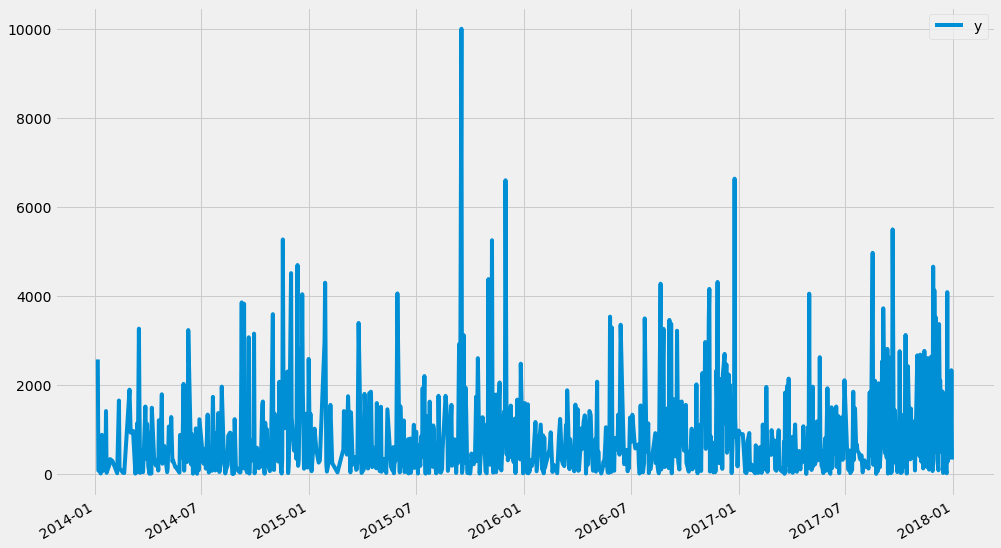

In [228]:
Sample_Superstore.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')

What is the time range we are dealing with?

In [229]:
min(df['ds']), max(df['ds'])

('2008-01-01', '2015-08-31')

With four complete cycles present, we can keep the last three months of 2017 as validation and use the rest of the data for training:

In [230]:
df_train = df.loc[df['ds'] < '2017-10-01']
df_valid = df.loc[df['ds'] >= '2017-10-01']
print(df_train.shape, df_valid.shape)

(2726, 2) (0, 2)


Next step is specifying the form of our model - we can combine this step with hyperparameter tuning. In order to keep the running time of this notebook within reasonable limits, the possible parameter ranges to a bare minimum needed to demonstrate the functionality (in a real application the only real limit is your patience).

In [231]:
param_grid = {  
    # tuning those parameters can potentially improve the performance of our model
    'changepoint_prior_scale': [0.001, 0.1],
#    'seasonality_prior_scale': [0.01, 1.0],
#    'holidays_prior_scale': [0.01, 0.1],
    'seasonality_mode': ['additive', 'multiplicative'],
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
# Quick peek at what our combinations look like
all_params

[{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}]

In [232]:
for params in all_params:
    m = Prophet(**params).fit(df)
    df_cv = cross_validation(m, initial='100 days', period='30 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
best_params = all_params[np.argmin(rmses)]
print(best_params)

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.0441
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       8359.68   2.59369e-05       2886.51   6.677e-09       0.001      170  LS failed, Hessian reset 
      99       8359.72   7.67862e-07        2921.4           1           1      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       8359.72   1.79168e-06       2625.03   4.609e-10       0.001      242  LS failed, Hessian reset 
     125       8359.72   6.39076e-09       3496.69     0.04046      0.4483      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Making 89 forecasts with cutoffs between 2008-05-09 00:00:00 and 2015-08-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fabf3d07d30>
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -2.43356


DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       177.248   1.28103e-05       5046.21   2.515e-09       0.001      109  LS failed, Hessian reset 
      75       177.394    7.3514e-06       5072.79   1.461e-09       0.001      173  LS failed, Hessian reset 
      99       177.439   1.90339e-06          4986      0.3036           1      205   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       177.456   1.23529e-06       4946.69   2.439e-10       0.001      256  LS failed, Hessian reset 
     135       177.485    1.2244e-06       5085.27   2.381e-10       0.001      346  LS failed, Hessian reset 
     169       177.511   7.36315e-07       5191.58   1.482e-10       0.001      431  LS failed, Hessian reset 
     188       177.515   4.95498e-09       4878.29      0.2055           1      455   
Optimization terminated normally: 
  Convergence detected: absolute parameter change wa

DEBUG:fbprophet:Loaded stan backend: PYSTAN



Initial log joint probability = -78.04
Iteration  1. Log joint probability =    139.096. Improved by 217.136.
Initial log joint probability = -3.29703
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.29703             0       186.305       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -104.221


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration  2. Log joint probability =    218.367. Improved by 79.2705.
Iteration  1. Log joint probability =    119.629. Improved by 223.85.
Iteration  3. Log joint probability =     309.62. Improved by 91.2535.
Initial log joint probability = -2.94799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration  4. Log joint probability =     402.87. Improved by 93.2496.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration  2. Log joint probability =    336.396. Improved by 216.767.
      99       393.221   8.21658e-07       5047.84           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       393.241    3.8137e-06       5030.72   7.522e-10       0.001      174  LS failed, Hessian reset 
     131       393.261    2.9912e-07       4995.87    5.95e-11       0.001      255  LS failed, Hessian reset 
Iteration  5. Log joint probability =    479.687. Improved by 76.8169.
     148       393.262    6.4429e-09        5010.4     0.08213     0.08213      278   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint probability =    475.809. Improved by 139.413.
Initial log joint probability = -3.48742
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.48742             0       226.637       1e-1

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration  5. Log joint probability =    540.503. Improved by 30.3476.
      79       584.051   7.88403e-09       4947.72      0.2995      0.2995       98   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  8. Log joint probability =    543.004. Improved by 0.105098.
Iteration  6. Log joint probability =    553.218. Improved by 12.7148.
Iteration  2. Log joint probability =    372.137. Improved by 133.723.
Initial log joint probability = -4.67622
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  9. Log joint probability =     543.15. Improved by 0.146007.
       1      -4.67622             0       284.772       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -196.575
Iteration  7. Log joint probability =    563.059. Improved by 9.8414

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration  1. Log joint probability =    280.789. Improved by 477.364.
Iteration  4. Log joint probability =    673.492. Improved by 114.314.
      82       934.551   3.01097e-09       4505.16      0.3156      0.3156      109   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 12. Log joint probability =    545.346. Improved by 1.67104.
Iteration  9. Log joint probability =    563.362. Improved by 0.0863527.
Iteration  5. Log joint probability =    679.995. Improved by 6.50281.
Iteration  2. Log joint probability =    399.276. Improved by 118.486.
Iteration 13. Log joint probability =    546.066. Improved by 0.72068.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 10. Log joint probability =    563.412. Improved by 0.0494795.
Iteration  6. Log joint probability =    682.411. Improved by 2.41611.
Iteration 14. Log joint probability =    546.421. Improved by 0.354998.
Initial log joint probability = -3.87844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    548.144. Improved by 148.868.
Iteration  7. Log joint probability =    683.753. Improved by 1.34191.
Iteration 11. Log joint probability =    563.476. Improved by 0.0637833.
Iteration 15. Log joint probability =    546.582. Improved by 0.161038.
      73       983.904   5.50237e-09       5057.31      0.3514      0.3514       89   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.20025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration  4. Log joint probability =    654.712. Improved by 106.568.
Iteration  8. Log joint probability =      692.7. Improved by 8.94681.
Iteration 12. Log joint probability =    563.511. Improved by 0.0348957.
      99       1073.04   1.39754e-05       5072.78           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 16. Log joint probability =    546.673. Improved by 0.09064.
Iteration  5. Log joint probability =    798.435. Improved by 143.723.
Iteration  9. Log joint probability =    692.702. Improved by 0.00234654.
Iteration 13. Log joint probability =     563.52. Improved by 0.00949199.
     199        1077.7   0.000159095       5118.93           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.21609
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iter

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 18. Log joint probability =    546.715. Improved by 0.018223.
Iteration 15. Log joint probability =    563.539. Improved by 0.00365528.
      85       1189.01   0.000100414       4791.74   2.065e-08       0.001      139  LS failed, Hessian reset 
      99       1189.55   2.70432e-06       4810.35      0.2714           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 11. Log joint probability =    693.304. Improved by 0.0302581.
Initial log joint probability = -3.85976
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       1189.57    8.6963e-09       4759.73      0.1659      0.1659      173   
Iteration  7. Log joint probability =    831.866. Improved by 27.0798.
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 16. Log joint probability =    563.548. Improved by 0.00929349.
Iteration 19. Log joi

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 12. Log joint probability =    693.322. Improved by 0.0184017.
Iteration  8. Log joint probability =    845.342. Improved by 13.476.
      99       1269.34   1.96544e-06       5263.69      0.1249      0.1249      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 17. Log joint probability =    563.553. Improved by 0.00493417.
Iteration 20. Log joint probability =    546.744. Improved by 0.0178929.
Initial log joint probability = -3.56324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 13. Log joint probability =    693.328. Improved by 0.00603514.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration  9. Log joint probability =    854.838. Improved by 9.49553.
Iteration 18. Log joint probability =    563.556. Improved by 0.00263679.
Iteration 21. Log joint probability =    546.755. Improved by 0.0111561.
     199       1272.13   5.21831e-05       3938.15           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 14. Log joint probability =    693.331. Improved by 0.00261014.
Initial log joint probability = -3.50699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99        1342.7   4.13759e-06        4179.4      0.5125      0.5125      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251        1273.5   9.89406e-09       4779.89      0.4745      0.4745      303   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 10. Log joint probability =     856.91. Improved by 2.07219.
Iteration 22. Log joint probability =    546.772. Improved by 0.0175675.
Initial log joint probability = -4.12454
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 15. Log joint probability =    693.335. Improved by 0.00429805.
Iteration 19. Log joint probability =    563.557. Improved by 0.000952113.
     110       1343.56   0.000120442       3963.37     2.1e-08       0.001      198  LS failed, Hessian reset 
Initial log joint probability = -4.39789


DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 11. Log joint probability =    860.792. Improved by 3.88169.
Iteration 23. Log joint probability =    546.783. Improved by 0.0109847.
Iteration 16. Log joint probability =    693.338. Improved by 0.00258606.
      95       1443.28   0.000255512       4392.56   4.891e-08       0.001      157  LS failed, Hessian reset 
      99       1443.84   2.00957e-05       4439.67      0.2516      0.2516      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 20. Log joint probability =    563.557. Improved by 0.000270019.
     199       1345.68   1.41184e-05       4353.02      0.6543      0.6543      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          1491   3.14578e-07       4676.74      0.4398      0.4398      120   
    Iter      log prob        ||dx||      ||grad||       al

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -3.76142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       1491.01     5.115e-09       4773.87      0.3483      0.3483      142   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     228       1345.74   8.39212e-09       4446.16      0.1977      0.1977      342   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 17. Log joint probability =    693.338. Improved by 0.000787024.
Iteration 12. Log joint probability =    861.356. Improved by 0.564637.
     126       1444.17   9.96264e-06       5291.07    1.77e-09       0.001      233  LS failed, Hessian reset 
Iteration 24. Log joint probability =    546.801. Improved by 0.0172467.
     129       1579.15   7.47691e-09       5086.95      0.5203      0.5203      166   
Optimization terminated normally: 
  Convergence detected: absolu

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 25. Log joint probability =    546.812. Improved by 0.010818.
Initial log joint probability = -3.85378
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 13. Log joint probability =    861.528. Improved by 0.171249.
      94       1657.51    0.00115683       5371.06   2.121e-07       0.001      169  LS failed, Hessian reset 
      99       1663.15   0.000386344       4895.36      0.8391      0.8391      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 22. Log joint probability =    563.558. Improved by 0.000222054.
Iteration 19. Log joint probability =    693.339. Improved by 2.41204e-05.
Iteration 26. Log joint probability =    546.828. Improved by 0.0169303.
Iteration 14. Log joint probability =    861.685. Improved by 0.157297.
Initial log joint probability = -4.95353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 20. Log joint probability =    693.339. Improved by 0.000292505.
     128       1740.89   9.50551e-09       3622.16      0.6022      0.6022      169   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 23. Log joint probability =    563.558. Improved by 0.000175129.
Iteration 27. Log joint probability =    546.839. Improved by 0.0106557.
     191        1667.9   2.16452e-05       5131.94   4.384e-09       0.001      348  LS failed, Hessian reset 
     199       1668.09   5.27221e-06       4963.47        0.53        0.53      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 15. Log joint probability =    861.797. Improved by 0.111901.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 21. Log joint probability =    693.339. Improved by 1.44385e-05.
Initial log joint probability = -4.22976
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 28. Log joint probability =    546.856. Improved by 0.0166183.
      99       1824.96    0.00120493        4851.2      0.1976           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 24. Log joint probability =    563.558. Improved by 0.000108502.
Iteration 16. Log joint probability =    861.807. Improved by 0.010297.
Iteration 22. Log joint probability =    693.339. Improved by 0.000156074.
     278       1669.79   2.57503e-06       5018.86   4.959e-10       0.001      501  LS failed, Hessian reset 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     299       1669.79   1.50985e-07        5009.2           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 29. Log joint probability =    546.866. Improved by 0.0104977.
     313       1669.79   9.35801e-09       3879.72      0.6593      0.6593      541   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 25. Log joint probability =    563.558. Improved by 0.000129198.
Iteration 23. Log joint probability =    693.339. Improved by 6.61354e-05.
Initial log joint probability = -5.31607
Iteration 17. Log joint probability =     861.89. Improved by 0.0828195.
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       1826.15    7.1932e-05        4651.7   1.387e-08       0.001      246  LS failed, Hessian reset 
      99       1909.06    0.00233979       5202.93      0.2162           1      128   
  

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 30. Log joint probability =    546.883. Improved by 0.0163107.
Iteration 24. Log joint probability =    693.339. Improved by 8.84558e-06.
Iteration 26. Log joint probability =    563.558. Improved by 6.31595e-05.
Initial log joint probability = -4.25095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1826.37   8.15381e-06       5263.09           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 18. Log joint probability =    861.931. Improved by 0.0407238.
     102       1909.98   0.000763781       5151.74   1.496e-07       0.001      186  LS failed, Hessian reset 
Iteration 31. Log joint probability =    546.893. Improved by 0.0103441.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     236       1826.51   8.81454e-09       4551.93      0.4914      0.4914      341   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 25. Log joint probability =    693.339. Improved by 3.72472e-05.
Iteration 27. Log joint probability =    563.558. Improved by 5.7395e-06.
Initial log joint probability = -4.87309
      99       2001.92   4.23339e-06       4676.96           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 19. Log joint probability =    861.944. Improved by 0.0137196.
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       1914.03   5.91423e-06       4874.52     1.2e-09       0.001      285  LS failed, Hessian reset 
Iteration 32. Log joint probability =    546.909. Improved by 0.0160073.
     190       1914.06   8.75859e-09       4939.56       0.593       0.593      329   
Opt

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 28. Log joint probability =    563.558. Improved by 3.56548e-05.
Iteration 26. Log joint probability =    693.339. Improved by 1.49849e-05.
Iteration 33. Log joint probability =    546.919. Improved by 0.0101947.
Iteration 20. Log joint probability =    861.954. Improved by 0.00932893.
Initial log joint probability = -4.3518
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       2080.71   8.98353e-09        4613.4      0.5786      0.5786      183   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     172       2004.15   5.73133e-06       4871.19   1.111e-09       0.001      259  LS failed, Hessian reset 
      99       2152.73   0.000235336       4957.56           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 29. Log joint probability =    563.558. Improved by 8.01282e-06.
Iteration 34. 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     195       2004.17   7.20831e-09       4315.79      0.1495      0.1495      286   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 27. Log joint probability =    693.339. Improved by 3.6427e-06.
Initial log joint probability = -4.33229
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 21. Log joint probability =    861.959. Improved by 0.0049917.
     102       2154.41   0.000291174       3911.97   5.014e-08       0.001      185  LS failed, Hessian reset 
Iteration 35. Log joint probability =    546.945. Improved by 0.0100596.
Iteration 30. Log joint probability =    563.558. Improved by 1.45584e-05.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99        2243.9   4.27754e-06        3917.2           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 28. Log joint probability =    693.339. Improved by 6.96624e-06.
Initial log joint probability = -5.90142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 36. Log joint probability =     546.96. Improved by 0.0153904.
Iteration 22. Log joint probability =     861.96. Improved by 0.00175437.
Iteration 31. Log joint probability =    563.558. Improved by 5.42916e-06.
Iteration 37. Log joint probability =     546.97. Improved by 0.00994267.
Initial log joint probability = -13.6842
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       2360.49   0.000152763       4828.36   2.931e-08       0.001      158  LS failed, Hessian reset 
      99       2360.91       1.5e-05       3958.07        0.48        0.4

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     114       2469.13   1.80607e-06       4956.86    3.59e-10       0.001      192  LS failed, Hessian reset 
Iteration 24. Log joint probability =    861.962. Improved by 0.00103586.
Iteration 34. Log joint probability =    563.558. Improved by 1.88247e-08.
Iteration 40. Log joint probability =     547.01. Improved by 0.014763.
Iteration 30. Log joint probability =    693.339. Improved by 2.9893e-06.
     234        2155.5   7.65104e-09       4522.36      0.3325      0.3325      404   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     135       2469.14    9.5074e-10       4657.69      0.1716      0.1716      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     111       2456.25   2.23092e-05       3604.02   4.527e-09       0.001      178  LS failed, Hessian reset 
      99       2515.68   2.69343e-05       5011.42           1           1      132   
    Iter    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 36. Log joint probability =    563.558. Improved by 2.33644e-08.
     159       2456.33   3.18399e-07       4789.29   6.258e-11       0.001      283  LS failed, Hessian reset 
Initial log joint probability = -4.82266
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       2456.33    6.8744e-09       3695.44       0.636       0.636      302   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 43. Log joint probability =    547.044. Improved by 0.0096154.
Iteration 32. Log joint probability =    693.339. Improved by 1.48181e-06.
Initial log joint probability = -5.35402
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 26. Log joint probability =    861.963. Improved by 0.000248885.
Iteration 37. Log joint probability =    563.558. Improved by 3.3099e-07.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 44. Log joint probability =    547.058. Improved by 0.0141509.
Iteration 33. Log joint probability =    693.339. Improved by 6.1955e-08.
Iteration 38. Log joint probability =    563.558. Improved by 2.7899e-08.
Iteration 45. Log joint probability =    547.067. Improved by 0.00951385.
     172       2515.92   4.32477e-07        4130.2   8.928e-11       0.001      305  LS failed, Hessian reset 
Initial log joint probability = -4.67455
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       2515.92   4.03142e-09       3109.22     0.06905           1      317   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 27. Log joint probability =    861.963. Improved by 9.79392e-05.
Iteration 34. Log joint probability =    693.339. Improved by 9.23971e-07.
Iteration 46. Log joint probability =    547.081. Improved by 0.0138504.
Iteration 39. Log joint probability =    563.5

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 73. Log joint probability =     547.36. Improved by 0.00844449.
Iteration 62. Log joint probability =    563.558. Improved by 8.23287e-08.
Iteration 74. Log joint probability =     547.37. Improved by 0.0099907.
Iteration 43. Log joint probability =    861.963. Improved by 1.29211e-07.
Iteration 63. Log joint probability =    563.558. Improved by 2.72015e-07.
Iteration 75. Log joint probability =    547.378. Improved by 0.00839077.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 76. Log joint probability =    547.388. Improved by 0.00973737.
Iteration 64. Log joint probability =    563.558. Improved by 8.68679e-08.
Iteration 44. Log joint probability =    861.963. Improved by 1.85404e-08.
Initial log joint probability = -8.16066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 77. Log joint probability =    547.396. Improved by 0.00833977.
Iteration 65. Log joint probability =    563.558. Improved by 2.67478e-07.
Iteration 78. Log joint probability =    547.406. Improved by 0.00948671.
Iteration 66. Log joint probability =    563.558. Improved by 9.14023e-08.
Iteration 79. Log joint probability =    547.414. Improved by 0.00829144.
Initial log joint probability = -5.08747
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 67. Log joint probability =    563.558. Improved by 2.62941e-07.
      99       2999.25   1.66226e-07        4848.6       0.484       0.484      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 80. Log joint probability =    547.423. Improved by 0.00923869.
Iteration 45. Log joint probability =    861.963. Improved by 6.05595e-08.
     116       2999.25   5.18091e-09       4902.08      0.3599      0.3599      151   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 81. Log joint probability =    547.432. Improved by 0.00824572.
Iteration 68. Log joint probability =    563.558. Improved by 9.59377e-08.
Iteration 82. Log joint probability =    547.441. Improved by 0.00899325.
Iteration 69. Log joint probability =    563.558. Improved by 2.58406e-07.
      99       3094.66   1.09324e-06       4513.98           1           1      140   


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -5.31549
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 46. Log joint probability =    861.963. Improved by 1.30997e-08.
Iteration 83. Log joint probability =    547.449. Improved by 0.00820257.
Iteration 70. Log joint probability =    563.558. Improved by 1.00472e-07.
Iteration 84. Log joint probability =    547.458. Improved by 0.00875034.
     122       3094.73   3.70226e-06       4966.63   7.422e-10       0.001      213  LS failed, Hessian reset 
Iteration 47. Log joint probability =    861.963. Improved by 3.53278e-08.
Iteration 71. Log joint probability =    563.558. Improved by 2.53872e-07.
Iteration 85. Log joint probability =    547.466. Improved by 0.00816194.
Initial log joint probability = -5.59701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151 

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 72. Log joint probability =    563.558. Improved by 1.05006e-07.
Iteration 86. Log joint probability =    547.474. Improved by 0.00850992.
Iteration 48. Log joint probability =    861.963. Improved by 1.65925e-08.
Iteration 87. Log joint probability =    547.482. Improved by 0.00812378.
Iteration 73. Log joint probability =    563.558. Improved by 2.49331e-07.
      99       3179.27   5.32286e-06       5198.62      0.5584      0.5584      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 88. Log joint probability =    547.491. Improved by 0.00827193.
Iteration 49. Log joint probability =    861.963. Improved by 9.26752e-09.
Iteration 74. Log joint probability =    563.558. Improved by 1.0955e-07.
Initial log joint probability = -7.00509
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 91. Log joint probability =    547.515. Improved by 0.00805468.
Initial log joint probability = -5.71325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 77. Log joint probability =    563.558. Improved by 2.4026e-07.
      99          3364   4.40981e-06       4947.29      0.2899           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 92. Log joint probability =    547.523. Improved by 0.00780308.
Iteration 78. Log joint probability =    563.558. Improved by 1.1862e-07.
Initial log joint probability = -5.81736
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 93. Log joint probability =    547.531. Improved by 0.00802365.
Initial log joint probability = -6.05152
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       3371.71    0.00100977       3290.95   2.338e-07       0.001      196  LS failed, Hessian reset 
Iteration 79. Log joint probability =    563.558. Improved by 2.3572e-07.
Initial log joint probability = -6.54802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 94. Log joint probability =    547.538. Improved by 0.00757214.
Initial log joint probability = -8.49754
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 80. Log joint probability =    563.558. Improved by 1.23151e-07.
Iteration 95. Log joint probability =    547.546. Improved by 0.00799491.
     135       3490.58   5.57348e-09       4717.62       0.363       0.363      171   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       3383.53   3.39136e-06       5249.04      0.6471      0.6471      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.35907
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 96. Log joint probability =    547.554. Improved by 0.00734345.
Iteration 81. Log joint probability =    563.558. Improved by 2.31187e-07.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     227       3383.54   9.86057e-09       5014.79           1           1      320   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       3771.24    1.1297e-05       4471.55           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 97. Log joint probability =    547.561. Improved by 0.00796842.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 82. Log joint probability =    563.558. Improved by 1.2769e-07.
      96       3593.14   6.44771e-06          5042   1.267e-09       0.001      179  LS failed, Hessian reset 
      99       3593.15   3.20011e-06        5089.4           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.75892
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 98. Log joint probability =    547.569. Improved by 0.00711686.
Iteration 83. Log joint probability =    563.558. Improved by 2.26651e-07.
     124       3593.18   9.44886e-09       4927.51      0.5608      0.5608      216   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.83678
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 99. Log joint proba

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     161       3771.67   3.10143e-06       5080.54   6.139e-10       0.001      257  LS failed, Hessian reset 
Iteration 85. Log joint probability =    563.558. Improved by 2.22112e-07.
      99        3688.8   3.62997e-06       4511.47      0.3814      0.3814      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 101. Log joint probability =    547.591. Improved by 0.00795094.
     182       3771.68   7.21504e-09       3932.87     0.05866           1      284   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       4078.29   2.23536e-06       4971.17      0.3657      0.3657      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138        3877.5   1.34707e-06       4541.56   3.028e-10       0.001      260  LS failed, Hessian reset 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 86. Log joint probability =    563.558. Improved by 1.36762e-07.
Iteration 102. Log joint probability =    547.598. Improved by 0.00662721.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     145       3951.94   3.80151e-05        4951.8   8.339e-09       0.001      235  LS failed, Hessian reset 
      99       4162.24     9.552e-06       3455.01           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       3877.51   6.13748e-09       3889.92      0.1972      0.1972      299   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 87. Log joint probability =    563.558. Improved by 2.17575e-07.
Iteration 103. Log joint probability =    547.606. Improved by 0.00795967.
      99       4201.61   8.35287e-06       5282.78           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.20163
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.91253
    Iter      l

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     120       4201.75    1.0729e-05       4052.23   2.265e-09       0.001      193  LS failed, Hessian reset 
Iteration 89. Log joint probability =    563.558. Improved by 2.13039e-07.
     185        3952.1   4.00006e-06       4807.98     6.6e-10       0.001      334  LS failed, Hessian reset 
     199       3952.11   2.19545e-07       4581.65           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       4164.74   0.000357737       4512.56   7.491e-08       0.001      222  LS failed, Hessian reset 
     209       3952.11    3.9241e-09       3779.96      0.1844      0.1844      363   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 106. Log joint probability =    547.626. Improved by 0.00613167.
Iteration 90. Log joint probability =    563.558. Improved by 1.45833e-07.
Iteration 107. Log joint probability =    547.634. Improved by 0.007983

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     172        4165.9   4.55122e-05       4793.07    9.63e-09       0.001      295  LS failed, Hessian reset 
Iteration 108. Log joint probability =     547.64. Improved by 0.00588695.
Initial log joint probability = -9.69734
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 92. Log joint probability =    563.558. Improved by 1.50368e-07.
      99       4296.38   1.46186e-05       4461.65           1           1      140   
      90       4488.42   0.000360841       2507.63   6.879e-08       0.001      158  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4580.91   6.69986e-06       4776.61      0.2541           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4166.01   1.28942e-06       4904.57       1.391      0.3163      331   
    Iter      log prob        ||dx||      ||grad||

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     142       4297.73   5.53647e-05       3870.56   1.196e-08       0.001      248  LS failed, Hessian reset 
Iteration 112. Log joint probability =    547.667. Improved by 0.00540339.
Iteration 95. Log joint probability =    563.558. Improved by 1.99429e-07.
Iteration 96. Log joint probability =    563.558. Improved by 1.5944e-07.
      99       4677.05   1.19749e-05       5229.21      0.3623           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4489.94   7.74643e-07       3935.58      0.8305      0.8305      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 113. Log joint probability =    547.675. Improved by 0.00803384.
     141       4581.38   3.21508e-05       4052.25   7.407e-09       0.001      218  LS failed, Hessian reset 
     286       4166.67   5.15598e-06       4599.74   9.799e-10       0.001      495  LS failed, Hessian reset 
     199  

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     299       4166.68   1.08473e-07       3554.45           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 114. Log joint probability =    547.681. Improved by 0.00516449.
Iteration 97. Log joint probability =    563.558. Improved by 1.94894e-07.
      99       4877.88   0.000216509       3976.17           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.41494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       4297.97   8.19716e-06       5228.44   1.606e-09       0.001      358  LS failed, Hessian reset 
     199       4297.99   2.72877e-06       3126.72           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 115. Log joint probability =    547.689. Improved by 0.0080

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     221          4298   4.25275e-09       4586.75      0.1246      0.1246      390   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 116. Log joint probability =    547.694. Improved by 0.00494749.
     139       4678.09    0.00015729       3711.46   3.569e-08       0.001      230  LS failed, Hessian reset 
Iteration 99. Log joint probability =    563.558. Improved by 1.90357e-07.
Initial log joint probability = -7.3896
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 117. Log joint probability =    547.702. Improved by 0.0080356.
     131       4878.29   2.71204e-05       3569.79   6.099e-09       0.001      217  LS failed, Hessian reset 
     299       4491.04   1.50578e-08       4015.07      0.6488      0.6488      416   
     251       4377.41   1.59626e-07       4339.71   2.699e-11       0.001      402  LS failed, Hessian reset 
     196       4581.51   5.53685e-07       5027.77   1.165e-10       0.001      325  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4581.51   1.18852e-07       2772.75      0.9024      0.9024      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       4377.41   8.74504e-09       3620.34      0.4097      0.4097      409   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     204       4581.51   4.15414e-09       

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     313       4491.04   8.18692e-07       4324.93   1.874e-10       0.001      480  LS failed, Hessian reset 
      99       4978.96   8.35863e-05       3017.39           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 120. Log joint probability =    547.719. Improved by 0.00456469.
Iteration 102. Log joint probability =    563.558. Improved by 1.73051e-07.
     334       4491.05   3.74224e-09       3892.14      0.2868      0.2868      508   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.31161
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 121. Log joint probability =    547.727. Improved by 0.00800038.
Iteration 103. Log joint probability =    563.558. Improved by 1.81279e-07.
     183       4785.62     1.586e-06       4395.17   3.096e-10       0.001      324

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 126. Log joint probability =    547.755. Improved by 0.00400368.
Initial log joint probability = -7.22435
Iteration 105. Log joint probability =    563.558. Improved by 1.76747e-07.
      99       5376.74    0.00194602        4619.2           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 127. Log joint probability =    547.763. Improved by 0.00796071.
     310       4678.78   3.58205e-07        4226.4   8.692e-11       0.001      529  LS failed, Hessian reset 
     317       4678.78   8.39128e-10       3256.35     0.09271     0.09271      539   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 128. Log joint probability =    547.767. Improved by 0.00382008.
Iteration 106. Log joint probability =    563.558. Improved by 1.82123e-07.
     142        5267.9    7.4314e-05       4465.17   1.723e-08       0.001      227  LS failed, Hessian reset 
     282       4980.44    3.0591e-09       4122.59     0.08791     0.08791      387   
Iteration 129. Log joint probability =    547.775. Improved by 0.00795086.
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.4865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       5079.56   3.78558e-06       4260.32   8.887e-10       0.001      265  LS failed, Hessian reset 
Iteration 130. Log joint probability =    547.779. Improved by 0.00363811.
     199       5187.12   1.67084e-06       3008.23    0.007234           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 152. Log joint probability =    547.895. Improved by 0.00173698.
Iteration 123. Log joint probability =    563.558. Improved by 1.35919e-07.


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 153. Log joint probability =    547.902. Improved by 0.0079526.
     274       5684.01   5.23428e-07       4209.23   9.766e-11       0.001      433  LS failed, Hessian reset 
Iteration 124. Log joint probability =    563.558. Improved by 2.22942e-07.
Iteration 154. Log joint probability =    547.904. Improved by 0.0015726.
Initial log joint probability = -8.65177
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 125. Log joint probability =    563.558. Improved by 1.31381e-07.
     299       5684.01   5.52636e-09       4036.76      0.6064      0.6064      465   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.1248
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 126. Log joint probability =    563.558. Improved by 2.2748e-07.
Iteration 155. Log joint probability =    547.912. Improved by 0.00796192.
Initial log joint probability = -8.46349
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 127. Log joint probability =    563.558. Improved by 1.26843e-07.
Iteration 156. Log joint probability =    547.913. Improved by 0.00140951.
Iteration 128. Log joint probability =    563.558. Improved by 2.32019e-07.
Iteration 157. Log joint probability =    547.921. Improved by 0.00797254.
Iteration 129. Log joint probability =    563.558. Improved by 1.22305e-07.
Iteration 158. Log joint probability =    547.923. Improved by 0.0012477.
      99       5776.51   5.76551e-07       4349.04     0.05148           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.0558
    Iter      log prob        ||dx||      ||g

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 133. Log joint probability =    563.558. Improved by 1.13234e-07.
Iteration 163. Log joint probability =    547.949. Improved by 0.00801195.
Iteration 134. Log joint probability =    563.558. Improved by 2.45627e-07.
     124       5887.19   0.000105655       4464.68   2.573e-08       0.001      195  LS failed, Hessian reset 
Iteration 164. Log joint probability =    547.949. Improved by 0.00076971.
      99       6111.39    6.0822e-06       4156.03      0.5076      0.5076      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 165. Log joint probability =    547.957. Improved by 0.00802753.
Iteration 135. Log joint probability =    563.558. Improved by 1.08692e-07.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199        5977.7    0.00198159        4273.5      0.4377           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5778.03   4.51475e-06       3450.14       0.366       0.366      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 166. Log joint probability =    547.958. Improved by 0.000612786.
Iteration 136. Log joint probability =    563.558. Improved by 2.50163e-07.


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -10.2704
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 167. Log joint probability =    547.966. Improved by 0.00804429.
     176       5887.39   2.78429e-09       4281.41     0.06316     0.06316      263   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 137. Log joint probability =    563.558. Improved by 1.04162e-07.
     201       5977.95   0.000174677       5524.26   4.715e-08       0.001      308  LS failed, Hessian reset 
     209       5778.53   0.000121503       3363.87   3.372e-08       0.001      329  LS failed, Hessian reset 
Iteration 168. Log joint probability =    547.967. Improved by 0.00045703.
Iteration 138. Log joint probability =    563.558. Improved by 2.54697e-07.
Initial log joint probability = -15.3043
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       611

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 140. Log joint probability =    563.558. Improved by 2.59234e-07.
Iteration 171. Log joint probability =    547.983. Improved by 0.00802421.
Initial log joint probability = -10.6342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -9.28379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.2423
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 141. Log joint probability =    563.558. Improved by 9.50864e-08.
     199       6115.73   6.31587e-06       3453.12      0.4226      0.4226      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 172. Log joint probability =    547.983. Improved by 0.000230854.
Iteration 142. Log joint probability =    563.558. Improved by 2.63771e-07.
Iteration 173. Log joint probability =    547.991. Improved by 0.00799475.
Initial log joint probability = -14.0572
Initial log joint probability = -9.5873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     279       5779.22   5.96738e-06       3080.64   1.397e-09       0.001      466  LS failed, Hessian reset 
Iteration 174. Log joint probability =    547.991. Improved by 0.000128138.
Iteration 143. Log joint probability =    563.558. Improved by 9.05496e-08.
      99       6208.81   4.01221e-05       2893.99           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.5819
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5779.23   3.32343e-08       2947.05      0.8807      0.8807      497   
Iteration 175. Log joint probability =    547.999. Improved by 0.0079664.
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       5779.23   9.29464e-09       2498.01      0.4477      0.4477      498   
Optimization terminated normally: 
  Convergence detected: absolute parameter change 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 183. Log joint probability =    548.042. Improved by 0.000509239.
      80       6934.44   0.000194456       3280.38    5.74e-08       0.001      150  LS failed, Hessian reset 
      99       6828.02   2.59512e-06       2786.75           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6047.67    2.8605e-05       2365.82      0.5631      0.5631      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140        6210.2   6.69862e-05       3493.93   1.745e-08       0.001      242  LS failed, Hessian reset 
Iteration 151. Log joint probability =    563.558. Improved by 7.2402e-08.
Iteration 184. Log joint probability =    548.043. Improved by 0.00141919.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     151       6526.66   1.71111e-08       2431.28      0.3421      0.3421      260   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 185. Log joint probability =    548.044. Improved by 0.000528979.
Iteration 152. Log joint probability =    563.558. Improved by 2.8645e-07.
     123        6727.6   6.08845e-05       3549.13   1.349e-08       0.001      264  LS failed, Hessian reset 
      99       6934.65   2.87213e-06       1363.17      0.3329           1      189   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     302       6047.75   2.75232e-05       3438.13   1.128e-08       0.001      541  LS failed, Hessian reset 
Iteration 186. Log joint probability =    548.045. Improved by 0.00139168.
Iteration 153. Log joint probability =    563.558. Improved by 6.78669e-08.
     114       6828.51   8.40023e-05       2118.09   2.178e-08       0.001      240  LS failed, Hessian reset 
     107       6434.99   5.88031e-05       2564.23   1.592e-08       0.001      210  LS failed, Hessian reset 
Initial log joint probability = -11.2726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170        6289.6   6.70222e-06       4053.94   1.646e-09       0.001      348  LS failed, Hessian reset 
Initial log joint probability = -11.4242
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 187. Log joint probability =    548.046. Improved by 0.000548736.
Iteration 154. Log joint probability =    563.558. Improved by 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     179       6631.18   2.35945e-06       4429.11   7.715e-10       0.001      334  LS failed, Hessian reset 
Iteration 190. Log joint probability =    548.049. Improved by 0.00133672.
     193       6289.71   1.52599e-05       4543.37   3.637e-09       0.001      418  LS failed, Hessian reset 
     199       6727.85   1.03141e-06       3041.63      0.7235      0.7235      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6289.73   1.52854e-06       4149.04      0.4325      0.4325      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 191. Log joint probability =     548.05. Improved by 0.000588297.
     194       6631.18   5.81204e-09       2865.78      0.4193      0.4193      359   
Optimization terminated normally: 
  Convergence d

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 196. Log joint probability =    548.055. Improved by 0.00125439.
     199        6934.8   1.26334e-06       3138.96           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7130.7   6.47146e-05       3170.16      0.4126           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     426       6048.31   9.80327e-09       3902.97      0.2682      0.2682      759   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 157. Log joint probability =    563.558. Improved by 5.87934e-08.
     244        6734.1   0.000539911       4735.52   1.278e-07       0.001      479  LS failed, Hessian reset 
      91       7038.97    3.7287e-05          4555   1.254e-08       0.001      172  LS failed, Hessian reset 
      99       7330.51   1.89355e-06       3322.04           1           1   

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 158. Log joint probability =    563.558. Improved by 3.00058e-07.
      99       7039.02   6.60735e-07       3330.16      0.3452      0.3452      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 198. Log joint probability =    548.057. Improved by 0.00122698.
Iteration 159. Log joint probability =    563.558. Improved by 5.42552e-08.
      99       7529.91   0.000263871       4017.84           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 199. Log joint probability =    548.057. Improved by 0.000667611.
      99       7425.18   2.27818e-05       3721.33          10           1      149   
Initial log joint probability = -11.2502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 160. Log joint pr

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     119       7131.08    3.9715e-05       2948.98   9.689e-09       0.001      214  LS failed, Hessian reset 
Iteration 161. Log joint probability =    563.558. Improved by 4.97183e-08.
     299       6736.38   0.000101507       4521.05        0.39           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 201. Log joint probability =    548.059. Improved by 0.000687479.
     112       7039.02   3.45865e-07       3172.64   1.261e-10       0.001      249  LS failed, Hessian reset 
Iteration 162. Log joint probability =    563.558. Improved by 3.0913e-07.
Initial log joint probability = -11.4551
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7229.45    7.9055e-07        2142.6   3.158e-10       0.001      203  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 202. Log joint probability

DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       7687.79   0.000106889       3382.21           1           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 170. Log joint probability =    563.558. Improved by 3.30121e-07.
     336       6437.56   5.45611e-07       2917.73   2.251e-10       0.001      691  LS failed, Hessian reset 
Iteration 209. Log joint probability =    548.067. Improved by 0.000798823.
      99       7782.32   8.12322e-05       2819.87           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       6437.56   5.61578e-09       3249.23      0.1019      0.1019      701   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 210. Log joint probability =    548.068. Improved by 0.0010264.
Iteration 171. Log joint probability =    563.558. Improved by 2.33073e-08.
     297        6830.3   0.000171606 

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 172. Log joint probability =    563.558. Improved by 3.36423e-07.
Initial log joint probability = -19.4669
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 212. Log joint probability =    548.069. Improved by 0.000989653.
     330       6935.45   6.12569e-07       2265.72   1.874e-10       0.001      656  LS failed, Hessian reset 
     199       7426.52   9.83131e-07       2645.62      0.3863      0.3863      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 173. Log joint probability =    563.558. Improved by 1.70053e-08.
     107       7782.58   6.62901e-05       2675.98   1.832e-08       0.001      198  LS failed, Hessian reset 
     273        7330.8   8.19725e-09       3199.75      0.2712      0.2712      434   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 213. Log joint probability =     548.07. Improved by 0.000857625.
      99       7879.85   2.75688e-07        2928.1        1.28      0.3317      194   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 89 forecasts with cutoffs between 2008-05-09 00:00:00 and 2015-08-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fabd7d1b790>


Initial log joint probability = -13.0441
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       8357.87   2.27291e-05          3000   6.084e-09       0.001      146  LS failed, Hessian reset 
      99       8357.91   1.23391e-07       2905.37      0.1698      0.1698      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       8358.03   1.34151e-05       2513.11    4.36e-09       0.001      277  LS failed, Hessian reset 
     198       8358.11   1.33801e-08       1540.14      0.4498      0.4498      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -2.43356


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80        197.71   5.23245e-09       4927.25      0.4764      0.4764      106   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -3.29703
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.29703             0       186.003       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


Initial log joint probability = -3.76544
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

Initial log joint probability = -104.221
       1      -3.76544             0       157.923       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  1. Log joint probability =    166.973. Improved by 271.194.
Initial log joint probability = -2.94799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN



Initial log joint probability = -78.04
Iteration  2. Log joint probability =    223.546. Improved by 56.5728.
      95       408.676   4.46944e-09       5011.09      0.2322      0.2322      123   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint probability =    398.534. Improved by 174.988.
Iteration  1. Log joint probability =    115.414. Improved by 193.454.


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration  4. Log joint probability =    404.147. Improved by 5.61286.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -3.48742
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.48742             0        226.38       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  2. Log joint probability =     229.23. Improved by 113.816.
Iteration  5. Log joint probability =    446.907. Improved by 42.7605.

Initial log joint probability = -142.088
Iteration  3. Log joint probability =    323.351. Improved by 94.1217.
Initial log joint probability = -3.197
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  6. Log joint probability =    471.929. Improved by 25.0217.
Iteration  1. Log joint probability =    204.815. Improved by 346.903.
Iteration  4. Log joint probability =    385.686. Improved by 62.3353.
      61       756.642   1.77772e-05       5048.49   3.562e-

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration  2. Log joint probability =    370.032. Improved by 165.216.
Iteration  5. Log joint probability =    394.557. Improved by 8.87013.
Iteration  8. Log joint probability =     557.21. Improved by 31.4552.
Iteration  9. Log joint probability =    560.207. Improved by 2.99704.
Iteration  3. Log joint probability =    441.777. Improved by 71.7452.
Iteration  6. Log joint probability =    452.363. Improved by 57.8061.
Iteration  1. Log joint probability =    247.142. Improved by 443.717.
Initial log joint probability = -3.54446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 10. Log joint probability =    561.505. Improved by 1.29836.
      88       933.363   4.31305e-09       5368.31       0.492       0.492      112   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  7. Log joint probability =     471.35. Improved by 18.9868.
Iteration  4. Log joint probability =    526.642. Improved by 84.8655.
Iteration  2. Log joint probability =    361.893. Improved by 114.751.
Iteration 11. Log joint probability =    561.981. Improved by 0.476014.
Iteration  8. Log joint probability =    501.895. Improved by 30.5451.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 12. Log joint probability =    562.062. Improved by 0.08093.
Iteration  5. Log joint probability =    614.594. Improved by 87.9519.
Iteration  3. Log joint probability =     619.05. Improved by 257.157.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -3.87844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  9. Log joint probability =    520.117. Improved by 18.2225.
Iteration 13. Log joint probability =     562.12. Improved by 0.058037.
Iteration  6. Log joint probability =    646.342. Improved by 31.7483.
Initial log joint probability = -3.20025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  4. Log joint probability =    778.725. Improved by 159.676.
      85       996.499   7.30406e-09       5141.96      0.4758      0.4758      106   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 14. Log joint probability =     562.19. Improved by 0.0691913.
Iteration 10. Log joint probability =    545.883. Improved by 25.766.
Iteration 11. Log joint probability =    546.822. Improved by 0.938611.
      99        1086.1      0.008396      

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -3.21609
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  8. Log joint probability =    673.138. Improved by 17.7438.
Iteration 17. Log joint probability =    562.349. Improved by 0.0476966.
Iteration 13. Log joint probability =    547.521. Improved by 0.142591.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration  9. Log joint probability =     689.23. Improved by 16.0924.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 18. Log joint probability =    562.403. Improved by 0.0535852.
Iteration  6. Log joint probability =    845.201. Improved by 2.87849.
Initial log joint probability = -3.85976
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 14. Log joint probability =    547.668. Improved by 0.146572.
      96       1192.19   7.74455e-09       4992.73      0.4798      0.4798      125   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 19. Log joint probability =    562.448. Improved by 0.0452881.
Iteration 10. Log joint probability =    691.729. Improved by 2.49835.
Initial log joint probability = -3.56324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 15. Log joint probability =    547.777. Improved by 0.109599.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 20. Log joint probability =    562.497. Improved by 0.0485324.
      99       1261.12   8.23715e-06        4888.8      0.4089           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 11. Log joint probability =    692.102. Improved by 0.37352.
Iteration  7. Log joint probability =    848.383. Improved by 3.18189.
      99       1350.66   1.46278e-05       4840.52           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       1261.15   8.67999e-09       4970.47      0.2285      0.7438      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 21. Log joint probability =    562.541. Improved by 0.0440688.
Iteration 16. Log joint probability =     547.83. Improved by 0.0531017.
Initial log joint probability = -3.50699
    Iter      log prob        ||dx||      ||grad

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 18. Log joint probability =    547.947. Improved by 0.0371954.
Iteration 24. Log joint probability =    562.671. Improved by 0.0421383.
Iteration 14. Log joint probability =    692.945. Improved by 0.022586.
Iteration 19. Log joint probability =    547.952. Improved by 0.00525444.
      99        1484.4     3.742e-06       4615.63      0.2214           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.39789
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 25. Log joint probability =    562.716. Improved by 0.0441305.
Iteration  9. Log joint probability =    858.918. Improved by 5.66156.
Iteration 15. Log joint probability =    693.106. Improved by 0.161524.
Iteration 20. Log joint probability =    547.956. Improved by 0.00390836.
     189       1485.35   9.09628e-09       5131.36      0.6957      0.6957      237   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 26. Log joint probability =    562.756. Improved by 0.0405965.
Iteration 16. Log joint probability =    693.184. Improved by 0.077453.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -3.76142
Iteration 21. Log joint probability =    547.961. Improved by 0.00512731.
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 27. Log joint probability =    562.802. Improved by 0.0454843.
      99       1569.86    0.00329433       5486.99      0.6369      0.6369      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 10. Log joint probability =    859.139. Improved by 0.220287.
Iteration 17. Log joint probability =    693.223. Improved by 0.0397083.
Iteration 28. Log joint probability =    562.843. Improved by 0.0408375.
Iteration 22. Log joint probability =    547.965. Improved by 0.00391293.
      99       1649.88   1.41749e-05       4735.49      0.2173           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     157       1572.13   9.49796e-09       4961.84      0.6109      0.6109      199   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 29. Log joint probability =    562.892. Improved by 0.0495768.
Iteration 18. Log joint probability =    693.237. Improved by 0.0132217.
Initial log joint probability = -3.85378
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 23. Log joint probability =     547.97. Improved by 0.00500072.
Iteration 30. Log joint probability =    562.941. Improved by 0.0491038.
Iteration 11. Log joint probability =    861.451. Improved by 2.31204.
Iteration 19. Log joint probability =    693.237. Improved by 0.000252436.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 24. Log joint probability =    547.974. Improved by 0.0039186.
Iteration 31. Log joint probability =    562.975. Improved by 0.0336422.
     199       1654.76   1.38798e-06       4819.67      0.2787           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.95353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 20. Log joint probability =    693.237. Improved by 8.18055e-05.
Iteration 25. Log joint probability =    547.979. Improved by 0.00485881.
Iteration 32. Log joint probability =        563. Improved by 0.0252976.
      99       1761.76   1.63467e-05        4617.4      0.4921      0.4921      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 12. Log joint probability =    861.598. Improved by 0.147286.
     226       1654.77   2.16676e-07       5049.38   4.282e-11       

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     235       1654.77   6.51312e-09       4969.27      0.5221      0.5221      329   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 21. Log joint probability =    693.237. Improved by 0.000242962.
Iteration 33. Log joint probability =     563.03. Improved by 0.0298438.
Iteration 26. Log joint probability =    547.983. Improved by 0.00395764.
     146       1761.97     7.939e-09       5496.41           1           1      180   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.22976
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1824.28   5.31417e-06       4754.18      0.7557      0.7557      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 34. Log joint probability =    563.052. Improved by 0.022306.
Iteration 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


t probability =    547.987. Improved by 0.00467126.
Initial log joint probability = -5.31607
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 13. Log joint probability =    861.617. Improved by 0.0188201.
     111       1824.35   6.29722e-06        4675.1   1.369e-09       0.001      172  LS failed, Hessian reset 
Iteration 35. Log joint probability =    563.078. Improved by 0.0254947.
Iteration 28. Log joint probability =    547.991. Improved by 0.00405668.
Iteration 23. Log joint probability =    693.237. Improved by 0.0002347.
Iteration 36. Log joint probability =    563.098. Improved by 0.0201427.
     160       1824.38   6.75081e-09        4397.1      0.2948      0.2948      234   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        1908.6   1.13643e-06       4965.56      0.2099      0.7706      125   
    Iter      log prob        ||dx||      ||grad||       al

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 37. Log joint probability =     563.12. Improved by 0.0218474.
     116       2001.78   9.58547e-09       5077.22      0.2153           1      152   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 14. Log joint probability =     861.65. Improved by 0.0332056.
Initial log joint probability = -4.25095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 30. Log joint probability =        548. Improved by 0.00418716.
Iteration 25. Log joint probability =    693.238. Improved by 0.000232053.
Iteration 38. Log joint probability =    563.138. Improved by 0.0185896.
Iteration 39. Log joint probability =    563.157. Improved by 0.0187129.
Iteration 26. Log joint probability =    693.238. Improved by 9.16318e-05.
Iteration 31. Log joint probability =    548.004. Improved by 0.00419081.
Initial log joint probability = -4.87309
    Iter      log prob        ||dx||      ||

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 27. Log joint probability =    693.238. Improved by 0.000229413.
      99       2075.62   5.01902e-08       4400.85      0.8917      0.8917      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       2075.62   6.02853e-09       4717.03      0.3473      0.3473      140   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 33. Log joint probability =    548.012. Improved by 0.00393918.
Iteration 41. Log joint probability =    563.191. Improved by 0.0159508.
Initial log joint probability = -4.3518
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 28. Log joint probability =    693.238. Improved by 9.19237e-05.
Iteration 16. Log joint probability =    861.679. Improved by 0.00840744.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 34. Log joint probability =    548.017. Improved by 0.0044634.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 42. Log joint probability =    563.207. Improved by 0.0167028.
Iteration 29. Log joint probability =    693.238. Improved by 0.000226779.
      96       2156.64   0.000330487       4195.81   6.445e-08       0.001      168  LS failed, Hessian reset 
      99       2156.99   2.05022e-05       3825.97      0.6053      0.6053      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 35. Log joint probability =    548.021. Improved by 0.00368801.
Initial log joint probability = -4.33229
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 17. Log joint probability =    861.682. Improved by 0.00313886.
Iteration 30. Log joint probability =    693.239. Improved by 9.22271e-05.
Iteration 43. Log joint probability =    563.221. Improved by 0.0134579.
Iteration 36. Log joint probability =    548.025. Improved by 0.00457404.
     144       2157.33   9.69686e-09       3942.64      0.2

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 18. Log joint probability =    861.685. Improved by 0.00304564.
Iteration 38. Log joint probability =    548.033. Improved by 0.00465081.
     111       2258.02    6.9767e-07       4275.25   1.411e-10       0.001      194  LS failed, Hessian reset 
Initial log joint probability = -13.6842
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       2258.02   9.00458e-09        4294.8      0.3345           1      220   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 39. Log joint probability =    548.037. Improved by 0.00331184.
      99       2361.12   7.03686e-07       4144.58      0.6908      0.6908      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 32. Log joint probability =    693.239. Improved by 9.25418e-05.
Iteration 45. Log joint probability =    563.248. Improved by 0.0111604.
     121       

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     118       2457.05   7.87308e-09       4651.46       0.466           1      146   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.70557
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 46. Log joint probability =    563.264. Improved by 0.0157935.
Iteration 33. Log joint probability =    693.239. Improved by 0.000221527.
Iteration 41. Log joint probability =    548.044. Improved by 0.00312566.
      99       2452.92   2.68321e-07       3474.37       0.923       0.923      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 42. Log joint probability =    548.049. Improved by 0.00480823.
Iteration 47. Log joint probability =    563.273. Improved by 0.00900629.
Iteration 20. Log joint probability =    861.688. Improved by 0.00157961.
     131       2452.92   9.43129e-09       3790.11  

DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       2495.38   0.000271793       4495.98           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 21. Log joint probability =    861.688. Improved by 0.000785985.
Iteration 35. Log joint probability =    693.239. Improved by 0.000218909.
Iteration 44. Log joint probability =    548.057. Improved by 0.0048883.
Iteration 49. Log joint probability =    563.295. Improved by 0.00696053.
Iteration 50. Log joint probability =    563.311. Improved by 0.0154271.
      99        2611.3   2.60692e-06       4063.88      0.2105      0.9508      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 45. Log joint probability =     548.06. Improved by 0.00275491.
Iteration 36. Log joint probability =    693.239. Improved by 9.32055e-05.
Initial log joint probability = -4.67455
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # eval

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 46. Log joint probability =    693.241. Improved by 9.50643e-05.
Iteration 64. Log joint probability =     548.13. Improved by 0.00573643.
Iteration 66. Log joint probability =    564.005. Improved by 0.00416201.
Iteration 33. Log joint probability =    861.691. Improved by 2.2653e-06.
Iteration 65. Log joint probability =    548.131. Improved by 0.000932256.
Iteration 47. Log joint probability =    693.241. Improved by 0.000203308.
Iteration 67. Log joint probability =    564.009. Improved by 0.00359317.
Iteration 66. Log joint probability =    548.137. Improved by 0.00582572.
Initial log joint probability = -8.16066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 34. Log joint probability =    861.691. Improved by 1.46551e-06.
Iteration 48. Log joint probability =    693.241. Improved by 9.54701e-05.
Iteration 68. Log joint probability =    564.011. Improved by 0.00226503.
Iteration 67. Log joint probability =    548.137

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 76. Log joint probability =    548.169. Improved by 0.00614523.
Iteration 55. Log joint probability =    693.242. Improved by 0.000193001.
Iteration 40. Log joint probability =    861.691. Improved by 1.28016e-06.
Iteration 77. Log joint probability =    548.169. Improved by 2.50946e-05.
Iteration 76. Log joint probability =    564.013. Improved by 3.90927e-05.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 56. Log joint probability =    693.242. Improved by 9.72057e-05.
Iteration 78. Log joint probability =    548.175. Improved by 0.00616944.
Initial log joint probability = -5.08747
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 77. Log joint probability =    564.013. Improved by 1.60257e-05.
Initial log joint probability = -5.31549
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 41. Log joint probability =    861.691. Improved by 2.51202e-06.
Iteration 57. Log joint probability =    693.243. Improved by 0.000190435.
Iteration 79. Log joint probability =    548.195. Improved by 0.0194397.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 78. Log joint probability =    564.013. Improved by 5.5926e-06.
Iteration 80. Log joint probability =    548.197. Improved by 0.0025085.
Iteration 42. Log joint probability =    861.691. Improved by 1.21838e-06.
Iteration 58. Log joint probability =    693.243. Improved by 9.76675e-05.
Iteration 79. Log joint probability =    564.013. Improved by 1.1513e-06.
Iteration 81. Log joint probability =    548.198. Improved by 0.000553598.
Initial log joint probability = -5.59701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3084.11   5.00369e-07        4757.2      0.3515           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.00509
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 80. Log joint probability =    564.013. Improved by 4.66529e-06.
Iteration 59. Log joint probabilit

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 44. Log joint probability =    861.691. Improved by 1.15659e-06.
Iteration 84. Log joint probability =    548.203. Improved by 0.00240863.
Iteration 82. Log joint probability =    564.013. Improved by 1.06346e-06.
      99       3279.45     0.0011285       5256.88       0.192      0.2668      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 61. Log joint probability =    693.243. Improved by 0.000185316.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 85. Log joint probability =    548.204. Improved by 0.00061293.
Iteration 83. Log joint probability =    564.013. Improved by 5.34331e-07.
Iteration 45. Log joint probability =    861.691. Improved by 2.63539e-06.
     101       3279.67   0.000252501       4975.09   4.665e-08       0.001      189  LS failed, Hessian reset 
Iteration 86. Log joint probability =    548.206. Improved by 0.00235879.
Iteration 62. Log joint probability =    693.243. Improved by 9.86244e-05.
Iteration 84. Log joint probability =    564.013. Improved by 6.97598e-08.
Initial log joint probability = -5.71325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96        3376.5   0.000964498       4714.79   1.597e-07       0.001      179  LS failed, Hessian reset 
      99       3378.17   0.000106273       4279.55      0.3643      0.3643      183   


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 87. Log joint probability =    548.207. Improved by 0.000642718.
Iteration 46. Log joint probability =    861.691. Improved by 1.07545e-06.
     147       3281.15   7.92003e-09       4819.13      0.4343      0.4343      242   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 63. Log joint probability =    693.244. Improved by 0.000182762.
Iteration 85. Log joint probability =    564.013. Improved by 2.92959e-07.
Iteration 88. Log joint probability =    548.209. Improved by 0.002309.
Initial log joint probability = -5.81736
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 64. Log joint probability =    693.244. Improved by 9.91194e-05.
Iteration 47. Log joint probability =    861.691. Improved by 2.73573e-06.
Iteration 86. Log joint probability =    564.013. Improved by

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -8.49754
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       3382.43   5.53453e-09       5097.54      0.2451      0.2451      357   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 66. Log joint probability =    693.244. Improved by 9.96254e-05.
Iteration 92. Log joint probability =    548.215. Improved by 0.00220961.
Iteration 88. Log joint probability =    564.013. Improved by 8.2662e-08.
Iteration 49. Log joint probability =    861.691. Improved by 2.85814e-06.
     138        3483.7   6.73539e-05       5348.76   1.266e-08       0.001      224  LS failed, Hessian reset 
Iteration 93. Log joint probability =    548.216. Improved by 0.000732556.
Iteration 67. Log joint probability =    693.244. Improved by 0.000177667.
      99       3585.02   6.63695e-08       4719.65      0.2734      0.9765      131   
    Iter      log prob       

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 97. Log joint probability =    548.221. Improved by 0.000810044.
Iteration 52. Log joint probability =    861.691. Improved by 7.18982e-07.
Iteration 70. Log joint probability =    693.244. Improved by 0.00010067.
      99       3867.12    6.8934e-07       4718.19       0.313           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 98. Log joint probability =    548.224. Improved by 0.0020394.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     141       3680.88   0.000347697       5152.71   6.845e-08       0.001      245  LS failed, Hessian reset 
Iteration 71. Log joint probability =    693.245. Improved by 0.000172587.
Iteration 99. Log joint probability =    548.224. Improved by 0.000849002.
Iteration 53. Log joint probability =    861.691. Improved by 3.10294e-06.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     119       3867.17   3.81102e-06       5037.78   8.431e-10       0.001      194  LS failed, Hessian reset 
Iteration 100. Log joint probability =    548.226. Improved by 0.00198126.
Iteration 72. Log joint probability =    693.245. Improved by 0.000101209.
     199       3682.66   2.18303e-05        4737.4           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 54. Log joint probability =    861.691. Improved by 5.96497e-07.
Initial log joint probability = -7.75892


DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 101. Log joint probability =    548.227. Improved by 0.000888047.
     148       3867.18   7.00647e-09       4681.82      0.5028      0.5028      231   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 73. Log joint probability =    693.245. Improved by 0.000170052.
Iteration 102. Log joint probability =    548.229. Improved by 0.00192317.
Initial log joint probability = -6.83678
Iteration 55. Log joint probability =    861.691. Improved by 3.22534e-06.
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214        3683.8   7.55406e-05       4769.32   1.766e-08       0.001      389  LS failed, Hessian reset 
Iteration 74. Log joint probability =    693.245. Improved by 0.000101758.
Iteration 103. Log joint probability =     548.23. Improved by 0.000927179.
Initial log joint pr

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 105. Log joint probability =    548.233. Improved by 0.000966396.
Iteration 76. Log joint probability =    693.245. Improved by 0.000102318.
     111       4056.32    0.00130147       5219.94     2.4e-07       0.001      187  LS failed, Hessian reset 
Iteration 57. Log joint probability =    861.691. Improved by 3.34775e-06.
Iteration 106. Log joint probability =    548.235. Improved by 0.00180714.
     283       3684.33   2.63074e-06        4799.4   5.602e-10       0.001      507  LS failed, Hessian reset 
Iteration 77. Log joint probability =    693.245. Improved by 0.000164995.
     299       3684.35    9.9357e-08       4656.84      0.1965      0.9468      525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.91253
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 107. Log joint probability =    548.236. Improved by 0.0010057.
      84       4

DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       4166.06   1.65034e-05       5269.46      0.9615      0.9615      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4185.68     6.566e-06        3438.3      0.4822      0.4822      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 78. Log joint probability =    693.246. Improved by 0.000102889.
Iteration 108. Log joint probability =    548.237. Improved by 0.00174919.
      91       3968.89   5.50368e-05          4406   1.145e-08       0.001      173  LS failed, Hessian reset 
     178       4065.53   9.51821e-09       4982.99      0.4873      0.4873      275   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       3969.01   1.03533e-05       4545.93           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial lo

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -9.69734
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 109. Log joint probability =    548.239. Improved by 0.00104508.
Iteration 79. Log joint probability =    693.246. Improved by 0.000162471.
     114       4166.19   7.40885e-06       5023.26    1.51e-09       0.001      233  LS failed, Hessian reset 
Initial log joint probability = -8.20163
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 59. Log joint probability =    861.691. Improved by 3.47016e-06.
Iteration 110. Log joint probability =     548.24. Improved by 0.00169129.
Iteration 80. Log joint probability =    693.246. Improved by 0.00010347.
Iteration 60. Log joint probability =    861.691. Improved by 2.28968e-07.
     156       4188.08   0.000181052       5257.13   3.351e-08       0.001      243  LS failed, Hessian reset 
      99        4485.2   7.44011e-06       3267.61           1 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     144       4166.24   1.45174e-07       4943.52   2.978e-11       0.001      314  LS failed, Hessian reset 
     193        3969.1   6.32626e-09       4300.11      0.1539      0.1539      302   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     151       4166.24   3.31073e-09       4785.11      0.1056      0.1056      323   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      68       4386.19   0.000991569       4745.53   1.594e-07       0.001      125  LS failed, Hessian reset 
Iteration 81. Log joint probability =    693.246. Improved by 0.000159951.
Iteration 112. Log joint probability =    548.243. Improved by 0.00163344.
     199       4189.61   5.55771e-07        4994.8       0.559       0.559      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 61. Log joint probability =    861.691. Improved by 3.5

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 84. Log joint probability =    693.246. Improved by 0.000104665.
Iteration 63. Log joint probability =    861.691. Improved by 3.71496e-06.
Initial log joint probability = -7.96002
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 116. Log joint probability =    548.248. Improved by 0.00151787.
     147       4677.16   2.26408e-05       4433.03   4.831e-09       0.001      236  LS failed, Hessian reset 
Iteration 117. Log joint probability =     548.25. Improved by 0.00120344.
Iteration 85. Log joint probability =    693.246. Improved by 0.000154922.
     193        4567.7   1.58032e-07        3509.1   4.135e-11       0.001      325  LS failed, Hessian reset 
Iteration 64. Log joint probability =    861.691. Improved by 3.61986e-05.
     199        4567.7   4.97207e-08       3065.89           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202        

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     129       4750.94   4.28197e-05       4917.15   9.009e-09       0.001      205  LS failed, Hessian reset 
Iteration 118. Log joint probability =    548.251. Improved by 0.00146016.
Initial log joint probability = -7.0181
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 86. Log joint probability =    693.247. Improved by 0.000105278.
     199       4677.26   6.08683e-08       4485.03      0.7102      0.7102      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 119. Log joint probability =    548.252. Improved by 0.00124324.
Initial log joint probability = -7.3896
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 65. Log joint probability =    861.691. Improved by 6.51423e-06.
      99       4971.65   4.40198e-05       4075.85      0.4871      0.4871      143   


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 87. Log joint probability =    693.247. Improved by 0.000152412.
Iteration 120. Log joint probability =    548.254. Improved by 0.0014025.
Initial log joint probability = -7.85435
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4869.4   8.25749e-05       4978.25           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4751.3   5.25958e-05       2279.67      0.8696      0.8696      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 66. Log joint probability =    861.691. Improved by 2.00163e-05.
     221       4677.26   3.54174e-08       4929.27    7.54e-12       0.001      368  LS failed, Hessian reset 
Iteration 121. Log joint probability =    548.255. Improved by 0.00127414.
     22

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 137. Log joint probability =    548.276. Improved by 0.00128826.
     202       5465.47   0.000297525       5540.48   6.157e-08       0.001      332  LS failed, Hessian reset 
Iteration 99. Log joint probability =    693.248. Improved by 0.000137422.
     250       5578.91   9.19147e-09       3676.99     0.08797           1      358   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     258       5279.58   9.85648e-09       3750.08      0.3431      0.3431      439   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 76. Log joint probability =    861.691. Improved by 3.09465e-08.
Iteration 138. Log joint probability =    548.277. Improved by 0.00122214.
     394       4973.73   8.83519e-09       3746.41      0.1292      0.1292      671   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 100

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 106. Log joint probability =    693.249. Improved by 0.000111973.
Iteration 148. Log joint probability =    548.289. Improved by 0.00113606.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 149. Log joint probability =     548.29. Improved by 0.00129331.
Iteration 107. Log joint probability =    693.249. Improved by 0.00012749.
Iteration 150. Log joint probability =    548.292. Improved by 0.001119.
Iteration 108. Log joint probability =    693.249. Improved by 0.000112698.
Iteration 151. Log joint probability =    548.293. Improved by 0.00129437.
Iteration 152. Log joint probability =    548.294. Improved by 0.001102.
      99       5669.44   0.000277391       3459.76      0.6532      0.6532      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.46349
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 109. Log joint probability =    693.249. Improved by 0.000125014.
Initial log joint probability = -8.65177
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 153. Log joint probabi

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 112. Log joint probability =     693.25. Improved by 0.000114177.
Iteration 157. Log joint probability =      548.3. Improved by 0.00129791.
     199       5672.19   0.000200169       4676.39           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 113. Log joint probability =     693.25. Improved by 0.000120071.
Iteration 158. Log joint probability =    548.301. Improved by 0.0010513.
      88       5874.91   7.07164e-05       3720.42   1.869e-08       0.001      153  LS failed, Hessian reset 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       5875.02   1.04802e-05       4342.88      0.3241           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 159. Log joint probability =    548.302. Improved by 0.00129922.
Initial log joint probability = -10.1248
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       5672.51   3.30285e-05       3526.47   6.315e-09       0.001      310  LS failed, Hessian reset 
Iteration 114. Log joint probability =     693.25. Improved by 0.000114932.
      99       5751.29   0.000107666       3089.63      0.2123      0.2123      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 160. Log joint probability =    548.303. Improved by 0.0010345.
     129       5875.05   6.58573e-09       3529.87      0.1832      0.1832      206   
Optimization terminated normally: 


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


  Convergence detected: absolute parameter change was below tolerance
Iteration 115. Log joint probability =     693.25. Improved by 0.000117603.
Iteration 161. Log joint probability =    548.305. Improved by 0.00130058.
Initial log joint probability = -15.2912
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 162. Log joint probability =    548.306. Improved by 0.00101776.
Iteration 116. Log joint probability =     693.25. Improved by 0.000115696.


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 163. Log joint probability =    548.307. Improved by 0.001302.
Initial log joint probability = -10.0558
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 117. Log joint probability =     693.25. Improved by 0.000115139.
Iteration 164. Log joint probability =    548.308. Improved by 0.00100106.
     299       5673.69   7.58336e-08        4077.5      0.3638           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.3043
     157       5760.55   0.000206519       3475.15   5.063e-08       0.001      258  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 165. Log joint probability =    548.309. Improved by 0.00130348.
Iteration 118. Log joint probability =     693.25. Improved by 0.00011647.
Initial log joint probability = -10.2704
    Iter      log prob       

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     141       5974.63   5.81836e-05       3743.78   1.352e-08       0.001      236  LS failed, Hessian reset 
      76       6290.86   4.61543e-05        3210.5   1.583e-08       0.001      149  LS failed, Hessian reset 
Iteration 172. Log joint probability =    548.317. Improved by 0.000934793.
     255       5761.63   1.29072e-05       3708.85   2.489e-09       0.001      420  LS failed, Hessian reset 
Iteration 123. Log joint probability =    693.251. Improved by 0.00010776.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     150        6107.5   2.29071e-09       4000.13      0.2454      0.2454      209   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 173. Log joint probability =    548.318. Improved by 0.00130998.
     199       6035.61   1.54115e-06       2605.92           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6291.11   2.94992e-06       2925.62           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 174. Log joint probability =    548.319. Improved by 0.000918349.
     199        5974.8   6.87764e-06        4093.4           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       5761.65   7.37106e-09       3694.89      0.4014      0.4014      465   
Optimization terminated normally:

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 177. Log joint probability =    548.323. Improved by 0.00131357.
     100       6364.58   4.06441e-05       3488.26   1.236e-08       0.001      173  LS failed, Hessian reset 
Iteration 126. Log joint probability =    693.251. Improved by 0.00011966.
      87       6434.64   0.000342785       3629.06   8.646e-08       0.001      167  LS failed, Hessian reset 
Iteration 178. Log joint probability =    548.324. Improved by 0.000885611.
Initial log joint probability = -10.2423
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6434.98   1.33201e-05       3236.37      0.4804           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155        6291.3   1.88515e-05       3043.85   5.271e-09       0.001      299  LS failed, Hessian reset 
Iteration 179. Log joint probability =    548.325. Improved by 0.00131545.
Iteration 127. Log joint probability =    693.252. Imp

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -10.5819
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 129. Log joint probability =    693.252. Improved by 0.000100405.
Iteration 182. Log joint probability =    548.328. Improved by 0.000853067.
     166       6364.68   9.60949e-09       3137.47      0.3544           1      262   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     183       6291.33   3.37231e-07       4189.47   1.075e-10       0.001      390  LS failed, Hessian reset 
Iteration 183. Log joint probability =    548.329. Improved by 0.00131937.
Iteration 130. Log joint probability =    693.252. Improved by 0.000121312.
     192       6291.33   8.90596e-09       3120.34      0.1515           1      402   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 184. Log joint probability =     548.33. Improved by 0.000836867.


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 131. Log joint probability =    693.252. Improved by 9.79585e-05.
Initial log joint probability = -14.748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       6435.22   2.57071e-06        3515.3   8.207e-10       0.001      303  LS failed, Hessian reset 
Initial log joint probability = -11.4242
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 185. Log joint probability =    548.332. Improved by 0.00132142.
Initial log joint probability = -11.2726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       6526.52   1.13454e-05       2847.87   4.946e-09       0.001      149  LS failed, Hessian reset 
Iteration 132. Log joint probability =    693.252. Improved by 0.000122152.
Iteration 186. Log joint probability =    548.332. Improved by 0.000820715.
      83       6623.48   0.000215698        3474.9   4.675e-08       0.001   

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -10.6172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 187. Log joint probability =    548.334. Improved by 0.00132351.
Iteration 133. Log joint probability =    693.252. Improved by 9.55142e-05.
      99       6526.63   9.64058e-06       2009.86      0.7315     0.07315      188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 188. Log joint probability =    548.334. Improved by 0.000804611.
      99       6723.04    4.7351e-07       2639.31      0.5233      0.5233      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.8623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 189. Log joint probability =    548.336. Improved by 0.00132567.
Iteration 134. Log joint probability =    693.252. Improved by 0.000123001

DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       7323.18   0.000601645       4712.71           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 197. Log joint probability =    548.344. Improved by 0.00133481.
Iteration 139. Log joint probability =    693.253. Improved by 8.81952e-05.
     119       7122.55   9.61405e-09       2436.72      0.2583      0.2583      218   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     137       6824.28   4.62053e-07       3463.29   1.533e-10       0.001      284  LS failed, Hessian reset 
Iteration 198. Log joint probability =    548.345. Improved by 0.000724793.
Iteration 140. Log joint probability =    693.253. Improved by 0.000125604.
     156       6824.28   8.34755e-09       2249.46      0.5743      0.5743      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 199. Log join

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199       7033.47   1.87362e-06       3052.41      0.4019           1      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       7323.64   9.59395e-09       3250.27      0.1579           1      328   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 146. Log joint probability =    693.254. Improved by 0.000128289.
Iteration 208. Log joint probability =    548.355. Improved by 0.000646124.
     128       7419.41   3.58196e-07       2400.29   1.093e-10       0.001      277  LS failed, Hessian reset 
     203       7224.06   5.98169e-06        2358.5   1.528e-09       0.001      382  LS failed, Hessian reset 
     199       6932.68   5.60946e-07       2424.62      0.2458      0.6214      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 209. Log joint probability =    548.356. Improved by 0.00135007.
Iteration 147. Log joint probability =    693.254. Improved by 7.84683e-05.
     142       7419.41   6.35279e-09       3029.57      0.1533      0.4974      297   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 210. Log joint probability =    548.357. Improved by 0.000630525.
Iteration 148. Log joint probability =    693.254. Improved by 0.000129202.
Iteration 211. Log joint probability =    548.358. Improved by 0.0013528.
     234       6932.69   2.67355e-08       2617.16           1           1      370   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      53       7514.59   0.000689806       3460.88   2.347e-07       0.001      116  LS failed, Hessian reset 
Iteration 149. Log joint probability =    693.254. Improved by 7.6042e-05.
Iteration 212. Log joint probability =    548.359. I

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 217. Log joint probability =    548.364. Improved by 0.00136125.
Iteration 153. Log joint probability =    693.254. Improved by 7.11958e-05.
Iteration 218. Log joint probability =    548.365. Improved by 0.00056857.
     263        7033.7   5.65128e-07       3560.03   1.996e-10       0.001      559  LS failed, Hessian reset 
Iteration 154. Log joint probability =    693.254. Improved by 0.000131993.
     272        7033.7   7.55995e-09       2961.32      0.1921      0.1921      576   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 219. Log joint probability =    548.366. Improved by 0.00136417.
Iteration 155. Log joint probability =    693.254. Improved by 6.87757e-05.
Iteration 220. Log joint probability =    548.367. Improved by 0.00055319.
     346        7224.2    1.4246e-06       3233.73    3.62e-10       0.001      618  LS failed, Hessian reset 
Iteration 156. Log joint probability =    693.255. Improve

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 234. Log joint probability =     548.38. Improved by 0.000446725.
Iteration 235. Log joint probability =    548.381. Improved by 0.00138921.
Iteration 168. Log joint probability =    693.256. Improved by 0.00013881.
     239       7777.51   7.59049e-05       4134.27   1.721e-08       0.001      388  LS failed, Hessian reset 
Iteration 236. Log joint probability =    548.382. Improved by 0.000431683.
Iteration 169. Log joint probability =    693.256. Improved by 5.18902e-05.
Iteration 237. Log joint probability =    548.383. Improved by 0.00139255.
Iteration 238. Log joint probability =    548.383. Improved by 0.000416682.
Iteration 170. Log joint probability =    693.256. Improved by 0.000139818.
Iteration 239. Log joint probability =    548.385. Improved by 0.00139593.
Iteration 240. Log joint probability =    548.385. Improved by 0.000401722.
Iteration 241. Log joint probability =    548.387. Improved by 0.00139936.
Iteration 171. Log joint probability =    693.256. Improve

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 304. Log joint probability =    548.437. Improved by 0.000729621.
Iteration 214. Log joint probability =    693.278. Improved by 1.21451e-07.
Iteration 305. Log joint probability =    548.438. Improved by 0.000747087.
Iteration 215. Log joint probability =    693.278. Improved by 7.26972e-08.
Iteration 306. Log joint probability =    548.439. Improved by 0.000710636.
Iteration 216. Log joint probability =    693.278. Improved by 4.34278e-08.
Iteration 307. Log joint probability =     548.44. Improved by 0.000757068.
Iteration 308. Log joint probability =     548.44. Improved by 0.000691694.
Iteration 217. Log joint probability =    693.278. Improved by 1.48135e-08.
Iteration 309. Log joint probability =    548.441. Improved by 0.000767074.
Iteration 218. Log joint probability =    693.278. Improved by 9.33323e-09.
Iteration 310. Log joint probability =    548.442. Improved by 0.000672797.
Iteration 311. Log joint probability =    548.443. Improved by 0.000777103.
Initial log 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 314. Log joint probability =    548.445. Improved by 0.000635135.
Iteration 315. Log joint probability =    548.445. Improved by 0.000797232.
Iteration 316. Log joint probability =    548.446. Improved by 0.000616371.


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Iteration 317. Log joint probability =    548.447. Improved by 0.000807329.
Iteration 318. Log joint probability =    548.447. Improved by 0.000597651.
Iteration 319. Log joint probability =    548.448. Improved by 0.000817448.
Initial log joint probability = -12.3294
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 320. Log joint probability =    548.449. Improved by 0.000578976.
Iteration 321. Log joint probability =     548.45. Improved by 0.000827588.
      99       8100.58   2.76135e-06       2926.35      0.4063           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 322. Log joint probability =     548.45. Improved by 0.000560346.
Initial log joint probability = -12.3183
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.522
    Iter      log prob        ||dx||      ||grad||       al

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 89 forecasts with cutoffs between 2008-05-09 00:00:00 and 2015-08-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fabce9d4550>


Initial log joint probability = -13.0441
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8598.64     0.0264776        2071.4           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8615.03     0.0015443        621.17      0.6677      0.6677      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8634.04    0.00300543       817.758      0.1412      0.1412      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8639.96    0.00995338       819.935           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8654.59    0.00142605       576.498           1           1      586   
    Iter      log prob        ||dx||      ||grad||       alpha  

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -2.43356
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       461.935   0.000187229       125.322   2.932e-06       0.001      157  LS failed, Hessian reset 
      99       461.956   0.000329884       73.5143           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       461.983   3.20802e-08       47.4691      0.3936      0.3936      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.76544


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       528.872   0.000979502       62.5783           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       530.238    0.00034805       74.5929           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        532.48    0.00244473       243.051      0.2356      0.2356      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       532.871   0.000148894       53.8473   2.577e-06       0.001      435  LS failed, Hessian reset 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     399       532.891   5.65724e-05       66.5398           1           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.29703
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       532.901   0.000293628       78.5986   4.416e-06       0.001      548  LS failed, Hessian reset 
     450       532.914    3.2313e-08       47.9334      0.2892      0.2892      600   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       562.333   5.79456e-07        50.707      0.2033           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       562.333   3.39701e-08       49.9512       0.765       0.765      136   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       592.689   0.000297793       52.0878           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       592.739    0.00110979        77.636   1.304e-05       0.001      161  LS failed, Hessian reset 
     143       592.776   5.16472e-05       57.4193    1.08e-06       0.001      264  LS failed, Hessian reset 
     173       592.779    3.4583e-08       49.8623      0.1926           1      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.48742
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99        692.78   0.000124983       51.2352      0.9087      0.9087      108   


DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       692.783   7.22958e-08       51.0965           1           1      153   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.197
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       778.903     0.0029429       81.3896           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157        779.44   0.000119798       58.7337   2.524e-06       0.001      222  LS failed, Hessian reset 
     197       779.453   2.33846e-06       50.7082   4.729e-08       0.001      309  LS failed, Hessian reset 
     199       779.453   8.32931e-07        49.356           1           1      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Init

DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       861.348    0.00119744       83.2386      0.4274           1      125   


DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       861.621   0.000388999       150.639   6.332e-06       0.001      263  LS failed, Hessian reset 
     199       861.656   1.10276e-06       48.3693       1.218      0.1218      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.54446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       861.659   7.58772e-08        48.439           1           1      366   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       946.913    0.00215963       39.4181        0.77        0.77      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.87844


DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       948.995   0.000244028       46.6951      0.2153           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       949.335   0.000184221       119.196    1.35e-06       0.001      331  LS failed, Hessian reset 
      99       1027.98   0.000243926       77.1375      0.2558           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        949.46   0.000109663        51.823   2.128e-06       0.001      431  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -3.20025


DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1028.23   2.28324e-05       53.8139           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       949.466   1.11411e-07        46.569           1           1      502   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       1028.37   0.000612386       49.0128           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.21609


DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1101.44   0.000165453       27.0758           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323        1028.4   0.000485706       81.2617   6.187e-06       0.001      418  LS failed, Hessian reset 
     116       1101.47   6.31302e-05       45.5051   1.319e-06       0.001      206  LS failed, Hessian reset 
     393       1028.42   3.06867e-08       48.1755      0.3152      0.7798      501   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      62       1201.64   4.42314e-05       32.6205   1.075e-06       0.001      119  LS failed, Hessian reset 
     147       1101.49   6.23266e-06         31.23   2.971e-07       0.001      294  LS failed, Hessian reset 
Initial log joint probability = -3.85976
    Iter      log prob        ||dx||      ||grad|| 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     194       1101.49   1.45135e-07       20.2369      0.3442      0.3442      461   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1296.96    0.00148554       77.0777           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.56324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       1297.19   0.000174747       80.9482    3.26e-06       0.001      214  LS failed, Hessian reset 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     148        1297.2   2.19207e-05       20.2036   9.516e-07       0.001      267  LS failed, Hessian reset 
      99        1399.8   0.000613439       44.4895           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.50699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.12454
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1399.84   8.85062e-05       62.0057   3.036e-06       0.001      187  LS failed, Hessian reset 
     199       1297.21   0.000160055       31.2817           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     137       1399.88   1.75652e-05       16.5792   7.979e-07       0.001      255  LS failed, Hessian reset 
     233       1297.34   0.000131269        93.289   1.708e-06       0.001      415  LS failed, Hessian reset 
      99       1472.74   0.000546628        47.224      0.9951      0.9951      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1530.45   0.000133489        35.491           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.39789
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       1399.88   2.63077e-06       23.3922   1.107e-07       0.001      313  LS failed, Hessian reset 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     129       1474.51   0.000379092       161.977   6.456e-06       0.001      184  LS failed, Hessian reset 
     279       1297.47    1.7278e-06       25.4348   6.708e-08       0.001      509  LS failed, Hessian reset 
     156       1530.71   6.80191e-05       54.9612   7.044e-07       0.001      242  LS failed, Hessian reset 
     299       1297.48   1.72245e-05       25.0317      0.7509      0.7509      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189        1399.9   1.49748e-07       21.9415      0.1824      0.1824      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       1530.82   0.000106409       34.7108           1           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1607.04    0.00309758       163.426        9.33       0.933      141   
    Iter      log prob       

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199       1476.24   0.000636498       103.478       0.728       0.728      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       1297.48    6.6731e-05       51.4058   1.547e-06       0.001      619  LS failed, Hessian reset 
     262       1531.09   6.62549e-05       57.3755   1.229e-06       0.001      419  LS failed, Hessian reset 
     199       1609.03   0.000234245       80.1314      0.3775           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1531.14   1.66933e-05       33.7953      0.2756      0.8312      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1476.87   0.000133212        87.573   1.928e-06       0.001      355  LS failed, Hessian reset 
     219       1609.14   0.000295175       119.898   7.148e-06       0.001      321  LS failed, Hessian reset 
     306       1531

DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       1709.39   0.000365666       133.419      0.4151      0.4151      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       1531.14   1.01635e-05       29.5143   3.235e-07       0.001      591  LS failed, Hessian reset 
     299       1609.29    0.00254388       89.5297      0.3188           1      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       1531.14   2.69998e-07       32.3986           1           1      624   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     291       1477.15    3.5045e-05        33.932   1.076e-06       0.001      458  LS failed, Hessian reset 
     300        1609.3   0.000168322        128.53    1.88e-06       0.001      451  LS failed, Hessian reset 
     299       1477.15   1.29995e-06       29.8492     0.04089      0.2458      468   
    Iter      log prob       

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199       1711.38    0.00199534       96.1275           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     340       1609.35   8.13958e-06       42.7692   1.978e-07       0.001      542  LS failed, Hessian reset 
     369       1609.35   1.88524e-07       37.8169      0.4604           1      579   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     180       1799.83   9.34235e-05       73.7083   1.973e-06       0.001      246  LS failed, Hessian reset 
     199       1799.93   0.000291039       43.0647           1           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.22976
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1880.57    0.00311515         113.5      0.9569      0.9569      119   
    Ite

DEBUG:fbprophet:Loaded stan backend: PYSTAN


   284       1712.08   0.000108948       103.686   8.522e-07       0.001      390  LS failed, Hessian reset 
     299       1712.19   0.000288581       78.9178       3.761           1      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1943.23    0.00207322       95.9783      0.1596      0.1596      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       1800.31   0.000171453       89.1384   4.542e-06       0.001      409  LS failed, Hessian reset 
     299       1800.46    0.00149273       80.7319           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       1712.26   8.14944e-05       58.0897   1.851e-06       0.001      484  LS failed, Hessian reset 
     199        1883.3    0.00167338       222.181      0.3366      0.8745      242   
    Iter      log prob        ||dx||      ||g

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199       1945.51    0.00148275       101.883           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1712.31   6.53187e-07       39.3422     0.08892           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     364       1800.67   6.73021e-05       69.7812   1.278e-06       0.001      565  LS failed, Hessian reset 
     399        1800.7    1.8421e-06       38.3336           1           1      611   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     417       1712.31   1.26371e-05       43.1772   2.398e-07       0.001      641  LS failed, Hessian reset 
     299        1883.7   1.70224e-06        33.319           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     440       1712.31   1.71605e-07       37.0532      0.7252

DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       2031.49     0.0070399       290.233           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1946.75    0.00238949       95.8586           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     453        1800.7   2.50974e-07       34.1184      0.3207           1      717   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     354       1884.11   8.87899e-05       85.6863   5.711e-07       0.001      489  LS failed, Hessian reset 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -4.87309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2119.77     0.0165048       124.875           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1947.69   0.000178625       64.3625      0.5482      0.5482      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2036.58    0.00154342       97.2404      0.9759      0.9759      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1884.32   0.000140981       40.9556      0.3627           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     454       1947.89   5.89755e-05       56.0115   5.548e-07       0.001      604  LS failed, Hessian reset 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -4.3518
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2127.46    0.00276853       120.777           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2213.16    0.00115595         45.18           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1884.4    0.00124316       50.7453      0.9927      0.9927      687   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       2037.45   5.36598e-05       55.1731   5.764e-07       0.001      386  LS failed, Hessian reset 
     499       1947.96   3.32161e-05       39.9378      0.9033      0.9033      661   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2037.52   0.000274208     

DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       2313.47    0.00151149       358.452      0.3166      0.3166      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     580       1947.98   6.46073e-07       46.3425           1           1      764   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     599       1884.43   4.60435e-06       40.9712           1           1      805   
     299       2129.26   0.000173446       49.6708      0.6158      0.6158      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2038.72    0.00139223       104.597      0.9199      0.9199      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       2216.59   0.000104563       96.7325   4.374e-07       0.001      285  LS fai

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2322.41    0.00209406       159.488      0.4238           1      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     621       2039.64   0.000226106       259.485   8.639e-07       0.001      893  LS failed, Hessian reset 
     199        2517.1    0.00140733       112.937      0.4159      0.4159      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2417.81    0.00116486        68.681           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       2132.83   0.000129107       44.0254      0.6727      0.6727      811   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2222.01   0.000229629       36.2958        0.95      0.2484      635   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2512.11     0.0191924       887.947      0.2157           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -4.70557
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     455       2222.56    4.4859e-05       59.8731   8.437e-07       0.001      742  LS failed, Hessian reset 
     407       2323.08   8.95707e-05       103.279   1.641e-06       0.001      572  LS failed, Hessian reset 
     299        2518.9     0.0024196       193.206      0.4077      0.4077      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2517.69    0.00199278       90.7364           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     744       2040.41   0.000191564        139.24    2.54e-06       0.001     1083  LS failed, Hessian reset 
     699       2133.09    0.00185407       98.0313       0.155           1      967   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     991       2133.64   0.000172817       41.3115   3.868e-06       0.001     1455  LS failed, Hessian reset 
     494       2520.15   4.72623e-05       67.3452   9.816e-07       0.001      749  LS failed, Hessian reset 
     499       2520.16   0.000276391       86.0984           1           1      754   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       2133.65   5.88592e-06        39.478      0.3437           1     1466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       2223.51   4.73539e-05       33.1222      0.5437      0.5437     1339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     682       2324.61   3.25618e-05       55.7068    5.83e-07       0.001     1071  LS failed, Hessian reset 
     299       2684.62   0.000914802  

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     374        2686.6   7.71119e-05       106.265   4.765e-07       0.001      484  LS failed, Hessian reset 
     399       2687.29    0.00101796       65.7779           1           1      515   
     754       2420.85   4.91681e-08       35.2537      0.2361      0.2361     1044   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     493       2596.83   4.12837e-05        56.453   6.025e-07       0.001      638  LS failed, Hessian reset 
     499       2596.84   0.000135967       50.9371       0.299           1      645   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2775.75    0.00228713       139.621           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1054       2224.38   6.03105e-05       72.32

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -8.16066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.08747
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3052.4     0.0066263        1035.8      0.2171           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3143.57     0.0107114       381.824           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3066.16    0.00146323       143.775           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3164.94     0.0017435       85.3997           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       307

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -5.59701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.00509
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3080.6    0.00252593       58.9527           1           1      601   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3178.7   0.000726586       98.1528      0.8888      0.8888      598   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3236.62    0.00424864        451.53      0.1794           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3333.46     0.0127265       775.703           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       343

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     399       3265.55    0.00697808       278.451      0.9031      0.9031      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3362.97   0.000958446       72.6346           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       3180.88    0.00813973       109.814           1           1     1008   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3463.24      0.009175       233.132           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     805       3180.97   7.58686e-05       128.764   7.065e-07       0.001     1056  LS failed, Hessian reset 
Initial log joint probability = -8.49754
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3652.92    0.00414744    

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     299       3769.23   0.000861747       194.745      0.2021           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       3467.15     0.0129428       453.388           1           1      883   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1072       3182.12   8.16497e-05       90.9476   1.894e-06       0.001     1483  LS failed, Hessian reset 
     399       3567.78   8.40184e-05       71.1248      0.9483      0.9483      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4137.87    0.00764496       742.896           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     664       3367.04   2.35275e-05       49.9495   4.167e-07       0.001      906  LS failed, Hessian reset 
     199       3864.63    0.00638336       210.115       3.669

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     399       3971.21    0.00124196       182.906           1           1      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4351.88    0.00493789       1133.32      0.4991           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4173.02   0.000751766       47.0607           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       3777.17    0.00130175       101.608           1           1      732   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       3182.96   0.000116825        53.467           1           1     1913   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4453.63    0.00236989       185.668           1           1      115   
    Iter      log 

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       4181.06     0.0246103        166.96           1           1      821   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     684       3880.95   0.000279246       377.773   8.195e-07       0.001      904  LS failed, Hessian reset 
     966       3579.97   0.000164614        200.99     1.9e-06       0.001     1223  LS failed, Hessian reset 
     199       4886.03    0.00240807       480.024      0.7712     0.07712      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        3881.1   0.000151165       98.8268      0.4187      0.4187      921   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       3580.26   0.000209705       99.9061       0.701       0.701     1261   
    Iter      log prob        ||dx||      ||grad||       alpha

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1199       3580.46    0.00110225       45.1467      0.3197           1     1574   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4786.96    0.00438914       170.594           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5763.9      0.032955       812.308           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4581.31    0.00912076       210.569           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       3779.62   0.000387361        150.67     0.09447           1     1479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       3978.15   0.000215696       54.1341      0.5355           1     1349   
    Iter      log 

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     799       5495.78   5.34803e-05       79.9262      0.3791      0.3791     1023   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5005.66   0.000387129       79.4724      0.7193      0.7193      860   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       4692.96   2.10387e-05       40.8076           1           1     1193   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     490       5211.13   3.92933e-05       132.243   2.005e-07       0.001      655  LS failed, Hessian reset 
     899       5807.76    0.00050034       131.041           1           1     1222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5211.31     0.0013502       127.711      0.9352      0.9352      665   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     999       5701.52   2.31791e-05       61.8902      0.5928      0.5928     1313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     828          5910   1.69958e-05        71.001   2.451e-07       0.001     1117  LS failed, Hessian reset 
    1281       4291.21   1.86378e-05       49.8248   2.559e-07       0.001     1846  LS failed, Hessian reset 
    1299       4291.24   0.000822188       221.451           1           1     1865   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5406.25   0.000141338       154.851     0.05654           1      945   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     672       5213.33   1.26355e-05       45.4674   1.887e-07       0.001      924  LS failed, Hessian reset 
     999       5116.13    0.00305902       83.2524           1           1     1243   
    Iter      log prob        ||dx||      |

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     928        5406.9   4.33563e-05       104.523   9.505e-07       0.001     1188  LS failed, Hessian reset 
    1221        4797.7   4.61347e-07       26.5367      0.6378      0.6378     1715   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     919       5910.22   1.00487e-05       42.5136     1.8e-07       0.001     1357  LS failed, Hessian reset 
     899        5216.1   0.000157108       67.7636           1           1     1197   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5808.68   3.34956e-05       59.2473      0.4515      0.4515     1687   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.3043
     699       6115.46    0.00041562       217.504           1           1      845   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Ite

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1305       5118.51   3.28049e-05       69.1871   8.846e-07       0.001     1766  LS failed, Hessian reset 
     799       6115.85   0.000303369       90.6006           1           1     1051   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       5604.11   0.000145022       216.833      0.2335      0.2335     1904   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1058       5910.54   1.07378e-05       50.5275   2.204e-07       0.001     1568  LS failed, Hessian reset 
    1275       5506.58   2.96609e-05       111.888   2.684e-07       0.001     1679  LS failed, Hessian reset 
    1199        5411.4     0.0010214       354.268           1           1     1524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1345       5118.53   4.21018e-07       37.0049      0.3056           1     1819   
Optimization terminated normally: 
  Conver

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1299       5218.72   0.000546834       179.121           1           1     1805   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1374       5414.37   1.84213e-05       72.1245   1.958e-07       0.001     1786  LS failed, Hessian reset 
    1355       5317.28   2.01979e-05       73.9415   2.306e-07       0.001     1800  LS failed, Hessian reset 
     299       6493.86    0.00306835       136.083           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1408       5507.14   2.77997e-05       106.451   2.375e-07       0.001     1885  LS failed, Hessian reset 
    1567       5009.36   5.12081e-07       33.1702      0.3115           1     2090   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     399       6393.75    0.00725917       461.777      0.4713      0.4713      464   
    Iter      log prob       

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1669       5605.34   2.46686e-05       94.3438   2.437e-07       0.001     2301  LS failed, Hessian reset 
    1499       5220.25   0.000210307       53.0104           1           1     2129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       6196.69    0.00176537       374.265      0.6104      0.6104      841   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       5703.61    0.00175133       212.811      0.6484      0.6484     1796   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599       5415.37   0.000366908       73.4182           1           1     2104   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599       5317.77   0.000155872       53.4988       0.385       0.385     2115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     599       6613.53    0.00448674       129.714           1           1      678   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6503.99    0.00489178       154.909           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1775       5319.06   3.49408e-05       89.2889   5.174e-07       0.001     2415  LS failed, Hessian reset 
      99       7046.09    0.00224722       724.897           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     573       6291.27    3.1998e-05       101.343   1.174e-07       0.001      751  LS failed, Hessian reset 
    1390       6117.38   2.78298e-05       87.6559   4.318e-07       0.001     1879  LS failed, Hessian reset 
    1799       5319.07   9.08755e-06       29.7303       8.013   0.0008013     2460   
    Iter      log prob        ||dx||      |

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1415       6015.21   7.26631e-07       35.0593      0.3602           1     1742   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       6864.48    0.00192433       580.085      0.3732           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     549       6506.23   2.88265e-05        129.35   1.309e-07       0.001      682  LS failed, Hessian reset 
     399        6677.3   0.000190909       231.704      0.3733     0.03733      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1494       5703.94   8.79799e-06       36.1405   1.715e-07       0.001     2067  LS failed, Hessian reset 
    1999       5319.23   0.000870994       78.6694           1           1     2765   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499       5703.95    9.2037e-05       49.48

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     299       7164.21    0.00281898       445.648      0.2872      0.2872      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7532.86    0.00857606       1977.18           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799        6692.7    0.00084219       122.551      0.9417      0.9417      931   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1819       6118.07   1.48274e-05       66.8549   2.651e-07       0.001     2437  LS failed, Hessian reset 
    2280       5321.05   1.46766e-05       50.8533   1.606e-07       0.001     3131  LS failed, Hessian reset 
    1177       6403.93     2.768e-05       77.6623   8.343e-07       0.001     1507  LS failed, Hessian reset 
     299       7267.15    0.00315017       855.706      0.4707           1      339   
    Iter      log prob        ||dx||      |

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -11.2502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1319       6404.13   4.90114e-05          93.5   1.961e-06       0.001     1762  LS failed, Hessian reset 
      99       7429.04     0.0111246       820.818           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1075       6625.23    0.00011182       322.686    4.23e-07       0.001     1278  LS failed, Hessian reset 
     399       7077.98     0.0210164       242.602           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       6625.39    0.00040938       125.588      0.5608      0.5608     1307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2399       5321.31   1.07424e-05       43.4683      0.9106      0.9106     3277   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       7756.28    0.00458501       370.451           1           1      115   
    1788       5911.74   3.01618e-05       82.2701   9.177e-07       0.001     2779  LS failed, Hessian reset 
    1503        6404.9    2.7821e-05         72.59   7.925e-07       0.001     2032  LS failed, Hessian reset 
     499       7170.81   0.000608686       127.661           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       6509.13   0.000635649       73.4194           1           1      902   
    1799       5911.74   5.97639e-07        27.337      0.7759      0.7759     2797   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1809       5911.74   6.51883e-07       28.7643      0.2563

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1999       6405.72   0.000201343       39.9818       2.117      0.2117     2846   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        7688.3    0.00278432       169.768           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2031       6405.75   1.56998e-05       58.7835   6.156e-07       0.001     2932  LS failed, Hessian reset 
     899       7589.07   0.000167184       110.424      0.4625      0.4625     1127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2054       6405.77   9.50769e-07        20.529      0.7361     0.07361     2966   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       7779.76     0.0357397       594.351           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     999       6295.68   5.97885e-05       46.1021      0.4487      0.4487     1394   
    1299        6698.2   0.000168974       46.7529           1           1     1682   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       6788.59   0.000960797       223.248      0.7145      0.7145      737   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     753       7280.36   2.24575e-05       53.9824   8.857e-08       0.001      916  LS failed, Hessian reset 
Initial log joint probability = -12.3294
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       7699.29   0.000405073       168.172           1           1      693   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     927       7589.11   5.92434e-06    

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.0441
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8588.65     0.0118819       1507.71      0.6667     0.06667      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8608.88    0.00100814       392.578           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8625.33    0.00156736       747.904           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8634.15    0.00843389       297.207           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8644.58    0.00148663       418.136      0.7056      0.7056      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Making 89 forecasts with cutoffs between 2008-05-09 00:00:00 and 2015-08-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fabc7341460>
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -2.43356


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.76544
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       460.428   0.000827186        102.91      0.6602      0.6602      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       461.512   0.000338239       55.3917       0.817       0.817      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       528.301    0.00554194        93.687           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       530.326     0.0126642       203.548           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       462.116   0.000341085       194.809   5.754e-06       0.001      377  LS failed, Hessian reset 
     299       462.196   0.000192903       45.9555      0.9896      0.9896      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     366       462.269   4.42223e-08       49.3137       0.746       0.746      476   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       532.878    0.00109532       51.9061           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       561.661   1.58276e-08        50.064      0.2749      0.2749      175   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.94799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       591.352    0.00152026       52.2826       1.943      0.5057      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       593.366    0.00309939        70.322           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.48742
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       593.922   6.71151e-08       49.7629      0.1928           1      348   


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       691.826    0.00983816       56.3928           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       692.395   0.000653488       70.7698   1.021e-05       0.001      286  LS failed, Hessian reset 
     199       692.402    0.00022321       95.3209           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.197
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       692.427   2.84372e-08       47.5475      0.2375      0.2375      377   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       777.597     0.0370603       254.874           1           1      117   
    Iter      

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199        779.95   5.02714e-06       50.6409      0.1956      0.5441      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217        779.95   4.20073e-08       52.0646      0.2201           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -4.67622


DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.87844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       860.101   0.000972167       51.6468      0.8856      0.8856      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.54446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1027.64    0.00149902       71.0413           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199       861.431   3.97542e-05       50.2862      0.7998      0.7998      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       942.706   0.000251098       53.0906           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       861.435   7.93225e-08       49.9929      0.1775           1      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     170       1027.93   0.000208583       121.376   2.984e-06       0.001      248  LS failed, Hessian reset 
     199       1027.98   5.91371e-05       49.7451           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     246       1027.98   1.46413e-07       47.1314           1           1      336   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       943.629   0.000100317       50.8891      0.8949      0.8949      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.20025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       943.689   1.28523e-07       49.3021      0.8429      0.8429      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -3.21609


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       1101.47   7.15827e-05       42.6052   9.233e-07       0.001      143  LS failed, Hessian reset 
Initial log joint probability = -3.85976
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1101.48   7.44391e-07       25.7951     0.04043           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       1101.49   3.33334e-05       11.9406   1.342e-06       0.001      259  LS failed, Hessian reset 
      72       1201.73   4.43038e-05       29.1637   2.643e-06       0.001      126  LS failed, Hessian reset 
      69        1296.7   4.65731e-05       43.6205   9.928e-07       0.001      126  LS failed, Hessian reset 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       1297.05   0.000725038       95.0655           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       1201.76   6.19801e-05       47.6121   9.052e-07       0.001      183  LS failed, Hessian reset 
     104       1297.16   0.000422495       100.811   7.804e-06       0.001      202  LS failed, Hessian reset 
      99       1201.77   7.52058e-05       27.1495       0.493           1      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       1101.49   6.61703e-06       32.6778   3.105e-07       0.001      385  LS failed, Hessian reset 
Initial log joint probability = -3.56324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       1101.49   1.27043e-10       9.27198   2.948e-05      0.8078      420   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     189       1297.37   8.38426e-05       62.7207   6.952e-07       0.001      354  LS failed, Hessian reset 
     129       1201.83   1.73663e-05        13.927   1.141e-06       0.001      334  LS failed, Hessian reset 
     199       1297.41   0.000107752       16.8875       3.639      0.3639      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.50699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1528.58   0.000335536       108.506      0.2539      0.2539      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.39789
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1399.78   0.000445394       52.0814           1           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha     

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199       1201.86   2.36013e-06       16.7098      0.1695      0.1695      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       1297.47   6.67875e-05       51.9429   2.396e-06       0.001      499  LS failed, Hessian reset 
     103        1399.8   0.000174375       34.0237    6.28e-06       0.001      193  LS failed, Hessian reset 
     299       1297.47   1.31558e-05       22.2758      0.6872      0.6872      536   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1529.27   0.000223863       53.4819      0.9007      0.9007      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       1201.86   1.37272e-05       21.1379   4.538e-07       0.001      488  LS failed, Hessian reset 
      99       1470.26    0.00238167       80.4073      0.8054      0.8054      121   
    Iter      log prob        ||dx||      |

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     299       1529.34   1.38344e-05       24.1559      0.8422      0.8422      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       1201.88    5.0251e-06       9.72869          10           1      623   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       1473.56    0.00329171       93.6221           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1708.22    0.00575904       50.9975           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1399.85   0.000477317       26.1791           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.85378
    Iter      log prob        ||dx||      ||grad||

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     399       1529.34   0.000101703       32.3655           1           1      606   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       1709.79   0.000258557       137.808   5.192e-06       0.001      277  LS failed, Hessian reset 
      99       1796.12    0.00309283       72.4737           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1709.83   0.000302271       38.1859           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385       1607.12   8.36299e-08       37.8134      0.3529      0.3529      465   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     276       1474.66   0.000513856       204.002   5.578e-06       0.001      371  LS failed, Hessian reset 
Initial log joint probability = -4.95353
    Ite

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     399       1474.98   0.000207534       44.0748           1           1      563   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1878.56    0.00098349       143.475           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       1797.82    0.00179735       132.581    3.77e-05       0.001      391  LS failed, Hessian reset 
     399       1710.17   4.02993e-07       44.6732       0.859       0.859      566   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.31607
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1938.27     0.0039779       150.803       2.761      0.2761      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1797.9   7.24797e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435        1710.2   5.10322e-05       65.8844   8.599e-07       0.001      659  LS failed, Hessian reset 
     499       1475.09    8.7607e-05       37.8522      0.5004      0.5004      689   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1797.98   0.000311664       45.5325      0.8699      0.8699      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2026.97    0.00811654       195.884       0.949       0.949      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1940.88   0.000363995       49.5309      0.7382      0.7382      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.25095
    Iter      log prob        ||dx||    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     599       1475.48   5.60159e-05       46.3829      0.1064      0.6604      852   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270       1941.25   9.89128e-05       99.2977   6.743e-07       0.001      420  LS failed, Hessian reset 
     449       1879.21   0.000346575       67.4881   8.848e-06       0.001      591  LS failed, Hessian reset 
     299       1941.64   0.000246043       52.6609           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2112.63     0.0206366        1028.5           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2033.19     0.0165133       117.742           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2206.22    0.00257328       172.455           1

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -4.3518
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     493       1879.29   3.63086e-05       36.6993   1.479e-06       0.001      680  LS failed, Hessian reset 
     499       1879.29   9.07863e-06       47.1108      0.4501      0.4501      686   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1475.59   0.000232059       40.5801       0.693       0.693      968   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382       1942.18    8.8844e-05       89.6357   1.238e-06       0.001      599  LS failed, Hessian reset 
     359          2034   0.000196323       101.481   5.768e-06       0.001      470  LS failed, Hessian reset 
     399       1942.34   0.000961873       41.1434      0.3738      0.8541      618   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199       2123.19    0.00309602       356.042           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       1879.31   7.87869e-06       38.5712      0.8468      0.8468      840   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2034.24   0.000271389       42.3083      0.6301      0.6301      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2211.93   0.000674485       280.757        0.21        0.21      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.33229
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1475.65   6.10552e-06       33.0988      0.8205      0.8205     1108   
    Iter      log prob        ||dx||      ||grad||       alpha  

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     488       1942.56   6.10179e-08       37.0566      0.1229      0.6269      765   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.90142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2214.87    0.00400282       123.019      0.8893      0.8893      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1475.66   3.19729e-06       31.4916      0.4441      0.4441     1244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2035.1   0.000138503       44.6362           1           1      636   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2125.25   0.000799977       109.257      0.8182      0.8182      378   
    Iter      log prob        ||dx||      ||grad||

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199       2311.91     0.0137145       412.519           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.6842
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     959       1475.67   1.55279e-05       35.9069   5.283e-07       0.001     1359  LS failed, Hessian reset 
     321       2125.67    8.6239e-05       97.9763   1.153e-06       0.001      438  LS failed, Hessian reset 
     399       2216.48   0.000198345       42.8919      0.6982      0.6982      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1475.68   4.27127e-05       35.6244      0.3125           1     1406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2495.52    0.00155559       125.341           1           1      121   
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     397       2126.54   0.000161949       149.772   2.095e-06       0.001      582  LS failed, Hessian reset 
     299       2314.29    0.00179661       229.929      0.5391      0.5391      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2126.57   0.000630408       69.6944           1           1      584   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1087       1475.69   2.19014e-07       28.0662   8.868e-09       0.001     1581  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       2506.98    0.00905512        225.11     0.09744           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.82266
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     391       2409.89   3.93262e-05       57.0389   6.814e-07       0.001      522  LS failed, Hessian reset 
     399       2409.93   0.000307574       55.8296       2.798      0.2798      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       2513.62    7.9199e-05       108.696   3.737e-07       0.001      451  LS failed, Hessian reset 
     699       2217.47   4.49709e-05       38.9365      0.6198      0.6198      936   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       2128.17   3.15787e-05       31.5086       1.286      0.3774      908   
     299       2512.54   0.000171636        35.321           1           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2677.18    0.00211996       117.219           1

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     485       2315.99   3.18685e-05       46.4965   5.838e-07       0.001      732  LS failed, Hessian reset 
      99       2772.41    0.00703099       135.435           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2316.03   7.00849e-05       78.7598      0.5972      0.5972      747   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       2512.73    0.00013882       123.226   4.002e-07       0.001      427  LS failed, Hessian reset 
     399       2515.01   7.07071e-05       116.383      0.5553      0.5553      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     748       2217.49   2.97415e-07       40.1998           1           1     1001   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     454       2410.54   5.25502e-05       45.56

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     587       2882.28   3.17527e-05       48.9697   3.752e-07       0.001      817  LS failed, Hessian reset 
     599       2882.28   2.97597e-06       33.4772      0.3872           1      833   


DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       2980.77   0.000351936       73.9743           1           1      786   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     608       2882.28   2.27605e-07        36.393      0.3684      0.3684      846   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.16066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -5.08747
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       2980.88   3.75518e-05       48.1862        0.63        0.63      919   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3049.98     0.0229755       1915.35           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.59701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3142.49     0.0239883       242.016           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     728       2981.03   0.000290792       212.211   5.538e-06       0.001     1007  LS failed, Hessian reset 
Initial log joint probability = -5.31549
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199          3066     0.0224605       389.186           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       3334.67     0.0146416       269.777           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       2981.28    1.8783e-05       40.9517      0.4524      0.4524     1099   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.00509
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3160.08    0.00433837        262.31           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     803       2981.29   0.000146961       31.0454   3.698e-06       0.001     1155  LS failed, Hessian reset 
      99        3240.9    0.00715776       384.646           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3073.78    0.00636347    

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -5.81736
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3349.12    0.00144811       188.742      0.6523      0.6523      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3426.56     0.0103282       298.364           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       3163.11   3.01626e-05       57.7853   6.014e-07       0.001      371  LS failed, Hessian reset 
Initial log joint probability = -5.71325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3253.18     0.0116616       187.503      0.7692      0.7692      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.49754
    Iter      log prob        ||dx||      ||g

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     399       3168.95    0.00893803       86.5642           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.05152
     299       3259.56    0.00908506       216.876           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3078.86    0.00083245       89.0028      0.5382      0.5382      608   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3533.13     0.0888474       604.093           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       3742.19     0.0137729       219.966      0.3045           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     413       3169.48   3.96353e-05       76.4727    5.62e-07       0.001      596  LS failed, Hessian reset 
     199       3660.26    0.00182444       187.223           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     299       3452.68    0.00148482       159.819      0.8432      0.8432      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.35907
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385       3354.91   5.58993e-05       111.314   3.838e-07       0.001      521  LS failed, Hessian reset 
Initial log joint probability = -6.54802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3355.5     0.0049272       438.205      0.8816      0.8816      536   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3263.19    0.00162794       59.2578           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       3079.73   0.000870569       68.0373           1           1      733   

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     499       3171.25    0.00128385       114.098      0.7328      0.7328      699   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3831.74    0.00833857       1093.79           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3667.09    0.00120242       115.666      0.9329      0.9329      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3458.23     0.0155187       189.925           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.83678
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     454       3356.64   5.05889e-05       89.7509   9.273e-07       0.001      646  LS failed, Hessian reset 
     499       3265.47    0.00375641    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     688       3080.52   3.87702e-05       50.2834   3.005e-07       0.001      882  LS failed, Hessian reset 
     299       3558.68      0.022447       245.727           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4121.96    0.00107456       146.159           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3761.1    0.00657467       278.468           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3856.48    0.00893655       287.773           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       3080.56   6.51033e-05       36.6972           1           1      8

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     399       3671.61   0.000856235       139.046     0.07922           1      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3941.19     0.0077429       653.883      0.2878      0.2878      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     720       3080.58   1.53609e-05       41.2481   3.199e-07       0.001      962  LS failed, Hessian reset 
     510       3357.21   3.50916e-05       72.5897   4.316e-07       0.001      761  LS failed, Hessian reset 
     599       3266.72    0.00213573       55.2808           1           1      732   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3460.07   0.000442597       42.2011       3.802      0.3802      596   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3563.42   0.000728091       302.824      0.1399

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     799       3176.03   0.000307276       99.4832      0.3396           1     1075   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3950.9    0.00683164       129.752           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          3868   0.000318822       70.7575           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4059.99    0.00306738       321.232           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     607       3359.37   9.45382e-05       184.125   7.036e-07       0.001      961  LS failed, Hessian reset 
     299       4160.49    0.00308784        128.67           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     899       3176.28   4.88841e-05       40.6381      0.5789      0.5789     1291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4645.52    0.00131175       82.9155           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4344.02     0.0185814        663.11           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     425       4066.34   5.03615e-05       115.989   7.261e-07       0.001      553  LS failed, Hessian reset 
     199       4566.86    0.00159346       195.984      0.5732      0.5732      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        3569.7    0.00270302       61.8557           1           1      883   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     699       3462.07    0.00447978       152.018      0.9852      0.9852      889   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       3177.25    0.00382257       210.612           1           1     1415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        3771.5   1.47457e-05       37.2092      0.7321      0.7321      865   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     780       3677.83   3.85363e-05       66.4619   2.375e-07       0.001     1001  LS failed, Hessian reset 
     199       4667.37    0.00410473       104.639           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4262.3    0.00106625       88.8068           1           1      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     724        3771.5   2.80594e-07       33.5013      0.4138           1      937   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     890        3267.7   4.15575e-05         73.47   3.092e-07       0.001     1287  LS failed, Hessian reset 
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

     899       3267.81    0.00011837       26.0404      0.8804      0.8804     1298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     568       4175.96   0.000256652       187.722   1.401e-06       0.001      711  LS failed, Hessian reset 
     299       4468.85    0.00757732       183.937           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099        3177.5   5.28709e-05       33.9698      0.5003      0.5003     1540   
    Iter      log

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       4076.06      0.030843        443.36      0.7739      0.7739     1089   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4470.56   0.000151174       123.937      0.8852     0.08852      691   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4777.46   0.000579637       110.529           1           1      362   
    1099       3573.51   3.19265e-05       34.6491      0.9476      0.9476     1499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        3872.6   0.000809958       98.5344           1           1     1206   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799     

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     899       4078.81   6.41259e-05       57.7625      0.2303      0.2303     1216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       4573.48   8.06079e-05       30.1151      0.3849           1      763   
     489       4369.48    3.5269e-05        99.396   3.714e-07       0.001      663  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.0181
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       3363.96   4.15838e-06       31.6376           1           1     1969   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4369.76   0.000146648       40.1974           1           1      675   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     858       3967.92   6.56939e-05     

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     411       4887.74   9.89313e-05        314.39   2.694e-07       0.001      531  LS failed, Hessian reset 
     792       4281.06   4.48823e-05       120.847   3.292e-07       0.001     1058  LS failed, Hessian reset 
     599       4678.62   0.000502932       45.9187           1           1      756   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799        4281.1   7.71761e-05        115.11      0.3795      0.3795     1066   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       4270.52   0.000112145       43.1035       0.591       0.591     1252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       4179.55   0.000731379       48.0366        3.56       0.356     1411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     299       5092.08   0.000805641       347.004      0.1979           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     724       4573.95   8.74645e-05       245.782    2.97e-07       0.001      955  LS failed, Hessian reset 


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


     657       4370.91   1.93849e-05       52.7911   2.956e-07       0.001      919  LS failed, Hessian reset 
     698       4471.04   2.73036e-05       29.6348   8.143e-07       0.001     1058  LS failed, Hessian reset 
     699       4471.04    2.0392e-05       29.2275           1           1     1059   
     599        4785.2   0.000285525         57.03      0.2466           1      724   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.31161
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.85435
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1158       4179.57   8.20102e-07       39.5355       0.386           1     1485   
Optimization terminated normally: 
  Convergence detected: relative

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -7.4865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1127        4079.7    0.00011167       130.794   2.289e-06       0.001     1638  LS failed, Hessian reset 
     655       4785.27   2.11814e-05       64.4863   3.619e-07       0.001      873  LS failed, Hessian reset 
    1042       4270.78   6.76717e-05       122.166   1.778e-06       0.001     1476  LS failed, Hessian reset 
     199       5265.42    0.00442196       371.322           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     707       4679.69   1.53013e-05       40.0085   1.967e-07       0.001      970  LS failed, Hessian reset 
      99       5352.48    0.00129399       198.436           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5438.13    0.00142113       240.308      0.4707    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     899       4574.44   9.94928e-06       32.0362           1           1     1203   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       5102.15   0.000393023       83.8187       9.408     0.09408      722   
     880        4371.4   3.53146e-05       89.3561   4.709e-07       0.001     1312  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       4892.52   3.69289e-05       46.9586           1           1      970   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5384.32    0.00121658       138.945      0.7314      0.7314      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       4371.42   5.63882e-06       35.5792      0.1593      0.1593     1333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1198       4283.15   2.19247e-05        59.906   3.681e-07       0.001     1706  LS failed, Hessian reset 
     999       4574.49   8.50763e-05       38.6351           1           1     1376   
    1199       4283.15   0.000163434       56.5293          10           1     1708   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5676.63    0.00198538       544.748           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     998       4372.13   7.17157e-05       168.403   2.275e-07       0.001     1535  LS failed, Hessian reset 
     999       4372.16   0.000338388       51.3068          10           1     1537   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     926       4681.26   3.39783e-05       65.8157   1.721e-07

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     599          5483     0.0137833       233.266           1           1      768   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1121       4682.35   1.34623e-05       40.9528   2.445e-07       0.001     1742  LS failed, Hessian reset 
     799       5299.14   0.000354394       68.5664      0.1952      0.5705     1036   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     723       5394.28   2.13687e-05       69.1068   5.074e-07       0.001      928  LS failed, Hessian reset 
    1117       4995.85   3.36218e-05       111.995   3.238e-07       0.001     1571  LS failed, Hessian reset 
     899       5205.19     0.0052008       315.272           1           1     1187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1322       4373.39   2.25321e-05       61.9494   4.976e-07       0.001     2014  LS failed, Hessian reset 
      99        605

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199       6164.03     0.0288535          2242           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        5894.4    0.00383291       54.4349      0.5314           1      880   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1356       4996.88   3.15854e-05       104.135   3.003e-07       0.001     1945  LS failed, Hessian reset 
     999       5400.65   0.000737392       97.2629           1           1     1314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     299       6095.89    0.00761704       348.203           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     739       5485.92   2.26857e-05       66.4985   1.478e-07       0.001      974  LS failed, Hessian reset 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1199        5208.4   0.000107685       47.4034      0.3796           1     1610   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       4996.92   7.55406e-06       48.5626      0.4966      0.4966     1997   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     700        5894.4   1.57304e-05       64.7013    2.89e-07       0.001      926  LS failed, Hessian reset 
    1099       5302.67   0.000356572       73.0468           1           1     1450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       5793.02    0.00221053        170.45      0.1127      0.2678     1084   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.0558
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5983.6     0.0109487    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     924       5687.71   4.04819e-05       145.525   4.468e-07       0.001     1227  LS failed, Hessian reset 
     893       5588.21    2.8478e-05       56.4757   1.267e-07       0.001     1137  LS failed, Hessian reset 
     899       5588.22   3.39325e-05       60.0377      0.1112      0.6185     1145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5988.92   0.000194157       204.253     0.02254           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5402.21   0.000375337       128.962       0.248       0.248     1480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.3043
     799        5894.9   0.000311373       66.7675           1           1     1050   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1099       5688.36   1.96207e-05       42.3107      0.3547           1     1480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       5999.03   0.000719336       148.061      0.2998           1      819   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        5895.5    0.00208845       95.0253           1           1     1185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5402.88    0.00189537       167.572           1           1     1638   


DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6470.48    0.00892479       799.925           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1136       5688.36   1.08133e-06       24.9909      0.6227      0.6227     1530   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1399       5304.12     0.0111028       227.006           1           1     1902   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     880       5486.46    5.1416e-05       39.6255   2.428e-06       0.001     1296  LS failed, Hessian reset 
     999       5588.65    0.00018656       207.832      0.3295      0.8188     1316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6264.82     0.0543223       708.907           1     

DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       6838.49    0.00234456       669.545           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     942       5486.92   1.39956e-05       46.7542   1.576e-07       0.001     1405  LS failed, Hessian reset 
      99       6936.01   0.000645518       629.418      0.8635      0.8635      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       6001.32   5.07053e-06       35.4763      0.3074           1     1193   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1559       5306.83   1.24827e-05       44.4506   1.723e-07       0.001     2155  LS failed, Hessian reset 
Initial log joint probability = -10.5819


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     999       5896.43   6.11354e-05       101.402      0.2926      0.6407     1349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6274.34   0.000486629       120.187           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6494.78   0.000730019       483.577      0.5673      0.5673      585   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1013       6001.37   1.96151e-05       78.1953   1.482e-07       0.001     1249  LS failed, Hessian reset 
     199       6855.98    0.00655456       302.187      0.4108           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5589.18   5.39452e-05        30.807        3.59           1     14

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -14.748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6188.61    0.00107723       153.446           1           1      662   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6579.51    0.00223504       308.727           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6948.93    0.00191293        435.54      0.2089           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       6001.48   5.57771e-05         55.44      0.9901      0.9901     1350   
     538       6496.67   2.14176e-05       103.536   1.849e-07       0.001      671  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1630       5307.02   3.70333e-05     

DEBUG:fbprophet:Loaded stan backend: PYSTAN


      99       7037.03   0.000609085       567.503           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       5487.09   0.000164832       100.298      0.9368     0.09368     1473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699       5307.14    0.00149599       53.6093      0.9528      0.9528     2372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5794.17   3.55708e-07       31.5192      0.3905      0.3905     1531   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       6862.62    0.00366156       195.741           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2726
    Iter      log prob        ||dx||      ||grad||

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1799       5307.34    0.00046408       41.0604           1           1     2537   
    1236       6001.66   1.04983e-05       44.7005   1.714e-07       0.001     1586  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.4242
      99       7225.81     0.0053051       300.907           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7124.93    0.00165769       166.768           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5589.56   2.58539e-05        38.783      0.8103      0.8103     1633   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       6001.68   0.000209581    

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1399       5590.63   0.000379621       89.4367      0.3344      0.9032     1882   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6668.96    0.00140547       201.463      0.5777      0.5777      600   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       5488.14    0.00730753       724.623     0.09858           1     1604   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7141.15    0.00600347       200.093           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7068.81     0.0267969       322.689           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6778.15   0.000949201       157.799     0.09367           1      600   
    Iter      log 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -11.9786
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499       5590.93   0.000129176       43.7394           1           1     2009   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       6189.71   6.87737e-05       43.1766     0.09863       0.612      831   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        6780.6    0.00201377       123.745      0.4311           1      728   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7072.11    0.00110811       466.639           1           1      605   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.8623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       733

DEBUG:fbprophet:Loaded stan backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1134       5896.64   2.66628e-05       88.9379   5.077e-07       0.001     1595  LS failed, Hessian reset 
    1999       5307.94   0.000491017       73.2552      0.3238           1     2837   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1695       6002.39    5.3648e-05       105.322   1.047e-06       0.001     2244  LS failed, Hessian reset 
     938       6502.82   5.64722e-05       201.801   3.968e-07       0.001     1168  LS failed, Hessian reset 
    1699       6002.39   1.06251e-05       32.4709      0.2414           1     2250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1712       6002.39   6.15554e-07       31.7143      0.1979           1     2270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1799       5405.81   2.78982e-05       83.4386      0.4767     0.04767     2493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       6505.18    0.00384934       275.333           1           1     1767   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1899       5592.72   0.000270574       91.3253           1           1     2509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       7345.38     4.618e-05       203.451   3.216e-07       0.001      416  LS failed, Hessian reset 
     935       7079.22   3.34622e-05       109.931   8.558e-07       0.001     1168  LS failed, Hessian reset 
     654       6388.69   2.03215e-05       65.0143   8.398e-07       0.001      890  LS failed, Hessian reset 
    1899       5405.95   0.000545177  

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    1916       5406.01   1.29651e-05        49.668   1.916e-07       0.001     2661  LS failed, Hessian reset 
     399       7154.94    0.00396941        163.79           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       6388.89    0.00134846       98.9522           1           1      942   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       6884.57     0.0150437       648.874           1           1      699   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     977       7079.32   1.34815e-05        57.905   1.065e-07       0.001     1269  LS failed, Hessian reset 
    1999       5592.98   0.000646866       100.223           1           1     2638   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.4551
    Iter      log pro

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     535       7159.84   0.000101075       147.244   2.014e-06       0.001      665  LS failed, Hessian reset 
Initial log joint probability = -14.4256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2097       5593.17    1.4527e-05       57.8227   3.392e-07       0.001     2812  LS failed, Hessian reset 
    2099       5593.17   6.26845e-05       34.5183           1           1     2814   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


DEBUG:fbprophet:Loaded stan backend: PYSTAN


     199       7440.76     0.0112809       171.215           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       7357.12   0.000856893       192.762      0.1555           1      744   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       6189.99    0.00013149       55.3314           1           1     1002   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7529.65    0.00917621       256.863           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       7160.55   0.000931164       147.967           1           1      740   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       7079.58   3.29021e-05       40.1169      0.4149           1     1469   
    Iter      log 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


     499       6603.92   0.000610644       151.401      0.2674      0.2674      592   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7902.6    0.00873413       398.679           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7447.55    0.00313123       435.511      0.2618           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7744.77    0.00235513        357.57           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        7358.2   0.000543458        114.11      0.2048           1      873   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       7161.04   0.000197085       170.887      0.2995           1      861   
    Iter      log 

DEBUG:fbprophet:Loaded stan backend: PYSTAN


    2299       5407.33   1.74063e-05       54.2496      0.1937           1     3257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399        5494.6   0.000228986        29.543           1           1     1971   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8095.14     0.0112567       2803.37      0.4474           1      126   
    1028       7163.03   1.17783e-05       62.6883    1.73e-07       0.001     1385  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          7671    0.00572007       280.801      0.4908      0.4908      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8198.33    0.00139485       630.692      0.1273           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

With the tuned parameters available we can proceed to setup the complete model - as mentioned before, the parameters can included in the tuning part can be left at default values (`auto` for `yearly_seasonality` is automatically set to `True` if there are multiple years in the data etc):

In [233]:
m = Prophet(**params)
m.add_country_holidays(country_name='US')
m.fit(df_train)

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.0441
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8641.99     0.0268427       4780.28      0.4173           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8670.75     0.0281511       1164.69           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8680.99    0.00101305       559.399           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8707.43     0.0254611       1481.75      0.2245           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8720.96    0.00190193       390.797      0.7818      0.7818      599   
    Iter      log prob        ||dx||      ||grad||       alpha  

Model component inspection:

WARNING - (py.warnings._showwarnmsg) - /home/noone/anaconda3/envs/time_series/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



FixedFormatter should only be used together with FixedLocator


WARNING - (py.warnings._showwarnmsg) - /home/noone/anaconda3/envs/time_series/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



FixedFormatter should only be used together with FixedLocator


WARNING - (py.warnings._showwarnmsg) - /home/noone/anaconda3/envs/time_series/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



FixedFormatter should only be used together with FixedLocator




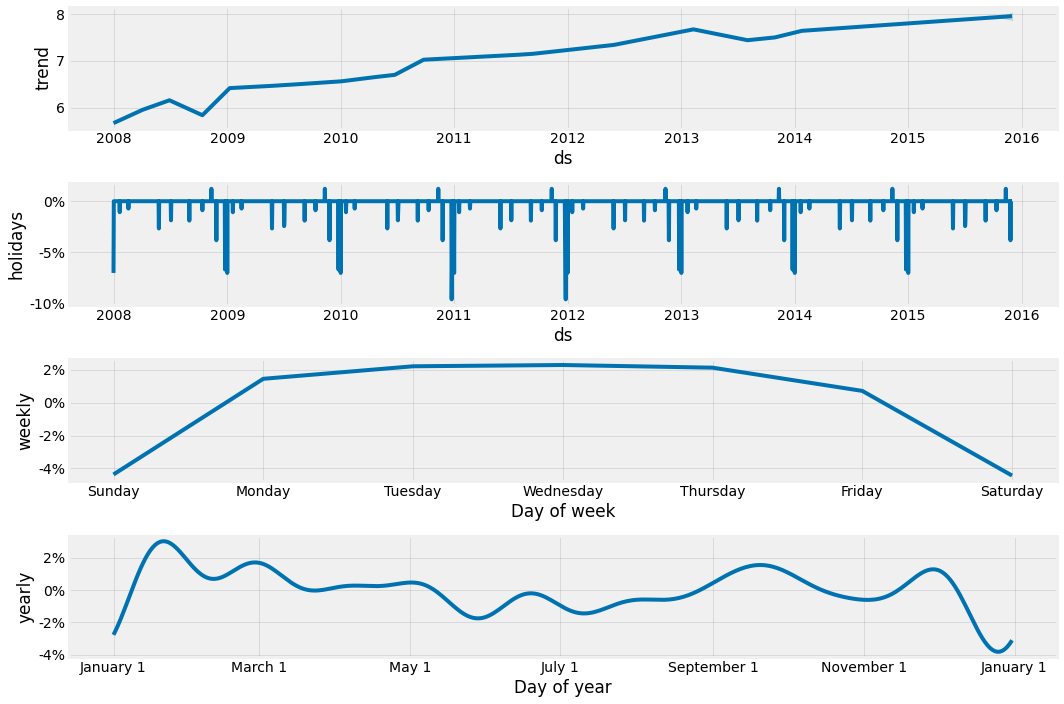

In [234]:
future = m.make_future_dataframe(periods=92, freq='D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

By default, the `forecast` dataframe contains an abundance of information, including point/upper/lower estimates of the contribution made to the forecast by the trend component, different seasonalities and each holiday defined in the model:

In [235]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiv

While interesting if you want to examine every component in detail, for this example we will focus on the point forecast and the associated confidence band:

In [236]:
xfor = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].loc[forecast['ds'] >= '2017-10-01' ]
xfor.head(10)

Empty DataFrame
Columns: [ds, yhat, yhat_upper, yhat_lower]
Index: []

In [237]:
# we combine the forecast dataframe with the original test data we use a left outer join because of the missing observations in the original data
xfor = pd.merge(left = xfor, right = df, on = 'ds', how = 'left')

In [238]:
xfor.head(10)

Empty DataFrame
Columns: [yhat, yhat_upper, yhat_lower, ds, y]
Index: []

<AxesSubplot:>

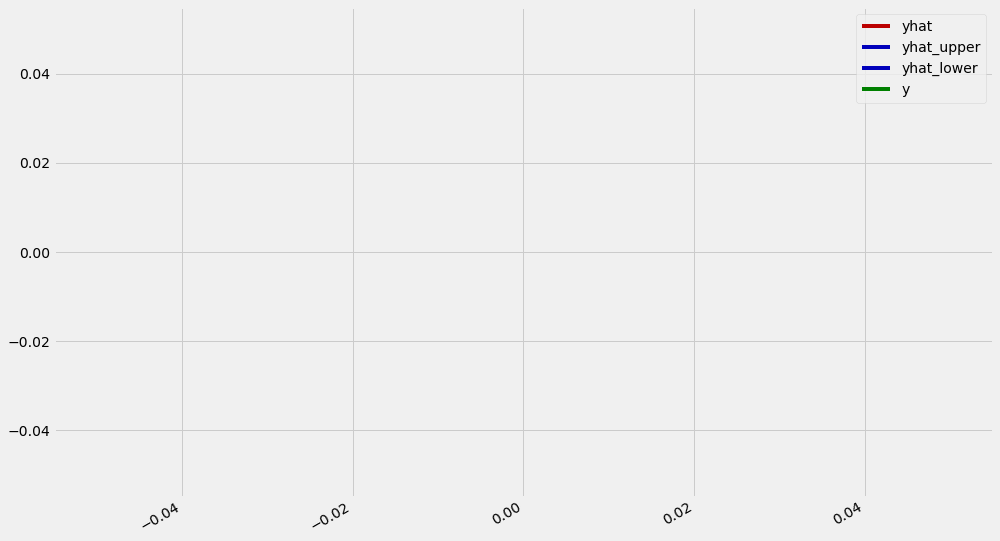

In [239]:
colors = ['#BB0000' , '#0000BB', '#0000BB', 'green']
xfor['ds'] = pd.to_datetime(xfor['ds'])
xfor.set_index('ds').plot(color = colors, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

While there is definitely space for improvement - the model does not capture the magnitude of the variations, and the associated confidence interval is rather broad - this example demonstrates that with minimal effort, we can use Prophet to model time series in a fast and intrepretable manner.

<a id="section-seven"></a>
# Using covariates

It is not a terribly common situation, but sometimes we get lucky and there is extra information we can use to improve the quality of our forecast: stable weather prediction, or some economic indicators made known earlier than others. In this section we demonstrate how this functionality works in Prophet. First thing we do, we load our dataset (recorded performance of the teams in the Autonomous Greenhouse Challenge) - we will focus on the subset of the original problem, namely how to predict the air temperature based on the settings in the greenhouse environment. The original dataset can be found here: https://www.kaggle.com/piantic/autonomous-greenhouse-challengeagc-2nd-2019.


In [241]:
xdat = pd.read_csv(GreenhouseClimate1)
xdat.head(3)

time  AssimLight   BlackScr  CO2air  Cum_irr  EC_drain_PC  EnScr  \
0  43815.00000         0.0  35.000000   439.0     0.48         3.61   96.0   
1  43815.00347         0.0  85.000001   459.0     0.72         3.61   96.0   
2  43815.00694         0.0  95.999999   461.0     0.72         3.61   94.6   

   HumDef  PipeGrow  PipeLow  ...  t_rail_min_sp  t_rail_min_vip  t_vent_sp  \
0    6.96       0.0     50.9  ...            NaN             0.0        NaN   
1    7.45       0.0     49.3  ...            NaN             0.0        NaN   
2    5.99       0.0     47.6  ...            NaN             0.0        NaN   

   t_ventlee_vip  t_ventwind_vip  water_sup  water_sup_intervals_sp_min  \
0           25.0            26.0        4.0                         NaN   
1           25.0            26.0        6.0                         NaN   
2           25.0            26.0        6.0                         NaN   

   water_sup_intervals_vip_min  window_pos_lee_sp  window_pos_lee_vip  
0                       1000.0                NaN                 1.2  
1                       1000.0                NaN                 1.2  
2                       1000.0                NaN                 1.2  

[3 rows x 50 columns]

That's a lot of columns, and we will get to that in a moment - but first, we need to do something about the timestamp. The original data was sampled every 5 minutes and stored in Excel format, which is why need to adjust the epoch start:

In [242]:
xdat['time'] = pd.to_datetime(xdat['time'], unit = 'D', origin = "1899-12-30")
xdat.head(3)

time  AssimLight   BlackScr  CO2air  Cum_irr  \
0 2019-12-16 00:00:00.000000000         0.0  35.000000   439.0     0.48   
1 2019-12-16 00:04:59.808000256         0.0  85.000001   459.0     0.72   
2 2019-12-16 00:09:59.616000000         0.0  95.999999   461.0     0.72   

   EC_drain_PC  EnScr  HumDef  PipeGrow  PipeLow  ...  t_rail_min_sp  \
0         3.61   96.0    6.96       0.0     50.9  ...            NaN   
1         3.61   96.0    7.45       0.0     49.3  ...            NaN   
2         3.61   94.6    5.99       0.0     47.6  ...            NaN   

   t_rail_min_vip  t_vent_sp  t_ventlee_vip  t_ventwind_vip  water_sup  \
0             0.0        NaN           25.0            26.0        4.0   
1             0.0        NaN           25.0            26.0        6.0   
2             0.0        NaN           25.0            26.0        6.0   

   water_sup_intervals_sp_min  water_sup_intervals_vip_min  window_pos_lee_sp  \
0                         NaN                       1000.0                NaN   
1                         NaN                       1000.0                NaN   
2                         NaN                       1000.0                NaN   

   window_pos_lee_vip  
0                 1.2  
1                 1.2  
2                 1.2  

[3 rows x 50 columns]

That's better. Reading through the Readme in the description of the original dataset, we can identify the variables that are available going forward. Since only those are useful as external covariates potentially helpful with our forecast, we can subset the dataframe:

In [243]:
# timestamp and target variable
list1 = ['time', 'Tair']
# candidate variables for external regressors improving the forecast
list2 = ['co2_sp', 'dx_sp', 't_rail_min_sp', 't_grow_min_sp',
        'assim_sp', 'scr_enrg_sp', 'scr_blck_sp', 't_heat_sp',
        't_vent_sp', 'window_pos_lee_sp', 'water_sup_intervals_sp_min',
        'int_blue_sp', 'int_red_sp', 'int_farred_sp',
        'int_white_sp']
xdat = xdat[list1 + list2]

A realistic lookahead period might be 24 hours - we can either stick to the original resolution of the data and forecast 24 * 12 = 288 steps ahead, or downsample the data to hourly frequency. Since all the variables are numerical, we just take their average values within each hour:

In [244]:
xdat2 = xdat.resample('H', on = 'time').mean().reset_index()[list1 + list2]

In [245]:
# let's quickly check for missing values - Prophet can handle those (by interpolation), but they are not useful in terms of predictive value
np.isnan(xdat2[['Tair'] + list2]).describe()

Tair co2_sp  dx_sp t_rail_min_sp t_grow_min_sp assim_sp scr_enrg_sp  \
count    3985   3985   3985          3985          3985     3985        3985   
unique      2      2      2             2             2        2           2   
top     False  False  False         False         False    False       False   
freq     3983   3945   3944          3944          3878     3944        3944   

       scr_blck_sp t_heat_sp t_vent_sp window_pos_lee_sp  \
count         3985      3985      3985              3985   
unique           2         2         2                 2   
top          False     False     False             False   
freq          3944      3945      3945              3944   

       water_sup_intervals_sp_min int_blue_sp int_red_sp int_farred_sp  \
count                        3985        3985       3985          3985   
unique                          2           1          1             1   
top                         False       False      False         False   
freq                         3901        3985       3985          3985   

       int_white_sp  
count          3985  
unique            1  
top           False  
freq           3985

<AxesSubplot:>

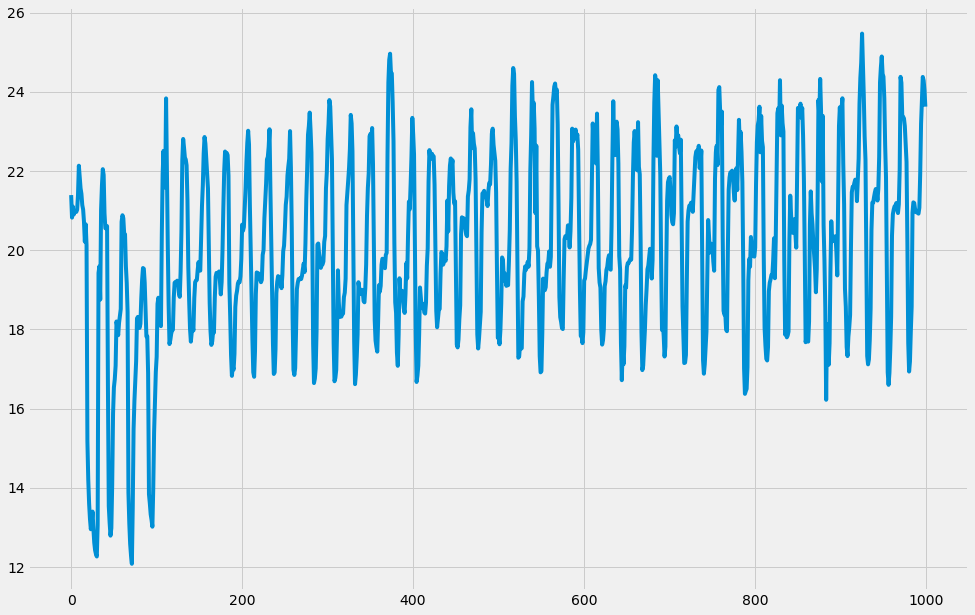

In [246]:
xdat2.dropna(subset = ['Tair'], inplace = True)
# what does our data look like after preparation? 
xdat2['Tair'][0:1000].plot()

This looks ready for applying Prophet: as before, we start by formatting the dataframe into the format expected by the algorithm

In [247]:
df = xdat2[['time', 'Tair']].rename(columns={"time": "ds", "Tair": "y"})

The only real adjustment we need is disabling weekly seasonality. By default, Prophet fits any seasonal pattern with enough data - annual pattern will not be fitted since we only have 6 months worth of data, hourly is automatic, but weekly makes no sense for a physical phenomenon (there is no reason to expect temperature to be dependent on day of the week).

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -25.0512
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10300.7     0.0111439        1764.1      0.3729           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10319.5   0.000897444       222.126           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         10324    0.00131037       181.384      0.8045      0.8045      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       10324.5   3.76522e-05       121.262    3.91e-07       0.001      515  LS failed, Hessian reset 
     399       10324.6   5.66775e-06        60.397   1.057e-07       0.001      583  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     419       1

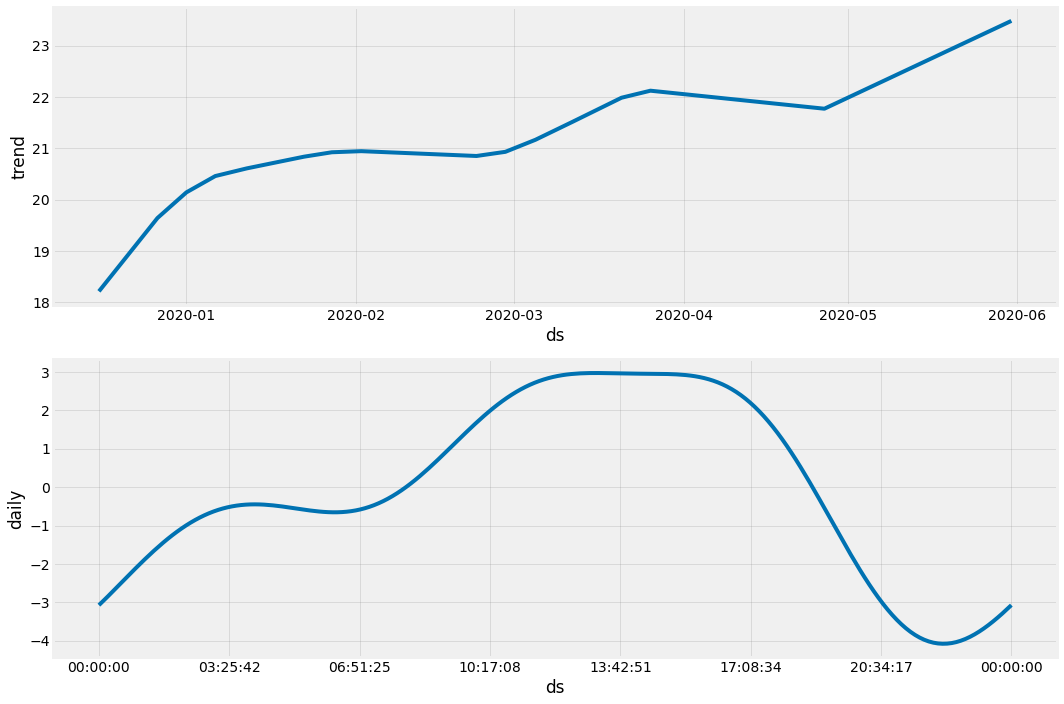

In [248]:
m = Prophet(weekly_seasonality=False, interval_width = 0.95)
m.fit(df)
# build the forecast the usual way
future = m.make_future_dataframe(periods= 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

In [249]:
# Calculate the cross-validation performance
df_cv = cross_validation(m,initial = '3700 hours', period = '24 hours', horizon = '24 hours')
df_p1 = performance_metrics(df_cv)
df_p1.head(10)

INFO:fbprophet:Making 11 forecasts with cutoffs between 2020-05-18 23:00:00 and 2020-05-28 23:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -24.5512
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9408.41    0.00705538       459.471           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9421.39     0.0782182       485.221           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9428.26    0.00111548       134.383      0.3095           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9429.73   0.000130834       97.8802      0.3321      0.3321      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          9430   0.000272408       80.7221       0.979       0.979      628   
    Iter      log prob        ||dx||      ||grad||       alpha  

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -24.4794
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9436.22    0.00389779       577.043      0.1218      0.6506      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9449.25    0.00266836       140.083           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       9453.09    0.00013154       313.049   2.794e-07       0.001      332  LS failed, Hessian reset 
     293       9455.27   3.59743e-05       85.3513   2.477e-07       0.001      442  LS failed, Hessian reset 
     299       9455.42   0.000931936       167.312           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9456.71   3.23968e-05       84.8985   2.866e-07       0.001      616  LS failed, Hessian rese

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -21.2404
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9523.43    0.00481916       609.812      0.8666      0.8666      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9539.33     0.0170564       181.303      0.8889      0.8889      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9541.84    0.00188016        88.022           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9542.85   0.000212736          99.6      0.7367      0.7367      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424          9543   5.25458e-05       131.456   3.518e-07       0.001      582  LS failed, Hessian reset 
     459       9543.15   9.82265e-06    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -15.5778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9914.25   0.000448338       118.667           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       9923.47   3.55954e-05       115.644   2.806e-07       0.001      245  LS failed, Hessian reset 
     199       9925.76    0.00835517       408.474      0.4743           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       9926.98    4.2407e-05       141.924   2.719e-07       0.001      370  LS failed, Hessian reset 
     270       9928.46   7.78599e-05       166.404   9.353e-07       0.001      474  LS failed, Hessian reset 
     299       9928.87   9.93116e-05       105.175      0.6015      0.6015      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -20.6792
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9971.27     0.0115061       597.922           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9981.12    0.00274804       129.973      0.6879      0.6879      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9986.21   0.000431743       59.8263      0.2825           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       9986.36   4.22453e-05       119.785   2.034e-07       0.001      428  LS failed, Hessian reset 
     346       9986.61   3.49741e-05       109.128   3.581e-07       0.001      517  LS failed, Hessian reset 
     384       9986.71    7.3357e-05       223.647   2.505e-07       0.001      613  LS failed, Hessian rese

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -22.7955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10020.9    0.00420083        568.81           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10031.3    0.00074098        324.94      0.4851           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       10037.9   0.000194639       258.053   1.561e-06       0.001      368  LS failed, Hessian reset 
     299       10039.2   0.000626151       149.427      0.5718      0.5718      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10040.7    0.00287684       134.419       4.648      0.4648      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     439       10040.8   7.42589e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -21.7671
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10068.4    0.00976609       963.501           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10084.3    0.00254811       694.269           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10088.3   2.23955e-05       328.834    0.001886           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       10088.6   2.77773e-05       84.8229   2.145e-07       0.001      490  LS failed, Hessian reset 
     399       10088.8    0.00168798       91.1576           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10089.4   9.49401e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -20.3784
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         10123    0.00323172       522.013           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10140.8    0.00327018       169.146           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267       10144.6    5.0766e-05       145.492   3.535e-07       0.001      344  LS failed, Hessian reset 
     299       10144.7   1.23379e-05       52.9076      0.4178           1      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       10144.9    0.00012911       270.492   7.196e-07       0.001      458  LS failed, Hessian reset 
     396       10145.1   3.59104e-05       105.187   5.239e-07       0.001      642  LS failed, Hessian rese

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -18.8779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10173.2    0.00394346       409.587           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10186.8   0.000748539       173.999       0.402           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10194.5   0.000213062       115.054      0.7489      0.7489      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       10195.4   0.000246518        138.34   1.403e-06       0.001      481  LS failed, Hessian reset 
     399       10195.9   0.000207528       194.565       9.264      0.9264      541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10196.3   6.24059e-05    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -21.4872
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10229.1     0.0597039       536.427           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10242.2    0.00167662       793.195      0.2886      0.2886      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10247.5   0.000177486       184.373      0.3045      0.8099      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       10247.8   2.83785e-05       88.0234   2.192e-07       0.001      437  LS failed, Hessian reset 
     399       10248.7    0.00215466       140.296           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10249.3   0.000194157    

DEBUG:fbprophet:Loaded stan backend: PYSTAN


Initial log joint probability = -18.5701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10253.8     0.0211956       530.873           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10264.3    0.00593959       300.031           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       10264.5   0.000118327       359.152   2.745e-07       0.001      306  LS failed, Hessian reset 
     299       10268.1    0.00228359       143.531      0.3095           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       10268.8   7.48346e-05       132.952   9.899e-07       0.001      590  LS failed, Hessian reset 
     399       10268.8    5.8347e-05       101.545      0.5357      0.5357      602   
    Iter      log pro

horizon       mse      rmse       mae      mape     mdape  coverage
0 0 days 03:00:00  4.345274  2.084532  1.871220  0.097022  0.097954  0.846154
1 0 days 04:00:00  5.200849  2.280537  2.071549  0.105279  0.102057  0.793706
2 0 days 05:00:00  5.909014  2.430846  2.219437  0.111473  0.115507  0.765734
3 0 days 06:00:00  6.261375  2.502274  2.292945  0.114890  0.115751  0.741259
4 0 days 07:00:00  5.447567  2.334002  2.122007  0.105547  0.115612  0.804196
5 0 days 08:00:00  3.124092  1.767510  1.479235  0.071379  0.052694  0.919580
6 0 days 09:00:00  1.800709  1.341905  1.079301  0.047788  0.039021  0.947552
7 0 days 10:00:00  2.159082  1.469381  1.204153  0.048903  0.042151  0.884615
8 0 days 11:00:00  2.994679  1.730514  1.461385  0.057782  0.045791  0.870629
9 0 days 12:00:00  3.527553  1.878178  1.533083  0.060270  0.050650  0.856643

This gives us an idea of the model performance in a "vanilla" version. Let's add the covariates:

In [250]:
# we need to drop NA - Prophet can handle missing values in the target, but not in the explanatory variables 
# (and neither does the recursive feature elimination routine RFECV)
xdat2 = xdat2.dropna()
# for the sake of demonstration, we keep it simple - so Ridge is good enough to check the importance of a variable for our target prediction
estimator = Ridge()
# the elimination is a bit aggressive
selector =  RFECV(estimator, step=10, cv=10)
selector = selector.fit(xdat2[list2], xdat2['Tair'])
to_keep = xdat2[list2].columns[selector.support_]
print(to_keep)

Index(['dx_sp', 't_rail_min_sp', 't_heat_sp', 't_vent_sp',
       'window_pos_lee_sp'],
      dtype='object')


In [251]:
# We can now fit our model with the regressors included
df = xdat2[['time', 'Tair']].rename(columns={"time": "ds", "Tair": "y"})
m = Prophet(weekly_seasonality=False, interval_width=0.95)

# add the regressors to the dataframe holding the data
for f in to_keep:    
    df[f] = xdat2[f]
    m.add_regressor(f)

# the rest proceeds as before. 
m.fit(df)

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -33.0434


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       12359.9   0.000720774       1103.79           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       12367.5   9.81655e-05       207.094      0.6547      0.6547      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       12369.1   1.81726e-05        527.58      0.2928      0.2928      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       12370.6   0.000731774       1025.24      0.9553      0.9553      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       12371.8   0.000433728       406.224           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

We want to compare the "vanilla" and extended models, to we conduct the validation in exact same manner

In [ ]:
# we repeat the same evaluation tactic as before
df_cv = cross_validation(m, initial='3700 hours', period='24 hours', horizon='24 hours')
df_p2 = performance_metrics(df_cv)
df_p2.head(3)

How do the two models compare ?

In [ ]:
comparison = pd.DataFrame()
comparison['raw'] = df_p1.mean(axis = 0)[1:]
comparison['covariates'] = df_p2.mean(axis = 0)[1:]
print(comparison)

As you can see from the above table, with minimal effort of adding the covariates we can improve the performance of the model wrt all the relevant metrics. 

<a id="section-seven"></a>
# Neural Prophet

If an algorithmic approach works well in ML, the question worth asking is frequently: will it get better with Deep Learning? The answer, surprisingly often is affirmative - and that was the core idea behind Neural Prophet. The changes compared to the "basic" Prophet are given on the project website

https://neuralprophet.com/html/index.html:

* Gradient Descent for optimisation via using PyTorch as the backend.
* Modelling autocorrelation of time series using AR-Net
* Modelling lagged regressors using a sepearate Feed-Forward Neural Network.
* Configurable non-linear deep layers of the FFNNs.
* Tuneable to specific forecast horizons (greater than 1).
* Custom losses and metrics.

The core addition from a conceptual point of view seems to be the AR-Net - for those interested, the original paper can be found here:

https://www.arxiv-vanity.com/papers/1911.12436/.

Is Neural Prophet really better? As the Russian proverb says "trust, but verify", so let's find out!


In honor of the classic Dead Kennedys song, we will use the data on energy consumption in the U.S. state of California:

<AxesSubplot:xlabel='ds'>

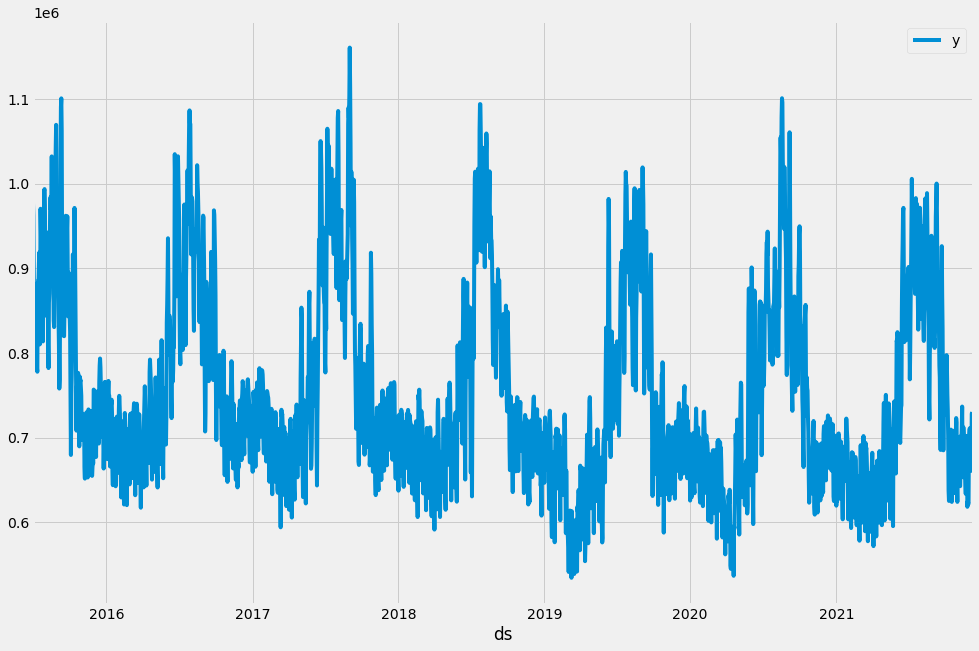

In [252]:
# read the raw *daily* data
Region_CAL = pd.read_excel(Region_CAL, sheet_name='Published Daily Data', header=0, usecols=['Local date', 'D'])
# format to Prophet convention - both Prophet and Neural Prophet adheres to it
Region_CAL.columns = ['ds','y']
Region_CAL['ds'] = pd.to_datetime(Region_CAL['ds'])
Region_CAL.plot(x="ds",y="y")

In [253]:
# We split the data into training / validation (= last 365 days)
df_train, df_valid = df.iloc[:-365], df.iloc[-365:]

Fitting the basic Prophet model and generating a forecast is a familiar routine by now:

DEBUG:fbprophet:Trying to load backend: PYSTAN
DEBUG:fbprophet:Loaded stan backend: PYSTAN
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -18.118
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        9039.2    0.00882797       154.502           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9042.24    0.00522873       98.6372      0.5834           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       9043.35   3.46254e-05       90.1922   2.676e-07       0.001      364  LS failed, Hessian reset 
     299       9043.47    9.2478e-05       74.6897      0.4181      0.4181      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       9043.57   5.10893e-05       128.628    5.63e-07       0.001      470  LS failed, Hessian reset 
     399       9043.75   0.000207051       70.5164      0.4795           1      575   
    Iter      log prob

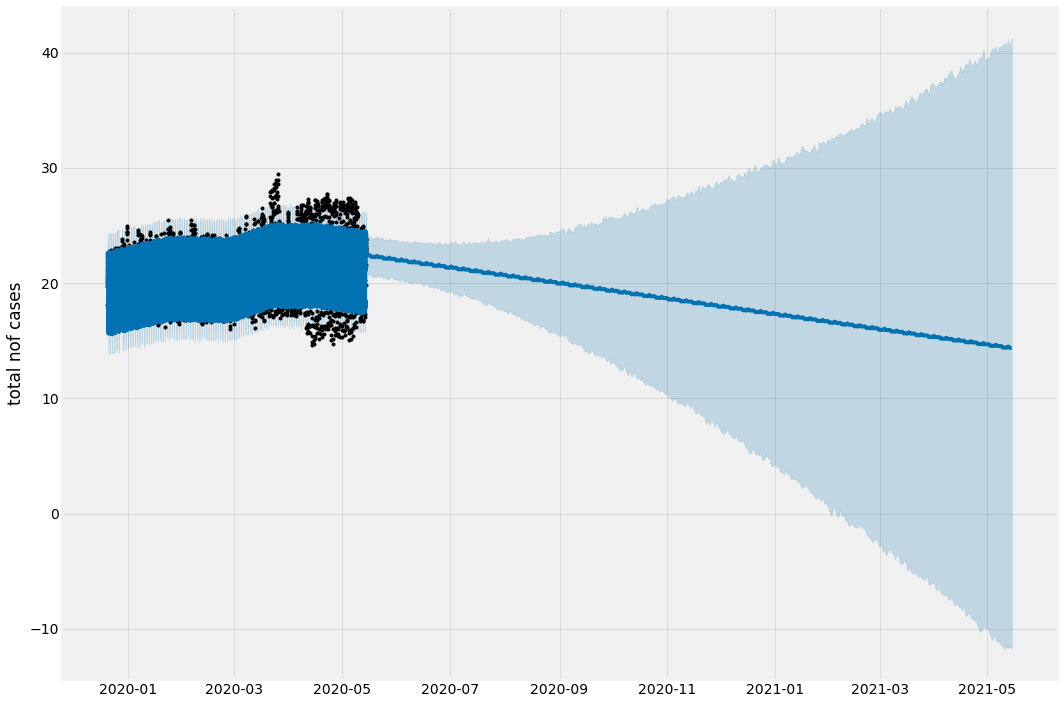

In [255]:
m_vanilla = Prophet()
m_vanilla.fit(df_train)
future = m_vanilla.make_future_dataframe(periods=365)
forecast_vanilla = m_vanilla.predict(future)
m_vanilla.plot(forecast_vanilla, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='', ylabel='total nof cases')
print()

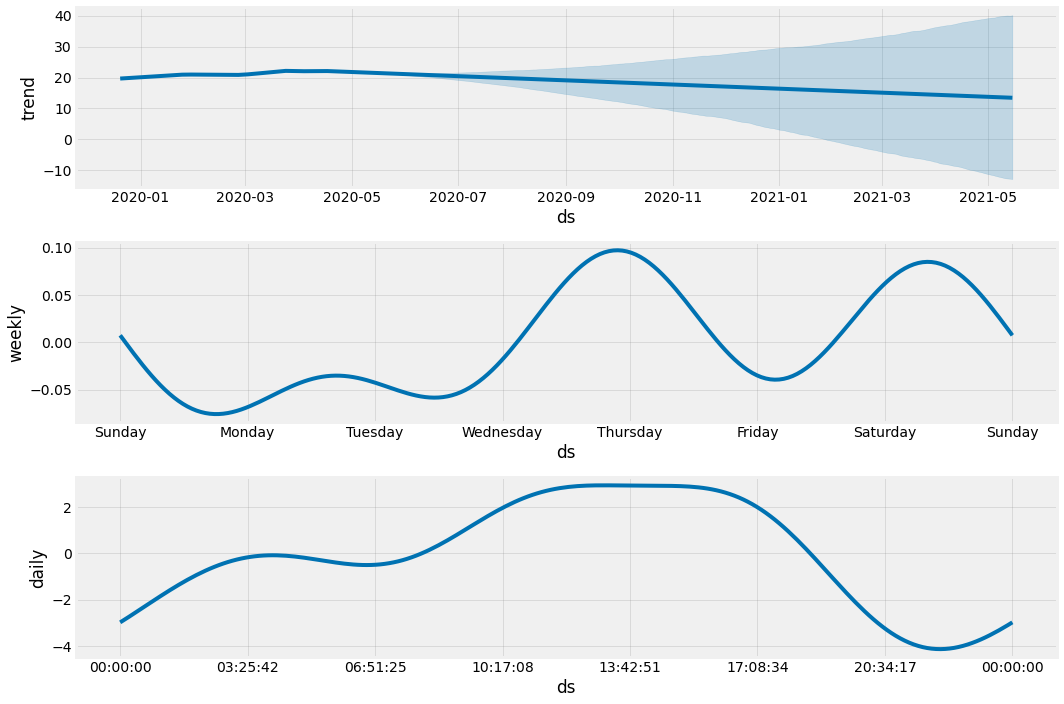

In [256]:
m_vanilla.plot_components(forecast_vanilla, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

Neural Prophet requires minimal adjustments to the syntax:

In [257]:
pd.options.mode.chained_assignment = None
m_neural = NeuralProphet()
metrics = m_neural.fit(df_train, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.424% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.424% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.


ValueError: Unexpected column dx_sp in data

In [258]:
df_future = m_neural.make_future_dataframe(df_train, periods=365)
forecast_neural = m_neural.predict(df_future)
fig_forecast = m_neural.plot(forecast_neural, figsize=(CFG.img_dim1, CFG.img_dim2))  # create plots

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.424% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.424% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency H


ValueError: Model has not been fitted. Predictions will be random.

In [ ]:
fig_components = m_neural.plot_components(forecast_neural, figsize=(CFG.img_dim1, CFG.img_dim2))

What about the actual predicted values?



In [ ]:
df_valid['forecast_vanilla'] = forecast_vanilla.yhat.tail(365).values
df_valid['forecast_neural'] = forecast_neural.yhat1.values

In [ ]:
def my_mse(x,y):
    """

    :param x:
    :param y:
    :return:
    """
    return np.round(np.sqrt(mse(x, y)),2)


def my_mae(x,y):
    """

    :param x:
    :param y:
    :return:
    """
    return np.round(np.sqrt(mae(x, y)),2)

In [ ]:
df_valid.dropna(inplace = True)

err1 = my_mse(df_valid['y'], df_valid['forecast_vanilla'])
err2 = my_mse(df_valid['y'], df_valid['forecast_neural'])

print('MSE vanilla: ' + str(err1))
print('MSE neural : ' + str(err2))

err1 = my_mae(df_valid['y'], df_valid['forecast_vanilla'])
err2 = my_mae(df_valid['y'], df_valid['forecast_neural'])

print('   ')
print('MAE vanilla: ' + str(err1))
print('MAE neural : ' + str(err2))

As we can see above, even with default settings (no lags, only the AR-Net used to model serial dependence) the **Neural Prophet outperforms the non-deep version**.


This concludes the notebook dedicated to Prophet - next, we will have a look at a framework that integrates multiple models encountered so far. Stay tuned!
